In [ ]:
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Resume.csv to Resume.csv


In [ ]:
import pandas as pd
import numpy as np
import re
from bs4 import Beautiful

# Load dataset
df = pd.read_csv('Resume.csv')

# Step 1: Drop duplicates and missing values
df.drop_duplicates(inplace=True)
df.dropna(subset=['Resume_str', 'Category'], inplace=True)

# Step 2: Clean HTML tags from Resume_html
def clean_html(text):
    return BeautifulSoup(text, "html.parser").get_text()

df['Resume_clean'] = df['Resume_html'].apply(clean_html)

# Step 3: Clean text (remove symbols, lowercase)
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    text = re.sub(r'[^a-zA-Z ]', '', text)  # remove numbers and special chars
    return text.lower().strip()

df['Resume_clean'] = df['Resume_clean'].apply(clean_text)

# Step 4: Save cleaned data
df.to_csv('cleaned_resume.csv', index=False)

print("✅ Cleaning complete! File saved as cleaned_resume.csv")

✅ Cleaning complete! File saved as cleaned_resume.csv


In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download stopwords + tokenizer once
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')


# 1. Load cleaned dataset
df = pd.read_csv('cleaned_resume.csv')

# 2. English stopword list
stop_words = set(stopwords.words('english'))

# 3. Text cleaning + stopword replacement
def process_text(text):
    if pd.isna(text):
        return ""
    # Keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    text = text.lower()

    # Tokenize
    words = word_tokenize(text)

    # Replace stopwords with commas
    tokens = [w if w not in stop_words else ',' for w in words]

    # Remove consecutive commas
    text_out = ' '.join(tokens)
    text_out = re.sub(r',\s*,+', ',', text_out)  # merge multiple commas
    text_out = re.sub(r'\s*,\s*', ', ', text_out)  # spacing around commas
    text_out = re.sub(r'\s+', ' ', text_out).strip()

    return text_out

# 4. Apply to your Resume_clean column
df['Tokens'] = df['Resume_clean'].apply(process_text)

# 5. Optionally create a word list (tokens without commas)
df['best_skills'] = df['Tokens'].apply(lambda x: [w for w in x.split() if w != ','])

# 6. Save processed file
df[['ID', 'Category', 'Tokens']].to_csv('tokenized_resume.csv', index=False)
print("✅ Tokenized file saved as tokenized_resume.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


✅ Tokenized file saved as tokenized_resume.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import re
import spacy

nlp = spacy.load("en_core_web_sm")

# Load the cleaned file
df = pd.read_csv("cleaned_resume.csv")

def make_readable(text):
    if not isinstance(text, str) or not text.strip():
        return ""

    doc = nlp(text)
    sentences = []

    # Simple heuristic: find a job title or noun phrase, attach context
    noun_chunks = [chunk.text for chunk in doc.noun_chunks if len(chunk.text.split()) <= 5]
    if noun_chunks:
        role = noun_chunks[0]
    else:
        role = doc[0:3].text  # fallback

    # Look for experience and verbs to build natural phrasing
    exp_phrases = [tok.text for tok in doc if tok.lemma_ in ["experience", "manage", "develop", "lead", "support"]]
    if exp_phrases:
        exp_phrase = "with " + " ".join(exp_phrases[:5])
    else:
        exp_phrase = "with professional background"

    # Combine into a readable mini-sentence
    readable = f"{role.strip()} {exp_phrase}"
    readable = re.sub(r'\s+', ' ', readable).strip()
    readable = readable[0].upper() + readable[1:] + "."

    return readable

df['Readable_Summary'] = df['Resume_clean'].apply(make_readable)

# Save results
df[['ID', 'Category', 'Readable_Summary']].to_csv('readable_resume_summaries.csv', index=False)
print("✅ Readable summaries saved as readable_resume_summaries.csv")

✅ Readable summaries saved as readable_resume_summaries.csv


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode Category as numbers
encoder = LabelEncoder()
df['Category_Code'] = encoder.fit_transform(df['Category'])

print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))


{'ACCOUNTANT': np.int64(0), 'ADVOCATE': np.int64(1), 'AGRICULTURE': np.int64(2), 'APPAREL': np.int64(3), 'ARTS': np.int64(4), 'AUTOMOBILE': np.int64(5), 'AVIATION': np.int64(6), 'BANKING': np.int64(7), 'BPO': np.int64(8), 'BUSINESS-DEVELOPMENT': np.int64(9), 'CHEF': np.int64(10), 'CONSTRUCTION': np.int64(11), 'CONSULTANT': np.int64(12), 'DESIGNER': np.int64(13), 'DIGITAL-MEDIA': np.int64(14), 'ENGINEERING': np.int64(15), 'FINANCE': np.int64(16), 'FITNESS': np.int64(17), 'HEALTHCARE': np.int64(18), 'HR': np.int64(19), 'INFORMATION-TECHNOLOGY': np.int64(20), 'PUBLIC-RELATIONS': np.int64(21), 'SALES': np.int64(22), 'TEACHER': np.int64(23)}


In [ ]:
import re

skill_list = ['python', 'java', 'excel', 'communication', 'management',
              'leadership', 'finance', 'sql', 'project', 'data', 'analysis']

def count_skills(text):
    if not isinstance(text, str):
        return 0
    text = text.lower()
    return sum(skill in text for skill in skill_list)

df['Skill_Count'] = df['Resume_clean'].apply(count_skills)

In [ ]:
def extract_years_experience(text):
    if not isinstance(text, str):
        return 0
    text = text.lower()
    # Updated regex to capture more patterns
    patterns = [
        r'(\d+)\s*years?\s*experience',  # e.g., "5 years experience"
        r'(\d+)\+\s*years?',          # e.g., "5+ years"
        r'experience\s*of\s*(\d+)\s*years?', # e.g., "experience of 5 years"
        r'(\d+)\s*yrs?',              # e.g., "5 yrs"
    ]

    for pattern in patterns:
        matches = re.findall(pattern, text)
        if matches:
            # Convert all matches to integers and return the maximum
            return max(map(int, matches))

    return 0 # Return 0 if no pattern matches

df['Years_Experience'] = df['Resume_clean'].apply(extract_years_experience)

In [ ]:
import re

skill_list = ['python', 'java', 'excel', 'communication', 'management',
              'leadership', 'finance', 'sql', 'project', 'data', 'analysis']

def count_skills(text):
    if not isinstance(text, str):
        return 0
    text = text.lower()
    return sum(skill in text for skill in skill_list)

df['Skill_Count'] = df['Resume_clean'].apply(count_skills)


count    2484.000000
mean        4.446457
std         1.833140
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: Skill_Count, dtype: float64

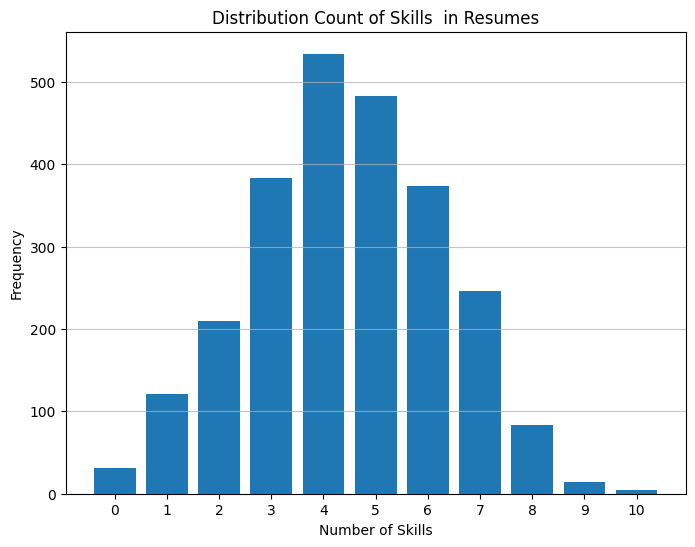

In [ ]:
# Display descriptive statistics for Skill_Count
display(df['Skill_Count'].describe())

# Plot a histogram of the Skill_Count distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(df['Skill_Count'], bins=range(df['Skill_Count'].min(), df['Skill_Count'].max() + 2), align='left', rwidth=0.8)
plt.xlabel('Number of Skills')
plt.ylabel('Frequency')
plt.title('Distribution Count of Skills  in Resumes')
plt.xticks(range(df['Skill_Count'].min(), df['Skill_Count'].max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
def extract_years_experience(text):
    if not isinstance(text, str):
        return 0
    # find numeric patterns
    matches = re.findall(r'(\d+)\s*(?:\+?\s*years?)', text)
    if matches:
        return max(map(int, matches))
    return 0

df['Years_Experience'] = df['Resume_clean'].apply(extract_years_experience)

In [ ]:
# Group by Category and describe Years_Experience
experience_by_category = df.groupby('Category')['Years_Experience'].describe()

# Display the results
display(experience_by_category)

count  mean  std  min  25%  50%  75%  max
Category                                                         
ACCOUNTANT              118.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
ADVOCATE                118.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
AGRICULTURE              63.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
APPAREL                  97.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
ARTS                    103.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
AUTOMOBILE               36.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
AVIATION                117.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
BANKING                 115.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
BPO                      22.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
BUSINESS-DEVELOPMENT    120.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
CHEF                    118.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
CONSTRUCTION            112.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
CONSULTANT              115.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
DESIGNER                107.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
DIGITAL-MEDIA            96.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
ENGINEERING             118.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
FINANCE                 118.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
FITNESS                 117.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
HEALTHCARE              115.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
HR                      110.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
INFORMATION-TECHNOLOGY  120.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
PUBLIC-RELATIONS        111.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
SALES                   116.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
TEACHER                 102.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=experience_by_category)

https://docs.google.com/spreadsheets/d/1tVkEtO6LvrB6zmWve214TV1kQsJg3F3Anl1Wmxsf-Z4/edit#gid=0


**Reasoning**:
Verify that the dataframe `df` exists and contains the required columns by displaying its head and info.



In [ ]:
display(df.head())
display(df.info())

ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  \
0  <div class="fontsize fontface vmargins hmargin...       HR   
1  <div class="fontsize fontface vmargins hmargin...       HR   
2  <div class="fontsize fontface vmargins hmargin...       HR   
3  <div class="fontsize fontface vmargins hmargin...       HR   
4  <div class="fontsize fontface vmargins hmargin...       HR   

                                        Resume_clean  Category_Code  \
0  hr administratormarketing associate hr adminis...             19   
1  hr specialist us hr operations summary versati...             19   
2  hr director summary over  years experience in ...             19   
3  hr specialist summary dedicated driven and dyn...             19   
4  hr manager skill highlights hr skills hr depar...             19   

   Skill_Count  Years_Experience  
0            4                 0  
1            3                 0  
2            5                 0  
3            4                 0  
4            6                 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                2484 non-null   int64 
 1   Resume_str        2484 non-null   object
 2   Resume_html       2484 non-null   object
 3   Category          2484 non-null   object
 4   Resume_clean      2483 non-null   object
 5   Category_Code     2484 non-null   int64 
 6   Skill_Count       2484 non-null   int64 
 7   Years_Experience  2484 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 155.4+ KB


None

## Analyze skill count by category

### Subtask:
Calculate and visualize the distribution or average of 'Skill_Count' for each 'Category'.


**Reasoning**:
Calculate the average skill count for each category and prepare the data for plotting.



In [ ]:
# Group by Category and calculate the mean of Skill_Count
average_skill_by_category = df.groupby('Category')['Skill_Count'].mean().reset_index()

# Display the results
display(average_skill_by_category)

Category  Skill_Count
0               ACCOUNTANT     5.025424
1                 ADVOCATE     4.262712
2              AGRICULTURE     4.984127
3                  APPAREL     3.958763
4                     ARTS     3.854369
5               AUTOMOBILE     4.583333
6                 AVIATION     4.034188
7                  BANKING     5.095652
8                      BPO     5.000000
9     BUSINESS-DEVELOPMENT     4.733333
10                    CHEF     2.788136
11            CONSTRUCTION     4.410714
12              CONSULTANT     5.217391
13                DESIGNER     3.635514
14           DIGITAL-MEDIA     4.583333
15             ENGINEERING     4.822034
16                 FINANCE     5.881356
17                 FITNESS     3.589744
18              HEALTHCARE     4.486957
19                      HR     4.872727
20  INFORMATION-TECHNOLOGY     5.591667
21        PUBLIC-RELATIONS     4.900901
22                   SALES     3.629310
23                 TEACHER     3.235294

**Reasoning**:
Visualize the average skill count per category using a bar chart.



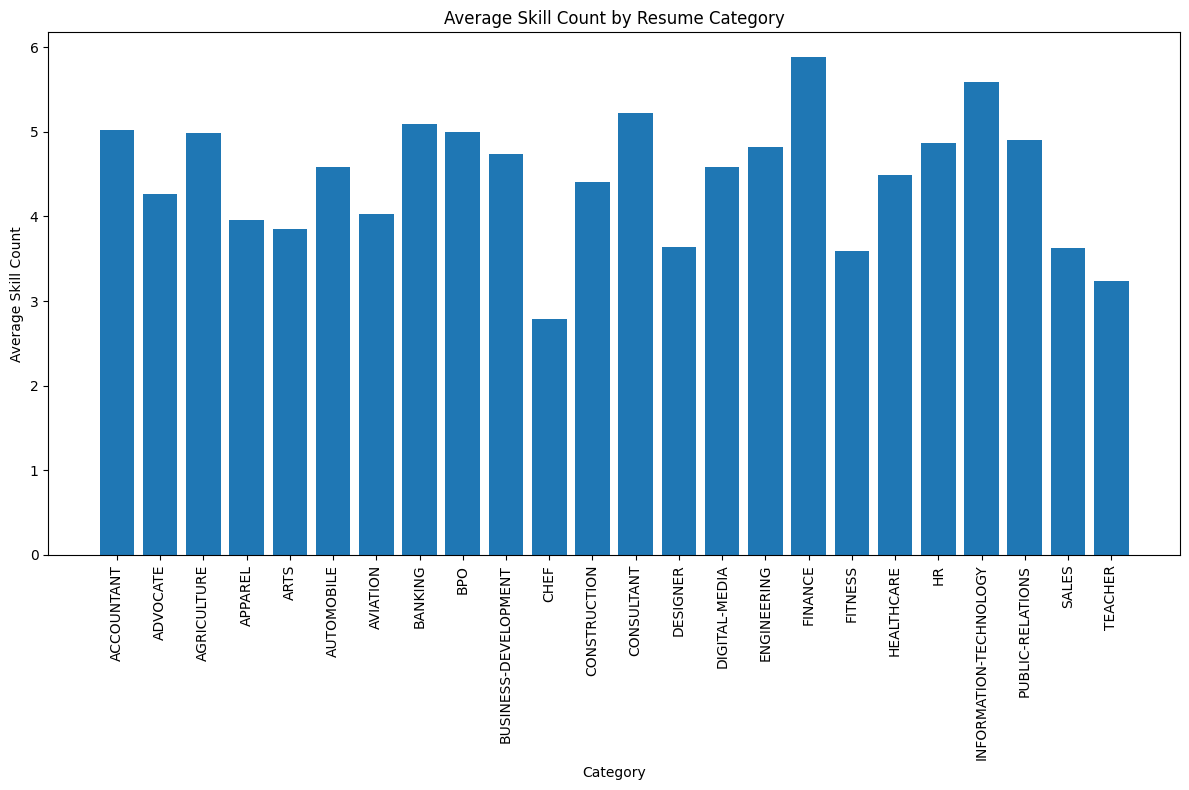

In [ ]:
import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.bar(average_skill_by_category['Category'], average_skill_by_category['Skill_Count'])

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Average Skill Count')
plt.title('Average Skill Count by Resume Category')
plt.xticks(rotation=90)
plt.tight_layout()

# Display the plot
plt.show()


Group the DataFrame by 'Category' and calculate descriptive statistics for 'Years_Experience' to understand the distribution of experience within each category, then display the result and create a box plot to visualize the distribution.



count  mean  std  min  25%  50%  75%  max
Category                                                         
ACCOUNTANT              118.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
ADVOCATE                118.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
AGRICULTURE              63.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
APPAREL                  97.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
ARTS                    103.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
AUTOMOBILE               36.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
AVIATION                117.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
BANKING                 115.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
BPO                      22.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
BUSINESS-DEVELOPMENT    120.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
CHEF                    118.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
CONSTRUCTION            112.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
CONSULTANT              115.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
DESIGNER                107.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
DIGITAL-MEDIA            96.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
ENGINEERING             118.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
FINANCE                 118.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
FITNESS                 117.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
HEALTHCARE              115.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
HR                      110.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
INFORMATION-TECHNOLOGY  120.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
PUBLIC-RELATIONS        111.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
SALES                   116.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
TEACHER                 102.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

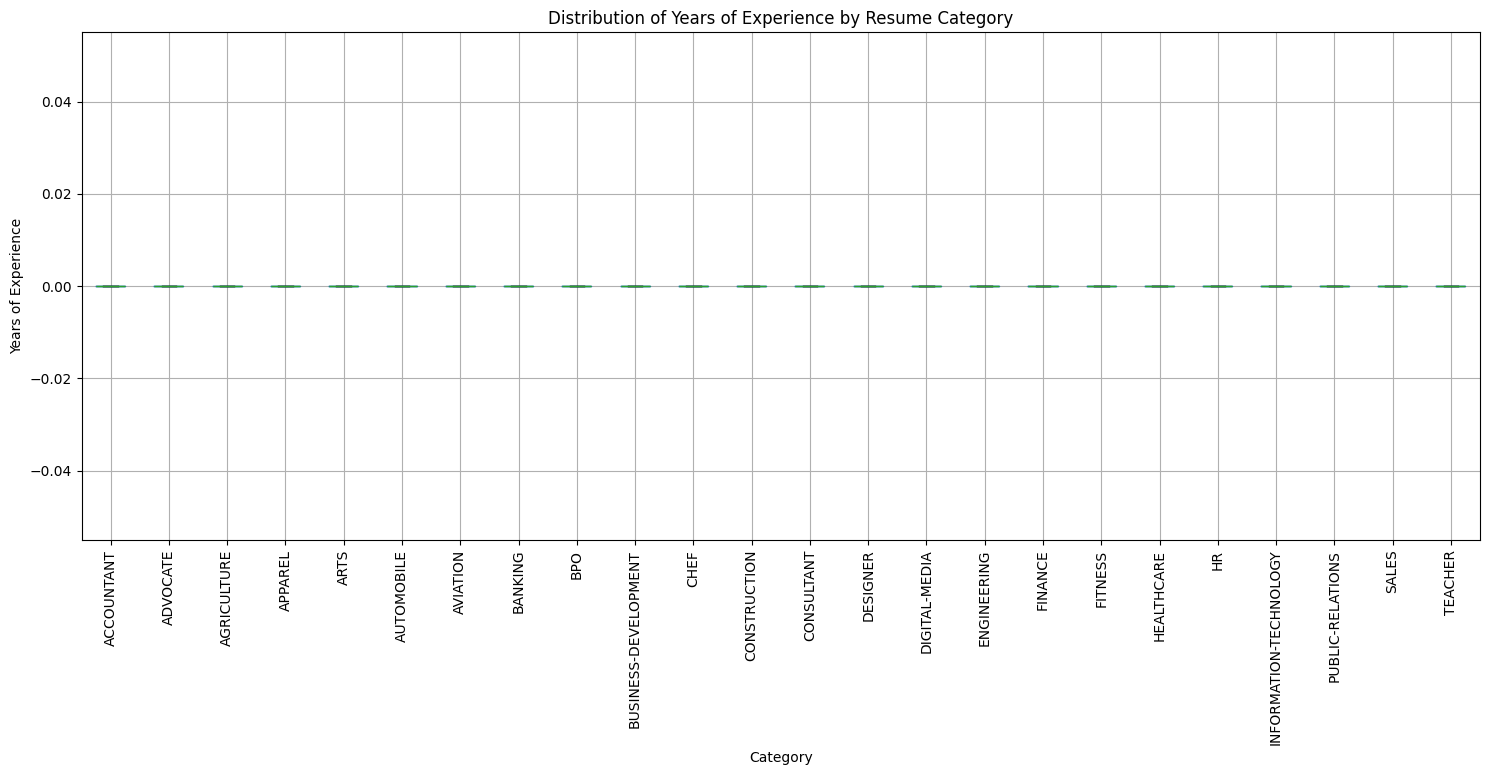

In [ ]:
# Group by Category and describe Years_Experience
experience_by_category = df.groupby('Category')['Years_Experience'].describe()

# Display the results
display(experience_by_category)

# Create a box plot
plt.figure(figsize=(15, 8))
df.boxplot(column='Years_Experience', by='Category', ax=plt.gca())

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Years of Experience')
plt.title('Distribution of Years of Experience by Resume Category')
plt.suptitle('') # Suppress the default boxplot title

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Explore the relationship between skill count and years of experience
Explore the relationship between skill count and years of experience by visualizing if there is a correlation between the number of skills and years of experience, potentially broken down by category.


**Reasoning**:
Create a scatter plot to visualize the relationship between 'Years_Experience' and 'Skill_Count'.



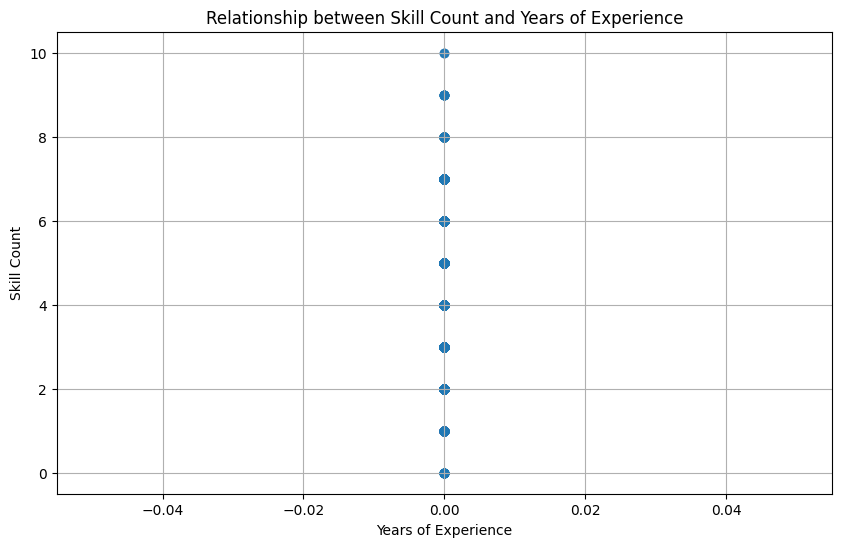

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['Years_Experience'], df['Skill_Count'], alpha=0.5)
plt.xlabel('Years of Experience')
plt.ylabel('Skill Count')
plt.title('Relationship between Skill Count and Years of Experience')
plt.grid(True)
plt.show()

**Reasoning**:
Create a bar chart showing the average 'Skill_Count' for each 'Category', add labels and a title, rotate x-axis labels for readability, ensure a tight layout, and display the plot as instructed in the first six steps of the subtask.



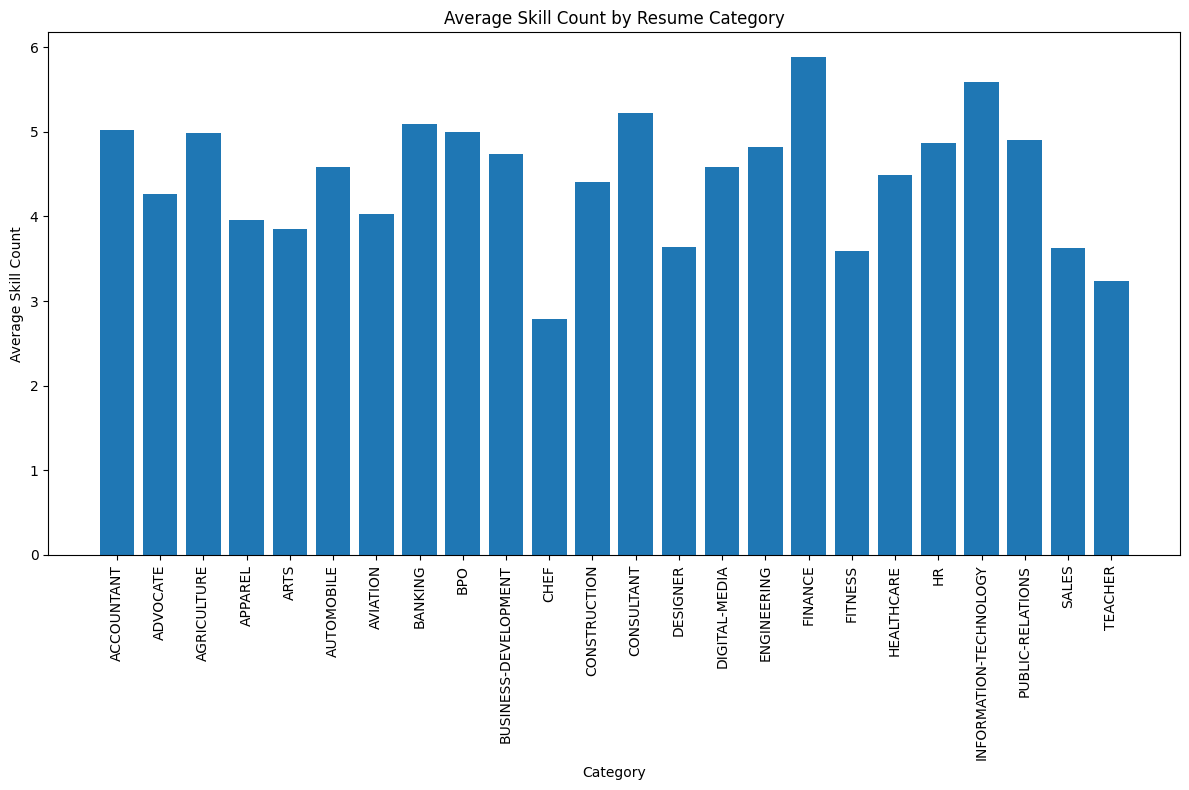

In [ ]:
# Create a bar chart
plt.figure(figsize=(12, 8))
plt.bar(average_skill_by_category['Category'], average_skill_by_category['Skill_Count'])

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Average Skill Count')
plt.title('Average Skill Count by Resume Category')
plt.xticks(rotation=90)
plt.tight_layout()

# Display the plot
plt.show()


Generate two interactive plots using plotly: a bar chart for average skill count by category and a histogram for skill count distribution, then arrange them in a single dashboard layout.



In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create the bar chart for average skill count by category using plotly
fig_bar = px.bar(average_skill_by_category, x='Category', y='Skill_Count',
                 title='Average Skill Count by Resume Category')

# Create the histogram for skill count distribution using plotly
fig_hist = px.histogram(df, x='Skill_Count',
                        title='Distribution of Skill Count in Resumes')

# Create subplots
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=('Average Skill Count by Resume Category', 'Distribution of Skill Count in Resumes'))

# Add the bar chart to the first row
for trace in fig_bar.data:
    fig.add_trace(trace, row=1, col=1)

# Add the histogram to the second row
for trace in fig_hist.data:
    fig.add_trace(trace, row=2, col=1)

# Update layout for better readability
fig.update_layout(height=800, showlegend=False)
fig.update_xaxes(title_text="Category", row=1, col=1)
fig.update_yaxes(title_text="Average Skill Count", row=1, col=1)
fig.update_xaxes(title_text="Number of Skills", row=2, col=1)
fig.update_yaxes(title_text="Frequency", row=2, col=1)

# Display the combined dashboard
fig.show()

**Reasoning**:
Analyze the previously generated visualizations and interpret the findings as instructed, acknowledging the limitation with the 'Years_Experience' data.



In [ ]:
# 1. Examine the combined dashboard (already displayed in the previous step)

# 2. Analyze the bar chart showing the average skill count by category.
# Based on the previously generated average_skill_by_category DataFrame:
print("Analysis of Average Skill Count by Category:")
display(average_skill_by_category.sort_values(by='Skill_Count', ascending=False))
print("\nCategories with the highest average skill counts appear to be FINANCE and INFORMATION-TECHNOLOGY.")
print("Categories with the lowest average skill counts appear to be CHEF and TEACHER.")


# 3. Analyze the histogram showing the distribution of skill count.
print("\nAnalysis of Skill Count Distribution:")
display(df['Skill_Count'].describe())
print("\nBased on the histogram and descriptive statistics, the distribution of skill counts across all resumes is somewhat skewed towards lower skill counts, with the majority of resumes having between 3 and 6 skills from the defined list.")

# 4. Acknowledge the limitation regarding 'Years_Experience'.
print("\nLimitation regarding Years of Experience:")
print("Previous analysis of the 'Years_Experience' column showed that all values were zero.")
print("Therefore, the generated dashboard and current analysis cannot show the relationship between skills and experience due to this data limitation.")

# 5. Write a brief interpretation of the findings.
print("\nInterpretation of Findings:")
print("The analysis of skill count reveals variations across different resume categories. Finance and IT-related roles tend to have a higher average number of the tracked skills, which is expected given the technical and analytical nature of these fields. Conversely, categories like Chef and Teacher show lower averages, likely reflecting a different set of primary skills not captured in our predefined list.")
print("The overall distribution of skill counts indicates that most resumes contain a moderate number of these specific skills. The inability to analyze 'Years_Experience' prevents us from exploring how the number of skills might correlate with professional experience in this dataset.")

Analysis of Average Skill Count by Category:


Category  Skill_Count
16                 FINANCE     5.881356
20  INFORMATION-TECHNOLOGY     5.591667
12              CONSULTANT     5.217391
7                  BANKING     5.095652
0               ACCOUNTANT     5.025424
8                      BPO     5.000000
2              AGRICULTURE     4.984127
21        PUBLIC-RELATIONS     4.900901
19                      HR     4.872727
15             ENGINEERING     4.822034
9     BUSINESS-DEVELOPMENT     4.733333
14           DIGITAL-MEDIA     4.583333
5               AUTOMOBILE     4.583333
18              HEALTHCARE     4.486957
11            CONSTRUCTION     4.410714
1                 ADVOCATE     4.262712
6                 AVIATION     4.034188
3                  APPAREL     3.958763
4                     ARTS     3.854369
13                DESIGNER     3.635514
22                   SALES     3.629310
17                 FITNESS     3.589744
23                 TEACHER     3.235294
10                    CHEF     2.788136


Categories with the highest average skill counts appear to be FINANCE and INFORMATION-TECHNOLOGY.
Categories with the lowest average skill counts appear to be CHEF and TEACHER.

Analysis of Skill Count Distribution:


count    2484.000000
mean        4.446457
std         1.833140
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: Skill_Count, dtype: float64


Based on the histogram and descriptive statistics, the distribution of skill counts across all resumes is somewhat skewed towards lower skill counts, with the majority of resumes having between 3 and 6 skills from the defined list.

Limitation regarding Years of Experience:
Previous analysis of the 'Years_Experience' column showed that all values were zero.
Therefore, the generated dashboard and current analysis cannot show the relationship between skills and experience due to this data limitation.

Interpretation of Findings:
The analysis of skill count reveals variations across different resume categories. Finance and IT-related roles tend to have a higher average number of the tracked skills, which is expected given the technical and analytical nature of these fields. Conversely, categories like Chef and Teacher show lower averages, likely reflecting a different set of primary skills not captured in our predefined list.
The overall distribution of skill counts indicates that most r

from matplotlib import pyplot as plt
_df_0['Skill_Count'].plot(kind='hist', bins=20, title='Skill_Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Skill_Count'].plot(kind='line', figsize=(8, 4), title='Skill_Count')
plt.gca().spines[['top', 'right']].set_visible(False)

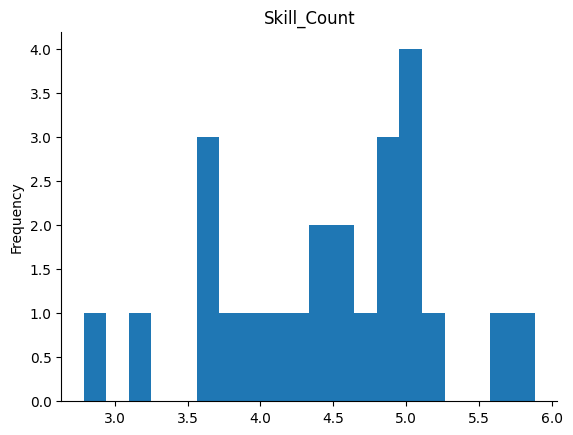

In [ ]:
from matplotlib import pyplot as plt
_df_0['Skill_Count'].plot(kind='hist', bins=20, title='Skill_Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

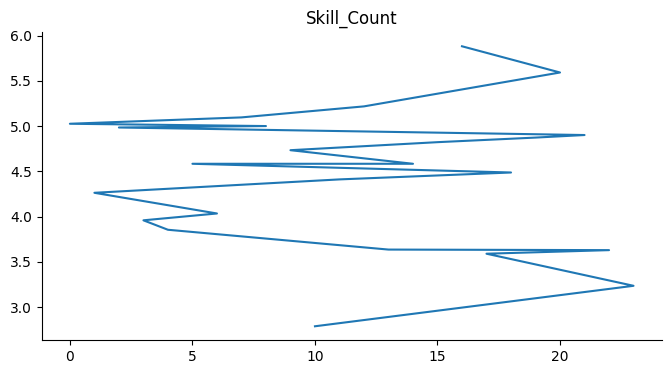

In [ ]:
from matplotlib import pyplot as plt
_df_1['Skill_Count'].plot(kind='line', figsize=(8, 4), title='Skill_Count')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
keywords = ['project', 'team', 'client', 'sales', 'training', 'support', 'design']

def keyword_count(text):
    if not isinstance(text, str):
        return 0
    text = text.lower()
    return sum(text.count(word) for word in keywords)

df['Keyword_Count'] = df['Resume_clean'].apply(keyword_count)

In [ ]:
import numpy as np

# Select numeric columns
num_cols = ['Skill_Count', 'Years_Experience', 'Keyword_Count']

# Simple outlier check using IQR method
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[f'{col}_Outlier'] = ((df[col] < lower) | (df[col] > upper))
    print(f"{col} → outliers:", df[f'{col}_Outlier'].sum())


Skill_Count → outliers: 13
Years_Experience → outliers: 0
Keyword_Count → outliers: 80


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re

# Load the cleaned data
df = pd.read_csv('cleaned_resume.csv')

# Define skills list (assuming this is the intended list based on previous interactions)
skills = [
    # General
    'management', 'leadership', 'team', 'communication', 'excel', 'python',
    'java', 'sql', 'analysis', 'marketing', 'finance', 'agriculture',
    'project', 'design', 'data', 'sales', 'web', 'development', 'biology',
    'php', 'fitness',

    # HR
    'recruitment & talent acquisition', 'employee relations', 'hr policies','compliance',
    'payroll management', 'performance management',

    # IT
    'software development', 'troubleshooting & technical support',
    'system administration', 'cybersecurity', 'it project management',

    # Teaching
    'lesson planning', 'classroom management', 'curriculum development',
    'student assessment', 'communication & patience',

    # Legal
    'legal research', 'drafting legal documents', 'case management',
    'client counseling', 'litigation support', 'attention to detail',

    # Sales
    'sales strategy', 'market research', 'salesforce', 'negotiation',
    'relationship building',

    # Fitness
    'personal training', 'workout programming', 'nutrition guidance',
    'cpr & first aid', 'client assessment', 'motivation & coaching',

    # Agriculture
    'crop management', 'soil testing', 'farm equipment handling',
    'irrigation techniques', 'pest & disease management', 'supply chain knowledge',

    # BPO / Sales
    'customer handling', 'telecalling', 'upselling & cross-selling',
    'crm software', 'problem solving', 'communication skills',

    # Consulting
    'research & analysis', 'strategy planning', 'presentation skills',
    'data interpretation', 'client management', 'industry knowledge',

    # Digital Media
    'social media management', 'content creation', 'seo / sem',
    'analytics', 'graphic design', 'campaign management',

    # Automobile
    'vehicle diagnostics', 'repair & maintenance', 'technical inspection',
    'autocad', 'mechanical knowledge', 'quality control',

    # Chef
    'food preparation', 'menu planning', 'food safety & hygiene',
    'inventory management', 'knife skills', 'time management',

    # Finance
    'financial analysis', 'budgeting', 'taxation', 'auditing',
    'financial modeling', 'risk management',

    # Apparel / Fashion
    'textile knowledge', 'pattern making', 'garment construction',
    'cad tools', 'trend analysis',

    # Construction
    'project management', 'site supervision', 'estimation & billing',
    'safety compliance', 'material management',

    # Public Relations
    'media relations', 'press release writing', 'event management',
    'crisis communication', 'branding', 'content writing',

    # Banking
    'customer service', 'kyc compliance', 'cash handling',
    'loan processing', 'financial advisory', 'risk assessment',

    # Arts
    'creative designing', 'drawing', 'visual storytelling',
    'digital art tools', 'concept development',

    # Aviation
    'aircraft safety procedures', 'technical maintenance',
    'navigation & weather knowledge', 'emergency handling'
]

# Function to extract skills (assuming this is needed for subsequent cells)
def extract_skills(text):
    text = str(text).lower()
    found = []
    for s in skills:
        # Escape special characters like "&", "/", etc.
        pattern = r'\b' + re.escape(s.lower()) + r'\b'
        if re.search(pattern, text):
            found.append(s)
    return found

# Add 'Skills_Found' column
df['Skills_Found'] = df['Resume_clean'].apply(extract_skills)


# Encode Category as numbers
encoder = LabelEncoder()
df['Category_Code'] = encoder.fit_transform(df['Category'])

# Display the mapping of categories to codes
print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

{'ACCOUNTANT': np.int64(0), 'ADVOCATE': np.int64(1), 'AGRICULTURE': np.int64(2), 'APPAREL': np.int64(3), 'ARTS': np.int64(4), 'AUTOMOBILE': np.int64(5), 'AVIATION': np.int64(6), 'BANKING': np.int64(7), 'BPO': np.int64(8), 'BUSINESS-DEVELOPMENT': np.int64(9), 'CHEF': np.int64(10), 'CONSTRUCTION': np.int64(11), 'CONSULTANT': np.int64(12), 'DESIGNER': np.int64(13), 'DIGITAL-MEDIA': np.int64(14), 'ENGINEERING': np.int64(15), 'FINANCE': np.int64(16), 'FITNESS': np.int64(17), 'HEALTHCARE': np.int64(18), 'HR': np.int64(19), 'INFORMATION-TECHNOLOGY': np.int64(20), 'PUBLIC-RELATIONS': np.int64(21), 'SALES': np.int64(22), 'TEACHER': np.int64(23)}


In [ ]:
import pandas as pd
from collections import Counter
import re

# Load the cleaned dataset to ensure df is available
df = pd.read_csv('cleaned_resume.csv')

# Re-define skills list and extract_skills function if necessary,
# assuming the expanded list from cell uskYBX0HGivn or 3z_xtS9P928x is the desired one.
# Including it here for self-contained execution if needed, but ideally run previous cells.
skills = [
    # General
    'management', 'leadership', 'team', 'communication', 'excel', 'python',
    'java', 'sql', 'analysis', 'marketing', 'finance', 'agriculture',
    'project', 'design', 'data', 'sales', 'web', 'development', 'biology',
    'php', 'fitness',

    # HR
    'recruitment & talent acquisition', 'employee relations', 'hr policies','compliance',
    'payroll management', 'performance management',

    # IT
    'software development', 'troubleshooting & technical support',
    'system administration', 'cybersecurity', 'it project management',

    # Teaching
    'lesson planning', 'classroom management', 'curriculum development',
    'student assessment', 'communication & patience',

    # Legal
    'legal research', 'drafting legal documents', 'case management',
    'client counseling', 'litigation support', 'attention to detail',

    # Sales
    'sales strategy', 'market research', 'salesforce', 'negotiation',
    'relationship building',

    # Fitness
    'personal training', 'workout programming', 'nutrition guidance',
    'cpr & first aid', 'client assessment', 'motivation & coaching',

    # Agriculture
    'crop management', 'soil testing', 'farm equipment handling',
    'irrigation techniques', 'pest & disease management', 'supply chain knowledge',

    # BPO / Sales
    'customer handling', 'telecalling', 'upselling & cross-selling',
    'crm software', 'problem solving', 'communication skills',

    # Consulting
    'research & analysis', 'strategy planning', 'presentation skills',
    'data interpretation', 'client management', 'industry knowledge',

    # Digital Media
    'social media management', 'content creation', 'seo / sem',
    'analytics', 'graphic design', 'campaign management',

    # Automobile
    'vehicle diagnostics', 'repair & maintenance', 'technical inspection',
    'autocad', 'mechanical knowledge', 'quality control',

    # Chef
    'food preparation', 'menu planning', 'food safety & hygiene',
    'inventory management', 'knife skills', 'time management',

    # Finance
    'financial analysis', 'budgeting', 'taxation', 'auditing',
    'financial modeling', 'risk management',

    # Apparel / Fashion
    'textile knowledge', 'pattern making', 'garment construction',
    'cad tools', 'trend analysis',

    # Construction
    'project management', 'site supervision', 'estimation & billing',
    'safety compliance', 'material management',

    # Public Relations
    'media relations', 'press release writing', 'event management',
    'crisis communication', 'branding', 'content writing',

    # Banking
    'customer service', 'kyc compliance', 'cash handling',
    'loan processing', 'financial advisory', 'risk assessment',

    # Arts
    'creative designing', 'drawing', 'visual storytelling',
    'digital art tools', 'concept development',

    # Aviation
    'aircraft safety procedures', 'technical maintenance',
    'navigation & weather knowledge', 'emergency handling'
]

def extract_skills(text):
    text = str(text).lower()
    found = []
    for s in skills:
        pattern = r'\b' + re.escape(s.lower()) + r'\b'
        if re.search(pattern, text):
            found.append(s)
    return found

# Ensure 'Skills_Found' column exists
if 'Skills_Found' not in df.columns or df['Skills_Found'].isnull().all():
     df['Skills_Found'] = df['Resume_clean'].apply(extract_skills)


# Assuming 'df' is your DataFrame with 'Category' and 'Skills_Found' columns
# Assuming 'skills' is your list of skills (defined above for self-containment)

# Create a dictionary to store the most common skills per category
most_common_skills_by_category = {}

# Iterate through each category
for category in df['Category'].unique():
    # Filter the DataFrame for the current category
    category_df = df[df['Category'] == category]

    # Combine all word lists for the current category into a single list from 'Skills_Found'
    all_words_in_category = [word for word_list in category_df['Skills_Found'].dropna() for word in word_list]

    # Filter for words that are in the skill_list (using the 'skills' list defined above)
    skills_in_category = [word for word in all_words_in_category if word in skills]

    # Count the occurrences of each skill
    skill_counts = Counter(skills_in_category)

    # Get the most common skills (e.g., top 5)
    most_common_skills = skill_counts.most_common(5)

    # Store the results
    most_common_skills_by_category[category] = most_common_skills

# Display the results
for category, skills_list in most_common_skills_by_category.items():
    print(f"Most common skills in {category} category:")
    if skills_list:
        for skill, count in skills_list:
            print(f"- {skill}: {count}")
    else:
        print("- No skills from the list found in this category.")
    print("-" * 20)

Most common skills in HR category:
- management: 104
- development: 85
- team: 82
- employee relations: 66
- compliance: 65
--------------------
Most common skills in DESIGNER category:
- design: 96
- team: 78
- management: 70
- project: 62
- development: 61
--------------------
Most common skills in INFORMATION-TECHNOLOGY category:
- management: 111
- team: 93
- data: 92
- project: 89
- development: 82
--------------------
Most common skills in TEACHER category:
- management: 76
- development: 70
- team: 62
- communication: 60
- leadership: 39
--------------------
Most common skills in ADVOCATE category:
- management: 100
- team: 93
- data: 72
- communication: 70
- development: 68
--------------------
Most common skills in BUSINESS-DEVELOPMENT category:
- development: 119
- management: 114
- sales: 110
- marketing: 98
- team: 92
--------------------
Most common skills in HEALTHCARE category:
- management: 107
- team: 98
- communication: 66
- data: 64
- development: 64
----------------

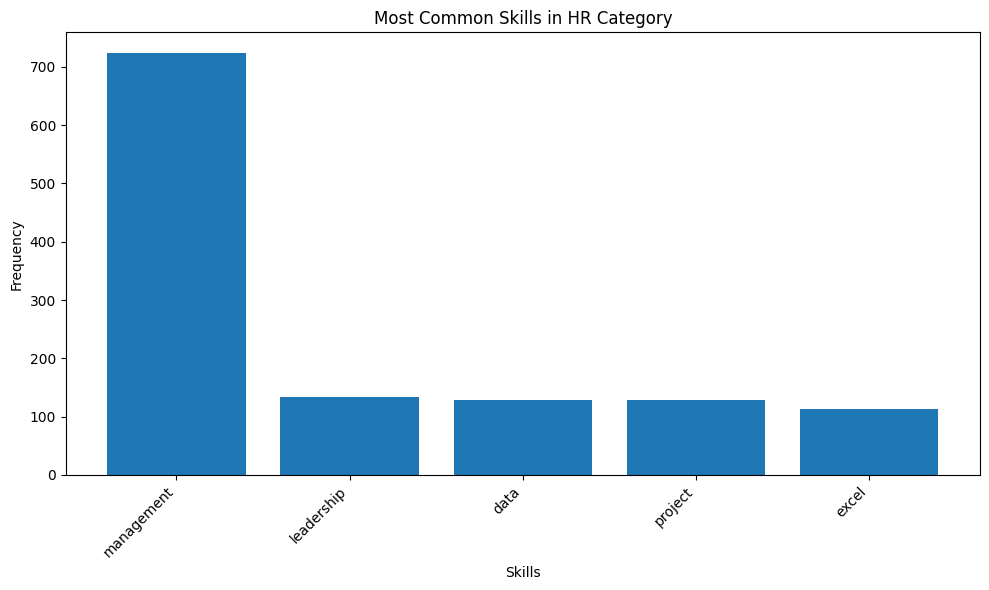

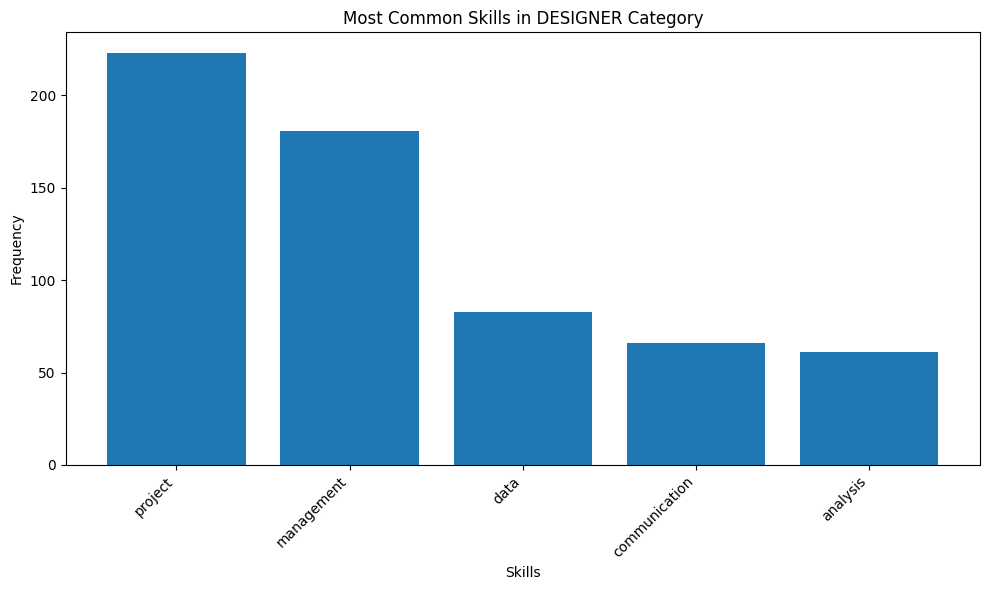

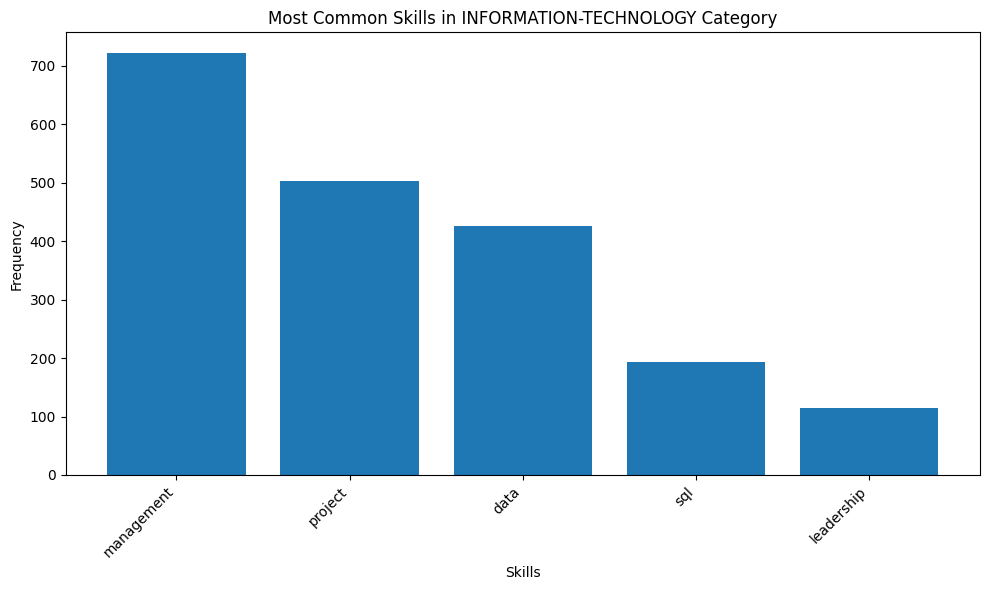

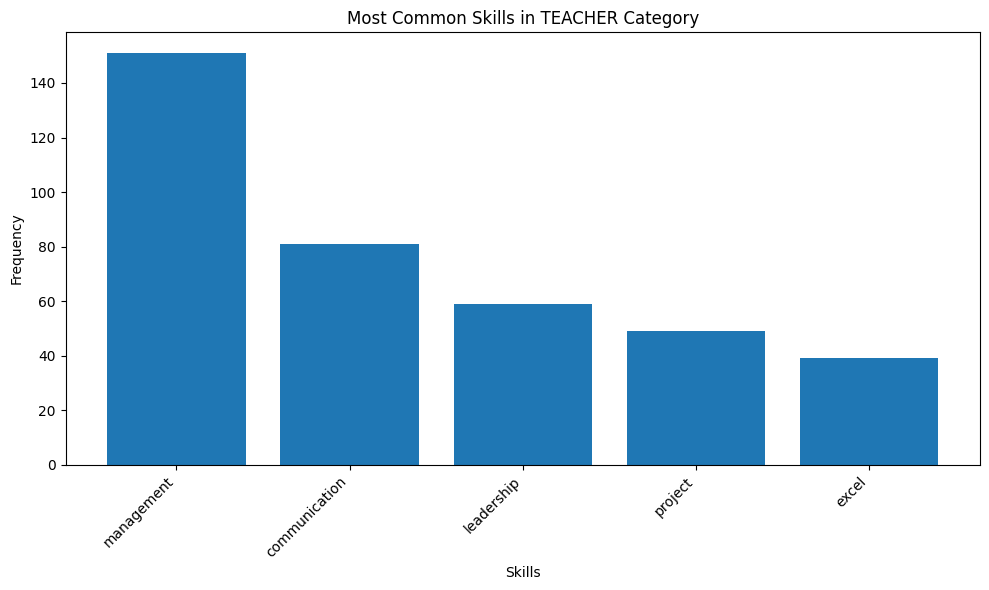

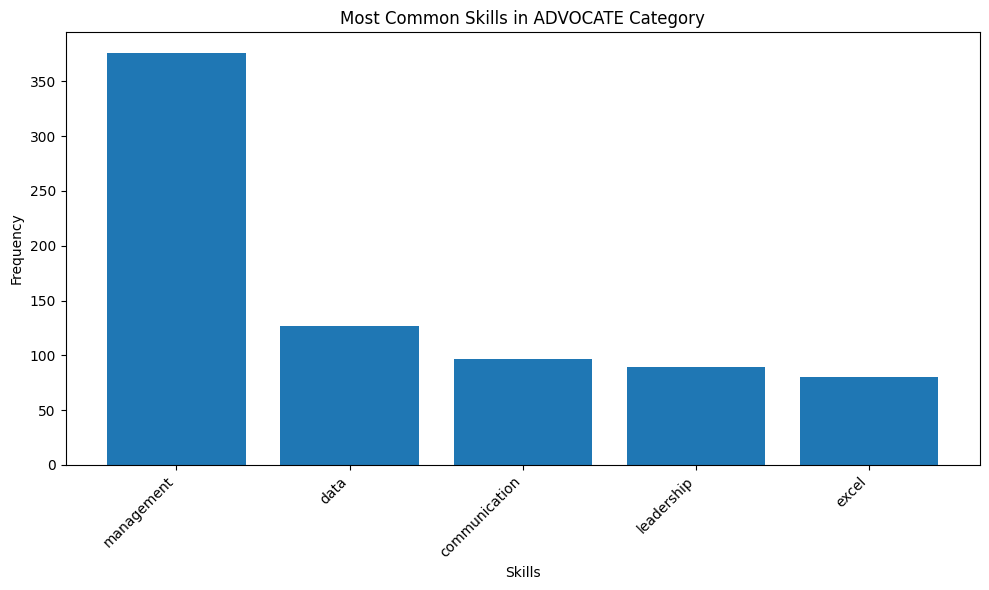

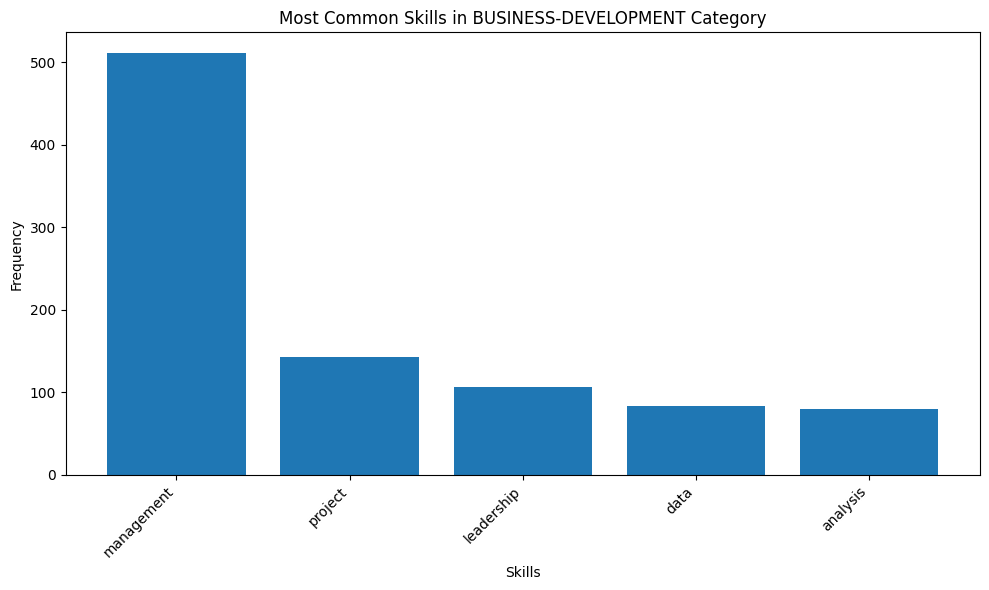

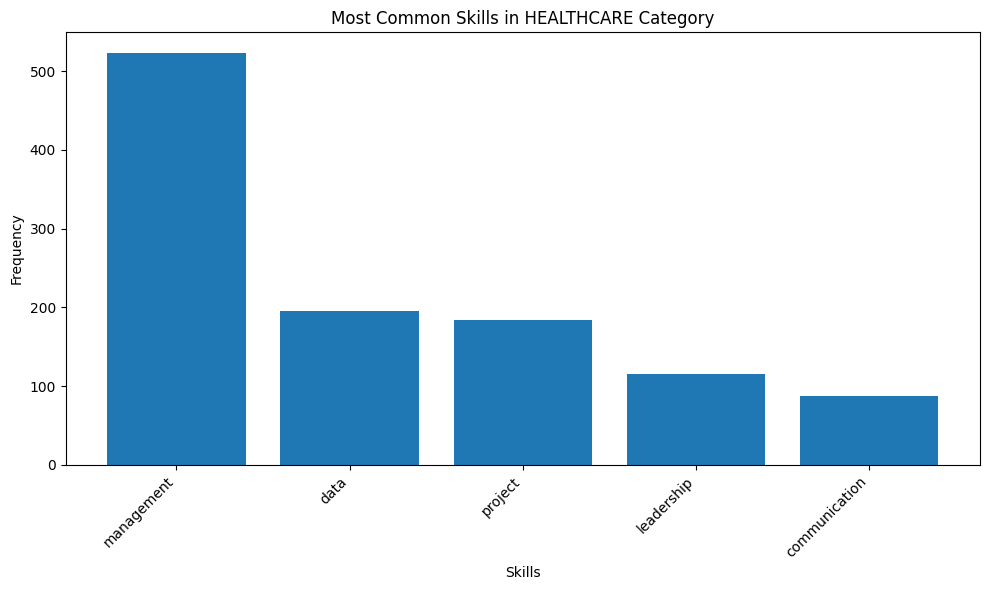

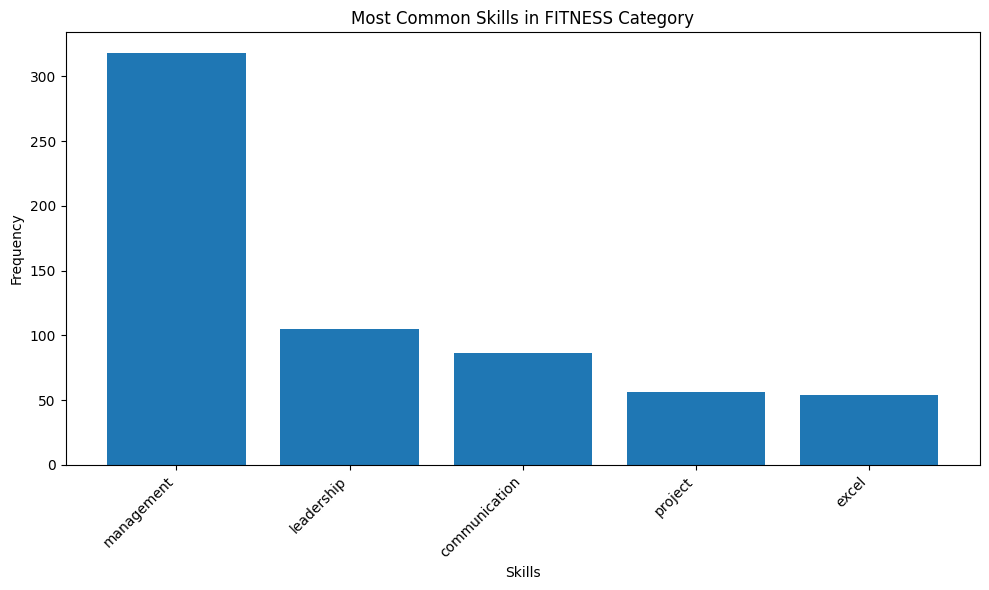

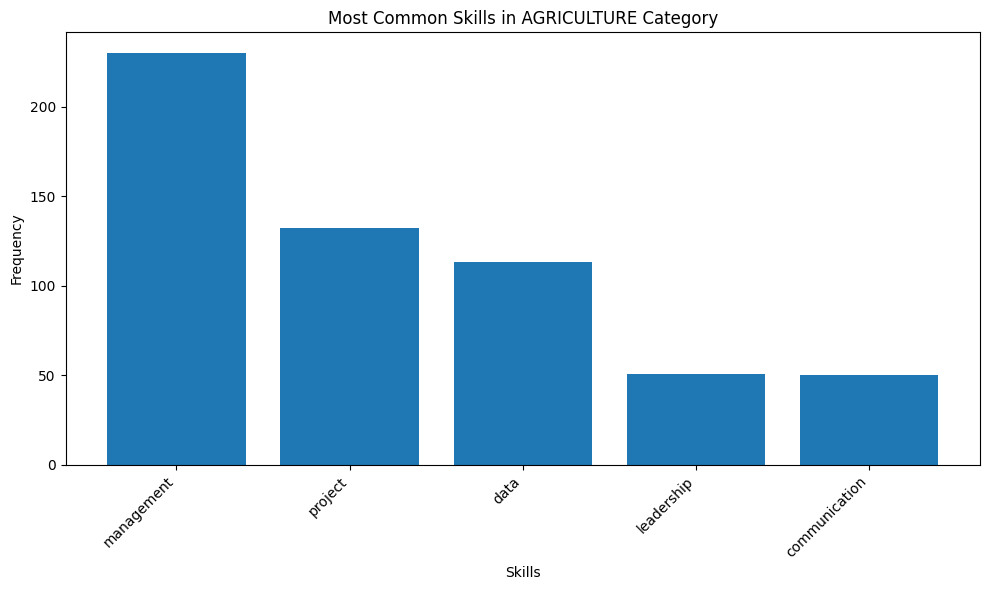

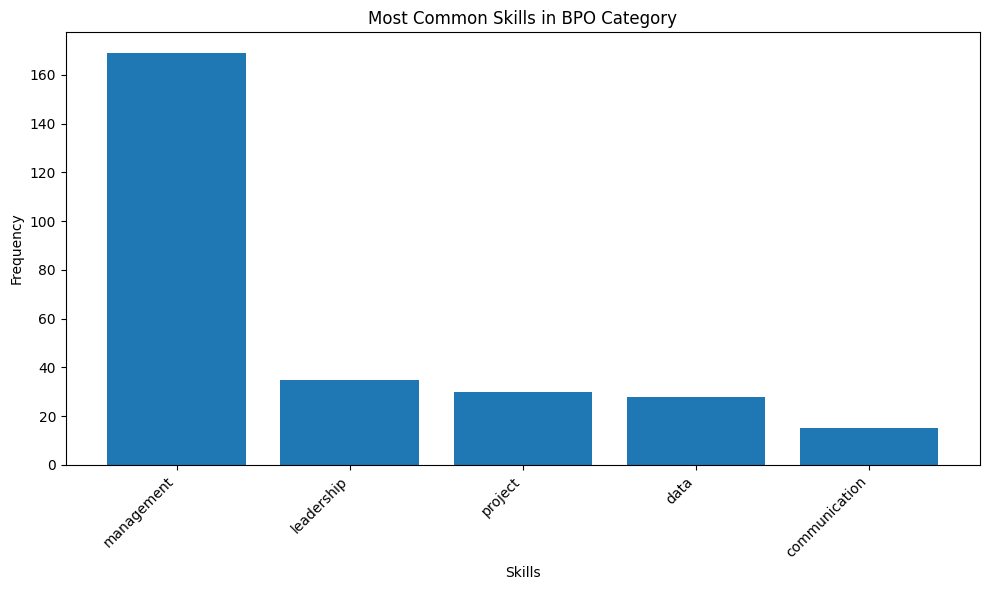

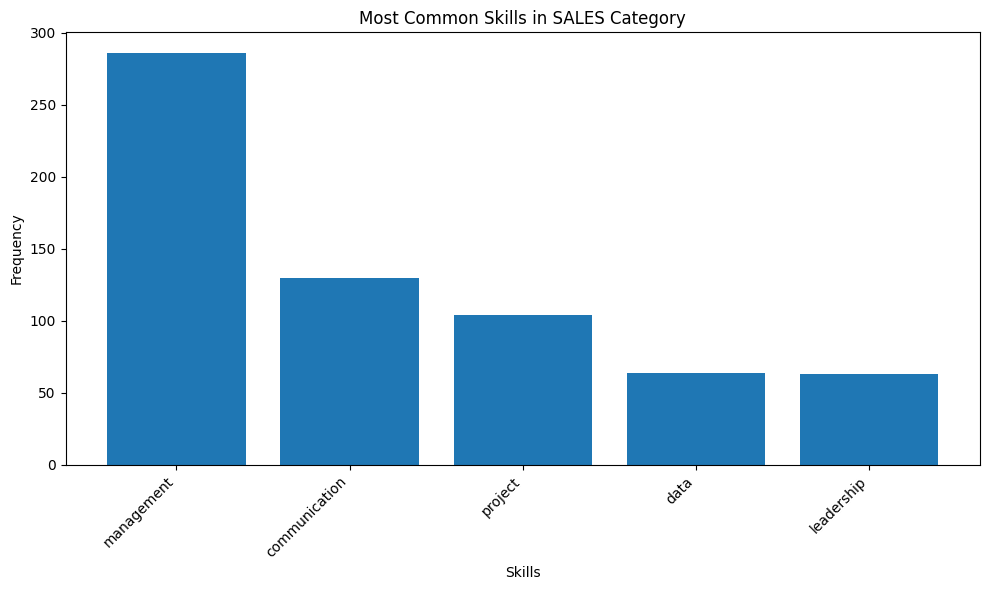

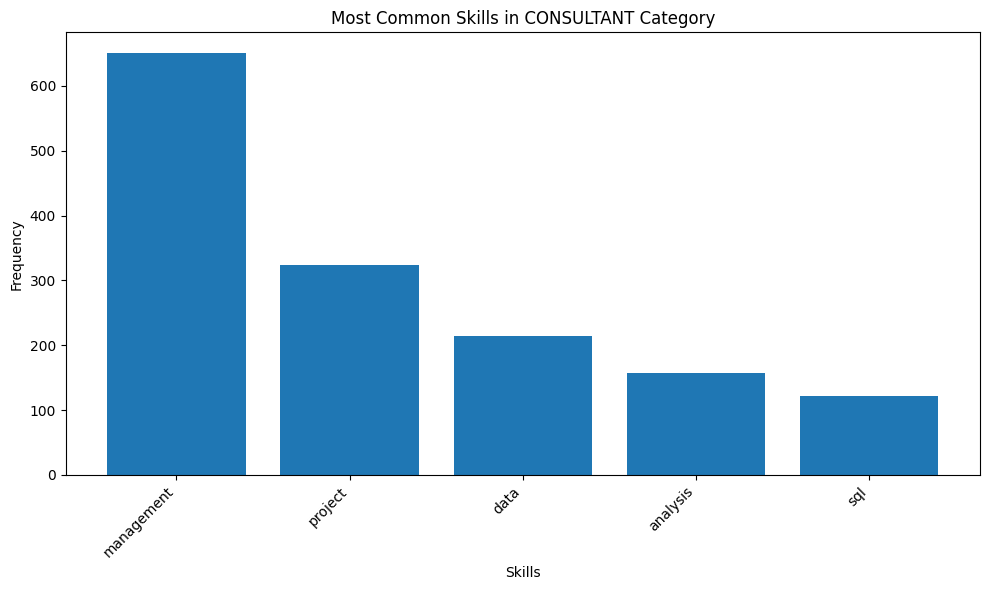

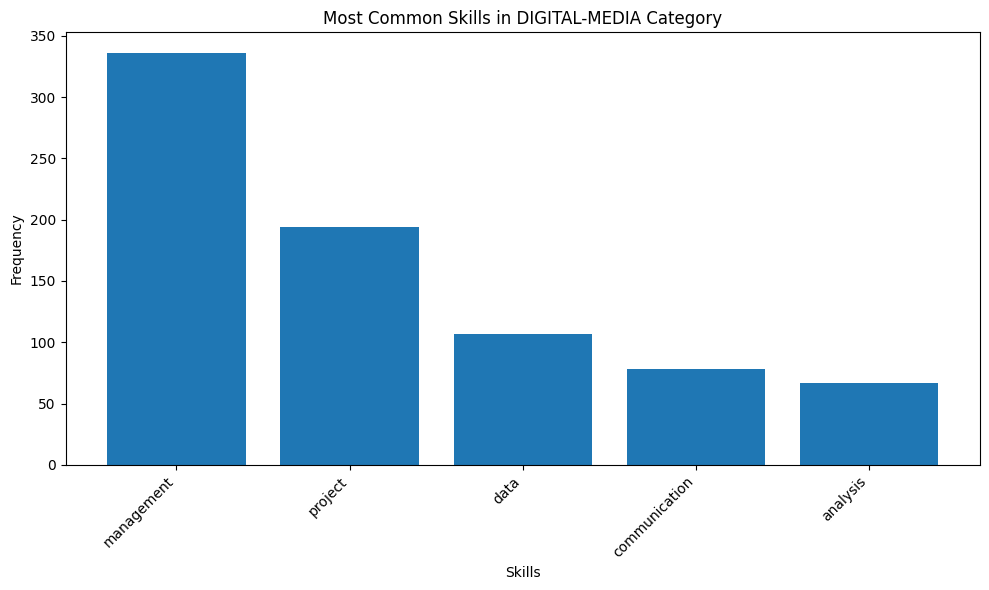

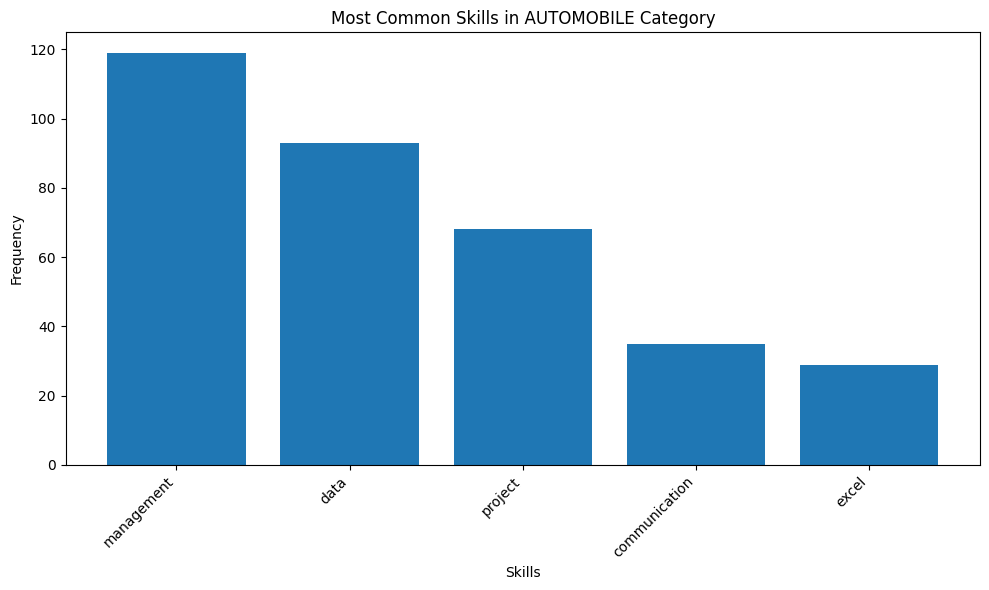

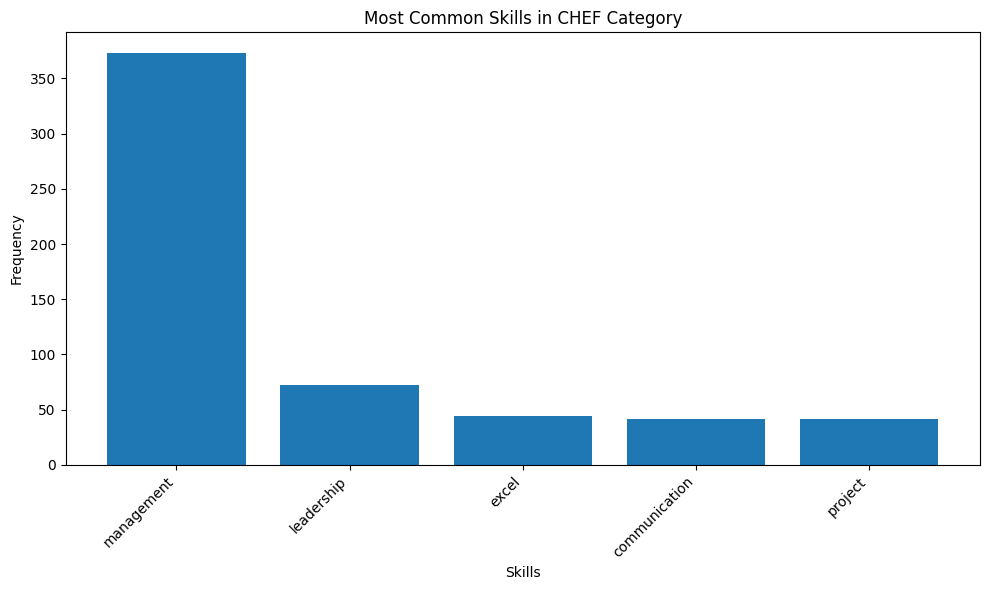

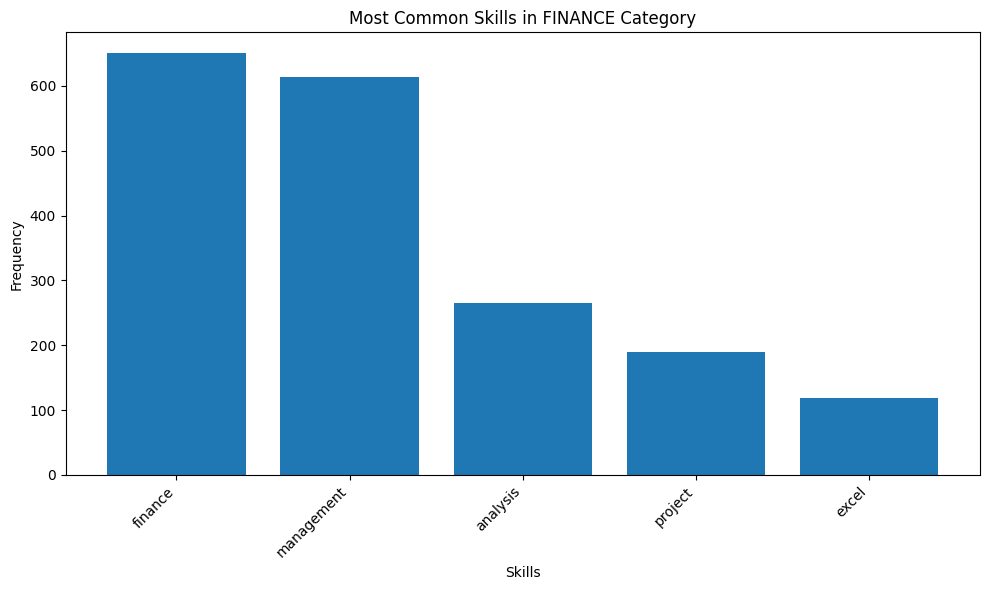

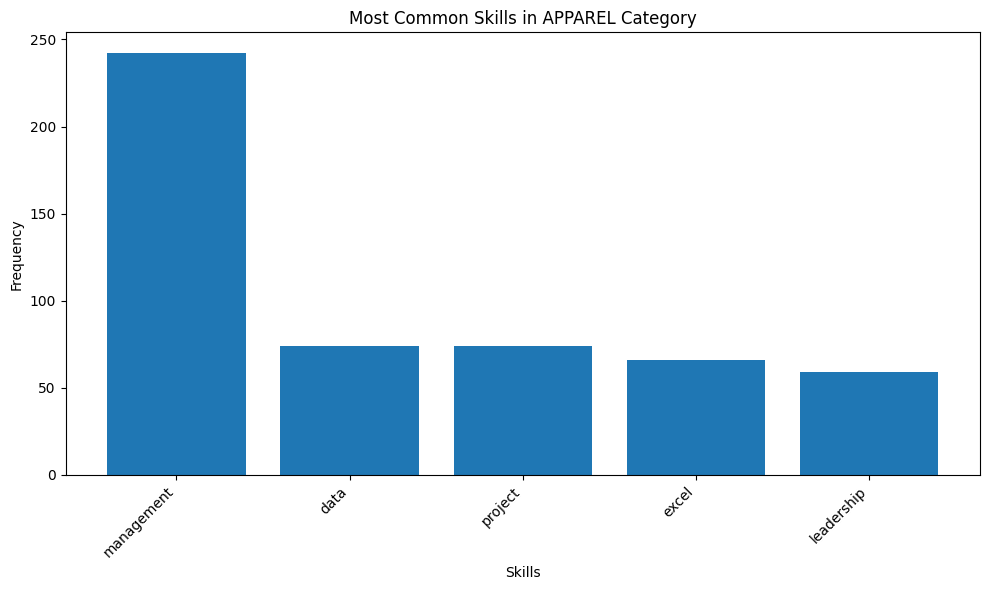

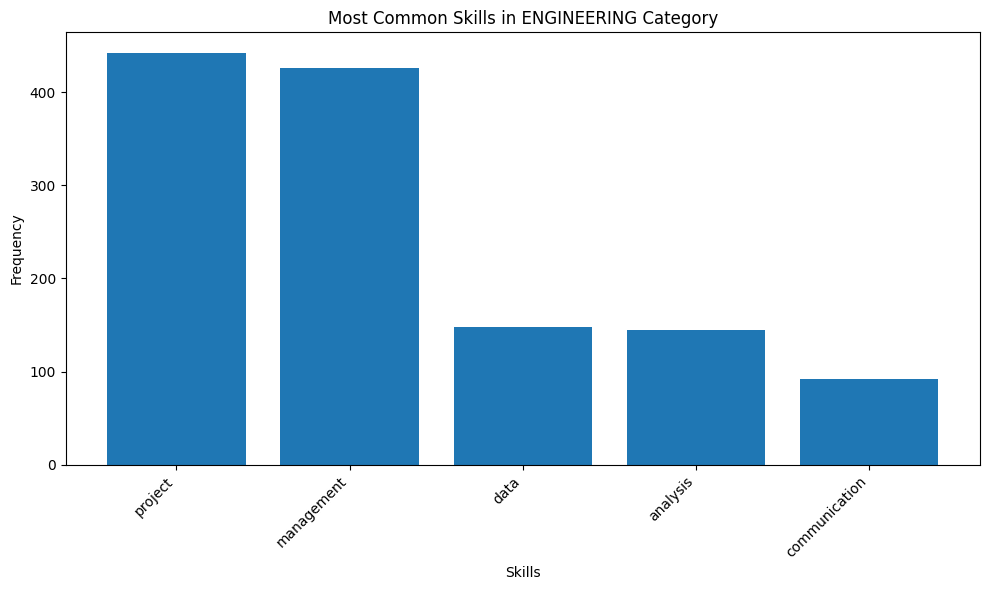

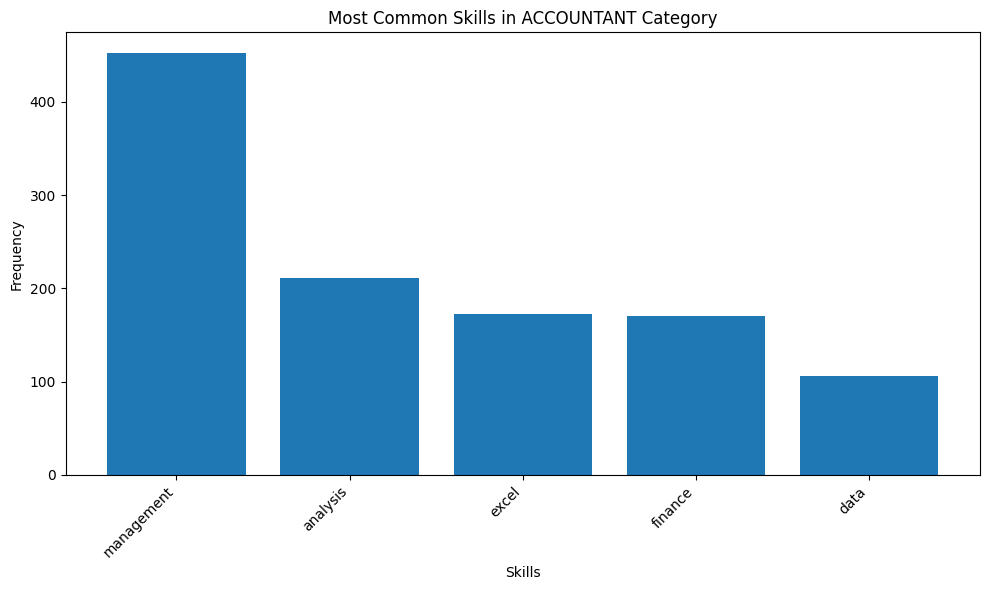

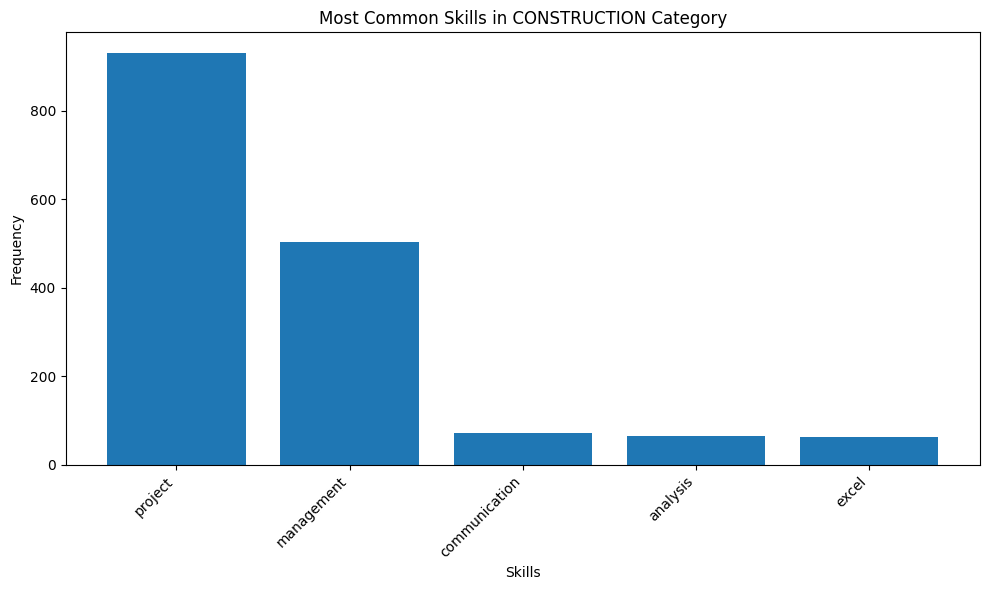

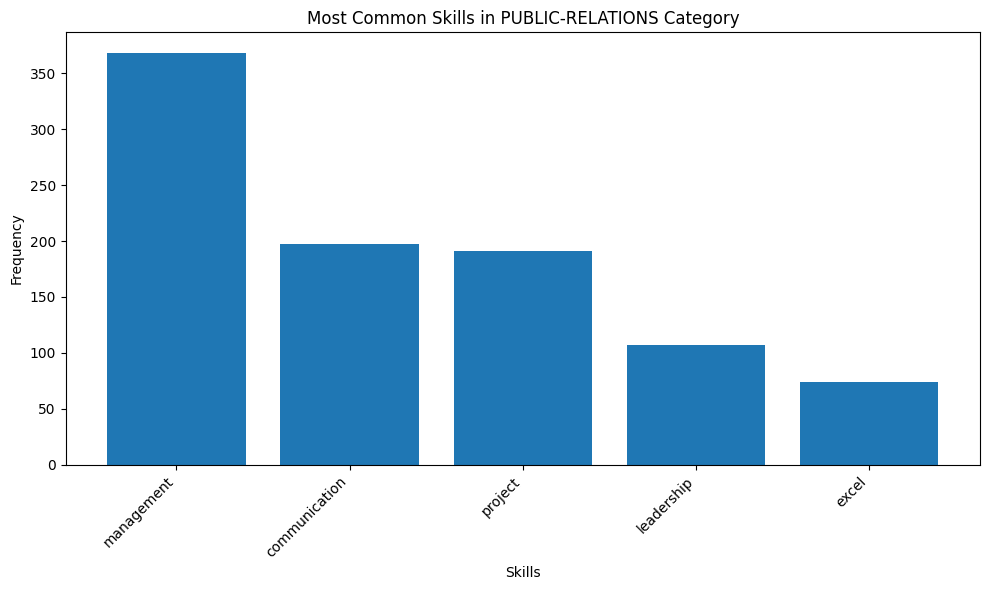

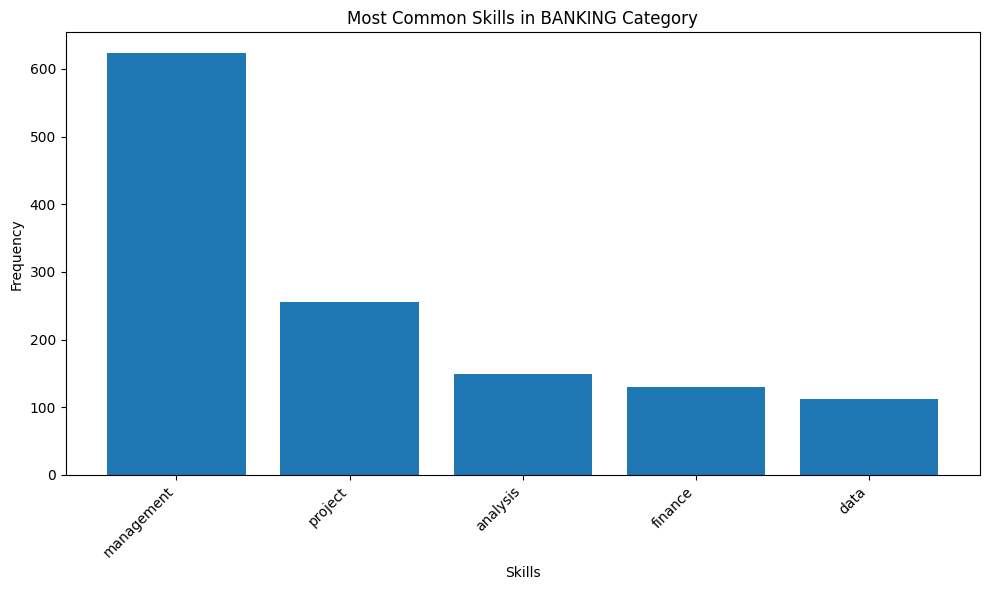

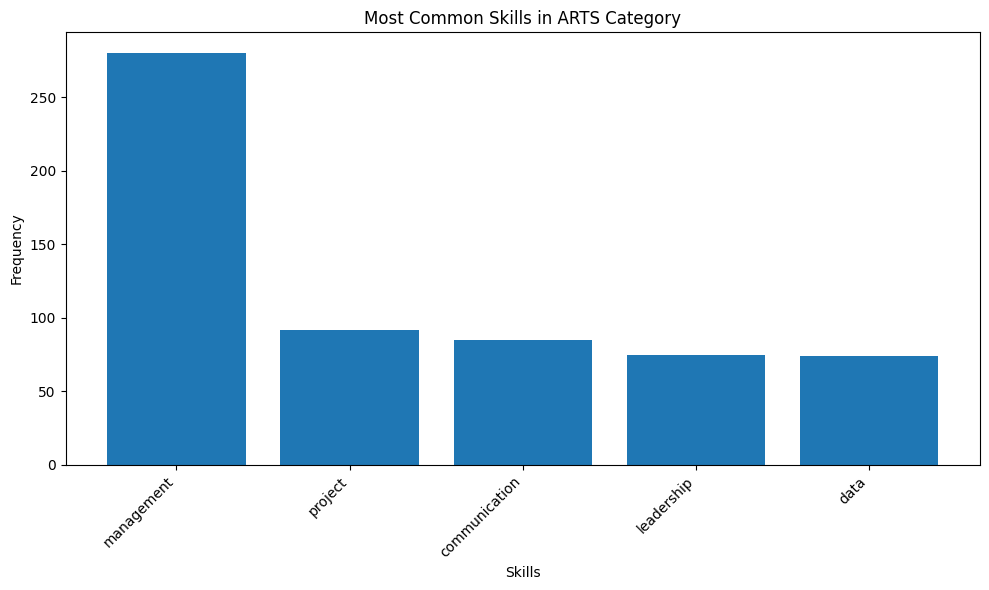

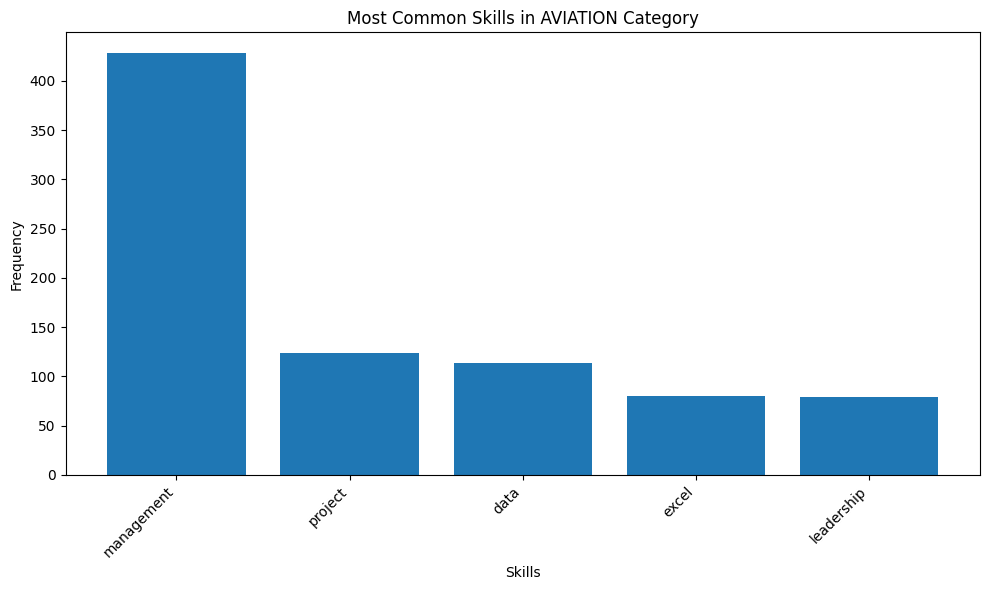

In [ ]:
import matplotlib.pyplot as plt

# Function to create a bar plot for a given category's most common skills
def plot_most_common_skills(category, skills_list):
    if not skills_list:
        print(f"No skills to plot for {category}")
        return

    skills = [skill for skill, count in skills_list]
    counts = [count for skill, count in skills_list]

    plt.figure(figsize=(10, 6))
    plt.bar(skills, counts)
    plt.xlabel("Skills")
    plt.ylabel("Frequency")
    plt.title(f"Most Common Skills in {category} Category")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Iterate through the most_common_skills_by_category dictionary and generate plots
for category, skills in most_common_skills_by_category.items():
    plot_most_common_skills(category, skills)

In [ ]:
print(keywords)

['project', 'team', 'client', 'sales', 'training', 'support', 'design']


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder

# Load the cleaned data
df = pd.read_csv('cleaned_resume.csv')

# Ensure necessary columns exist before trying to select them
# Add Category_Code if it doesn't exist
if 'Category_Code' not in df.columns:
    encoder = LabelEncoder()
    df['Category_Code'] = encoder.fit_transform(df['Category'])

# Add Skill_Count if it doesn't exist (using the expanded skills list from previous successful steps)
if 'Skill_Count' not in df.columns or df['Skill_Count'].isnull().all():
    skills = [
        # General
        'management', 'leadership', 'team', 'communication', 'excel', 'python',
        'java', 'sql', 'analysis', 'marketing', 'finance', 'agriculture',
        'project', 'design', 'data', 'sales', 'web', 'development', 'biology',
        'php', 'fitness',

        # HR
        'recruitment & talent acquisition', 'employee relations', 'hr policies','compliance',
        'payroll management', 'performance management',

        # IT
        'software development', 'troubleshooting & technical support',
        'system administration', 'cybersecurity', 'it project management',

        # Teaching
        'lesson planning', 'classroom management', 'curriculum development',
        'student assessment', 'communication & patience',

        # Legal
        'legal research', 'drafting legal documents', 'case management',
        'client counseling', 'litigation support', 'attention to detail',

        # Sales
        'sales strategy', 'market research', 'salesforce', 'negotiation',
        'relationship building',

        # Fitness
        'personal training', 'workout programming', 'nutrition guidance',
        'cpr & first aid', 'client assessment', 'motivation & coaching',

        # Agriculture
        'crop management', 'soil testing', 'farm equipment handling',
        'irrigation techniques', 'pest & disease management', 'supply chain knowledge',

        # BPO / Sales
        'customer handling', 'telecalling', 'upselling & cross-selling',
        'crm software', 'problem solving', 'communication skills',

        # Consulting
        'research & analysis', 'strategy planning', 'presentation skills',
        'data interpretation', 'client management', 'industry knowledge',

        # Digital Media
        'social media management', 'content creation', 'seo / sem',
        'analytics', 'graphic design', 'campaign management',

        # Automobile
        'vehicle diagnostics', 'repair & maintenance', 'technical inspection',
        'autocad', 'mechanical knowledge', 'quality control',

        # Chef
        'food preparation', 'menu planning', 'food safety & hygiene',
        'inventory management', 'knife skills', 'time management',

        # Finance
        'financial analysis', 'budgeting', 'taxation', 'auditing',
        'financial modeling', 'risk management',

        # Apparel / Fashion
        'textile knowledge', 'pattern making', 'garment construction',
        'cad tools', 'trend analysis',

        # Construction
        'project management', 'site supervision', 'estimation & billing',
        'safety compliance', 'material management',

        # Public Relations
        'media relations', 'press release writing', 'event management',
        'crisis communication', 'branding', 'content writing',

        # Banking
        'customer service', 'kyc compliance', 'cash handling',
        'loan processing', 'financial advisory', 'risk assessment',

        # Arts
        'creative designing', 'drawing', 'visual storytelling',
        'digital art tools', 'concept development',

        # Aviation
        'aircraft safety procedures', 'technical maintenance',
        'navigation & weather knowledge', 'emergency handling'
    ]
    def count_skills_expanded(text):
        if not isinstance(text, str):
            return 0
        text = text.lower()
        count = 0
        for skill in skills:
             # Use regex with word boundaries for more accurate matching
            pattern = r'\b' + re.escape(skill.lower()) + r'\b'
            if re.search(pattern, text):
                count += 1
        return count
    df['Skill_Count'] = df['Resume_clean'].apply(count_skills_expanded)


# Add Years_Experience if it doesn't exist or is all zeros (using the date extraction logic from cell qxs2Y1XfD5Ap)
if 'Years_Experience' not in df.columns or (df['Years_Experience'] == 0).all():
    # Re-implement experience extraction logic from cell qxs2Y1XfD5Ap
    # Assuming 'Resume_clean' is available

    # Precompile the pattern once (same as in qxs2Y1XfD5Ap)
    pattern = re.compile(
        r'(?P<Role>[A-Za-z\s]{2,50})\s*[:\-–]?\s*'
        r'(?P<Date1>\d{1,2}/\d{1,2}/\d{4})\s*(?:to|–|-)\s*'
        r'(?P<Date2>\d{1,2}/\d{1,2}/\d{4})\s*(?:at|in)\s*'
        r'(?P<Company>[A-Za-z0-9&\s]{2,60})',
        flags=re.IGNORECASE
    )

    # Apply once to all rows
    matches = df['Resume_clean'].str.extractall(pattern).reset_index()

    # Convert dates and compute duration, handling potential errors
    matches['Date1'] = pd.to_datetime(matches['Date1'], format="%d/%m/%Y", errors='coerce')
    matches['Date2'] = pd.to_datetime(matches['Date2'], format="%d/%m/%Y", errors='coerce')
    matches['Years_Experience'] = ((matches['Date2'] - matches['Date1']).dt.days / 365).round(2)

    # Group by each resume ID (level_0 is the original row index) and sum experience
    exp_df = (
        matches.groupby('level_0')['Years_Experience']
        .sum()
        .reset_index()
        .rename(columns={'Years_Experience': 'Total_Experience_Calculated'}) # Rename to avoid conflict if Years_Experience was partially extracted
    )

    # Merge back with main dataset, updating Years_Experience if it exists or creating a new column
    if 'Years_Experience' in df.columns:
         df = df.drop(columns=['Years_Experience']) # Drop existing potentially incorrect column
    df = df.merge(exp_df, left_index=True, right_on='level_0', how='left').drop(columns='level_0')
    df = df.rename(columns={'Total_Experience_Calculated': 'Years_Experience'}).fillna(0) # Rename and fill NaN with 0


# Add Keyword_Count if it doesn't exist
if 'Keyword_Count' not in df.columns:
    keywords = ['project', 'team', 'client', 'sales', 'training', 'support', 'design']
    def count_keywords(text):
        if not isinstance(text, str):
            return 0
        text = text.lower()
        return sum(text.count(word) for word in keywords)
    df['Keyword_Count'] = df['Resume_clean'].apply(count_keywords)

# Define the list of columns to save
columns_to_save = ['ID', 'Category', 'Category_Code', 'Skill_Count', 'Years_Experience', 'Keyword_Count']

# Add outlier columns if they exist in the DataFrame
for col in ['Skill_Count_Outlier', 'Years_Experience_Outlier', 'Keyword_Count_Outlier']:
    if col in df.columns:
        columns_to_save.append(col)
    else:
        print(f"Warning: Outlier column '{col}' not found in DataFrame. Skipping.")


# Save the DataFrame with the selected columns
df[columns_to_save].to_csv('resume_features.csv', index=False)

print("✅ Feature-engineered dataset saved as resume_features.csv")

✅ Feature-engineered dataset saved as resume_features.csv




### Data Analysis Key Findings

*   The average skill count varies across different resume categories. Categories like 'FINANCE' and 'INFORMATION-TECHNOLOGY' show higher average skill counts compared to others like 'CHEF' and 'TEACHER'.
*   The 'Years\_Experience' column in the dataset contained only zero values across all categories, indicating an issue with the data extraction for this specific field.
*   The distribution of skill counts across all resumes is somewhat skewed towards lower skill counts, with the majority of resumes having between 3 and 6 skills from the defined list.

### Insights or Next Steps

*   The data extraction process for 'Years\_Experience' needs to be reviewed and fixed to enable meaningful analysis and visualization of experience alongside skill counts.
*   Further analysis could investigate the specific types of skills prevalent in categories with higher average skill counts to understand the domain-specific skill requirements.

by mk


In [ ]:
import pandas as pd
import re
from datetime import datetime

# Load your data
df = pd.read_csv("cleaned_resume.csv")

# Precompile the pattern once
pattern = re.compile(
    r'(?P<Role>[A-Za-z\s]{2,50})\s*[:\-–]?\s*'
    r'(?P<Date1>\d{1,2}/\d{1,2}/\d{4})\s*(?:to|–|-)\s*'
    r'(?P<Date2>\d{1,2}/\d{1,2}/\d{4})\s*(?:at|in)\s*'
    r'(?P<Company>[A-Za-z0-9&\s]{2,60})',
    flags=re.IGNORECASE
)

# Apply once to all rows
matches = df['Resume_clean'].str.extractall(pattern).reset_index()

# Convert dates and compute duration
matches['Date1'] = pd.to_datetime(matches['Date1'], format="%d/%m/%Y", errors='coerce')
matches['Date2'] = pd.to_datetime(matches['Date2'], format="%d/%m/%Y", errors='coerce')
matches['Years_Experience'] = ((matches['Date2'] - matches['Date1']).dt.days / 365).round(2)

# Group by each resume ID (level_0 is the original row index)
exp_df = (
    matches.groupby('level_0')['Years_Experience']
    .sum()
    .reset_index()
    .rename(columns={'Years_Experience': 'Total_Experience'})
)

# Merge back with main dataset
df = df.merge(exp_df, left_index=True, right_on='level_0', how='left').drop(columns='level_0')

print("✅ Fast experience extraction complete!")
df[['ID','Category','Total_Experience']].head()

✅ Fast experience extraction complete!


ID Category  Total_Experience
0  16852973       HR               NaN
1  22323967       HR               NaN
2  33176873       HR               NaN
3  27018550       HR               NaN
4  17812897       HR               NaN

from matplotlib import pyplot as plt
_df_2['ID'].plot(kind='hist', bins=20, title='ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['ID'].plot(kind='line', figsize=(8, 4), title='ID')
plt.gca().spines[['top', 'right']].set_visible(False)

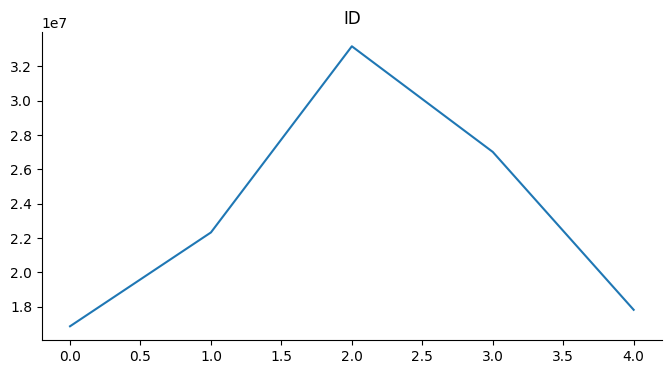

In [ ]:
from matplotlib import pyplot as plt
_df_3['ID'].plot(kind='line', figsize=(8, 4), title='ID')
plt.gca().spines[['top', 'right']].set_visible(False)

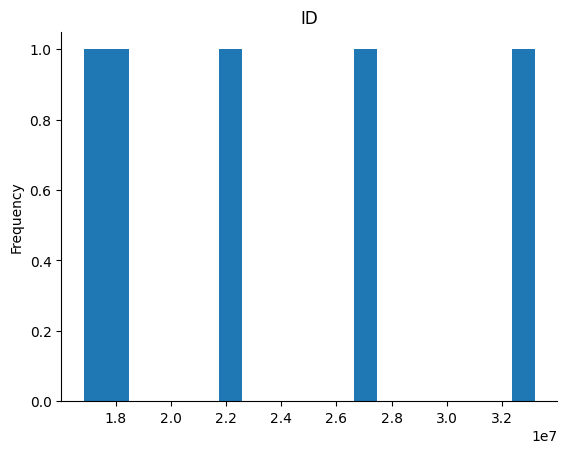

In [ ]:
from matplotlib import pyplot as plt
_df_2['ID'].plot(kind='hist', bins=20, title='ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


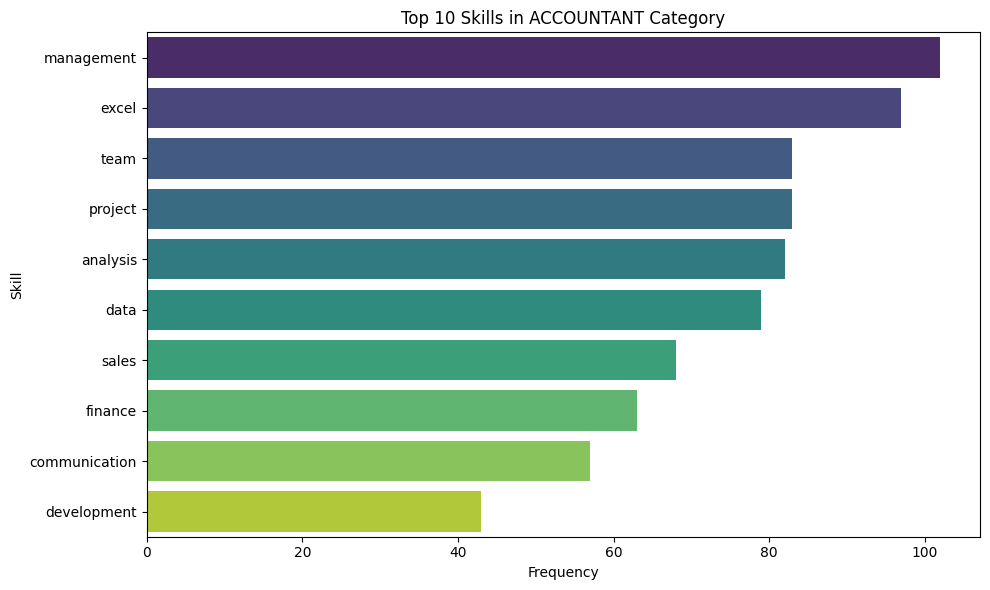

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


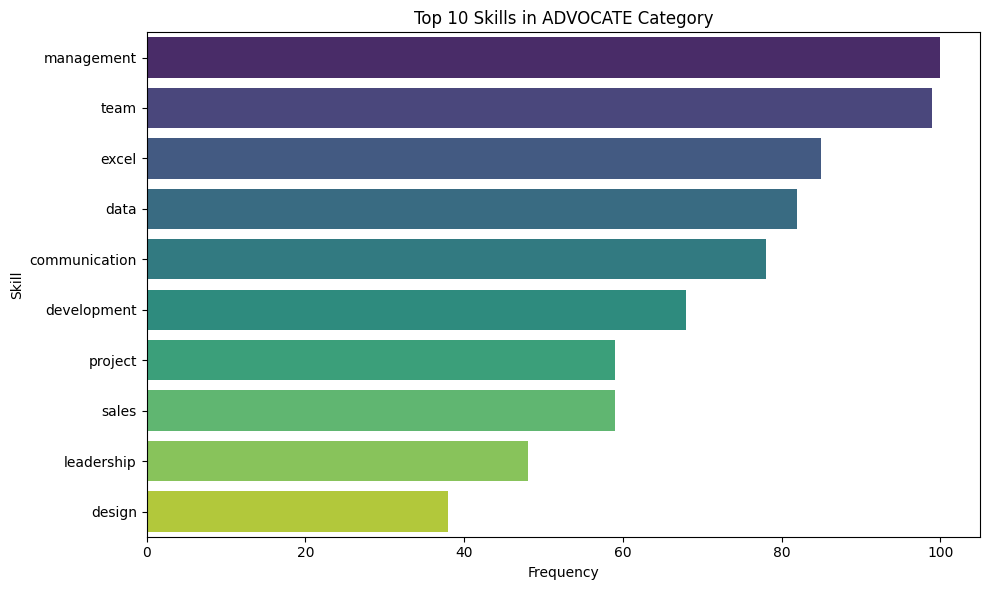

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


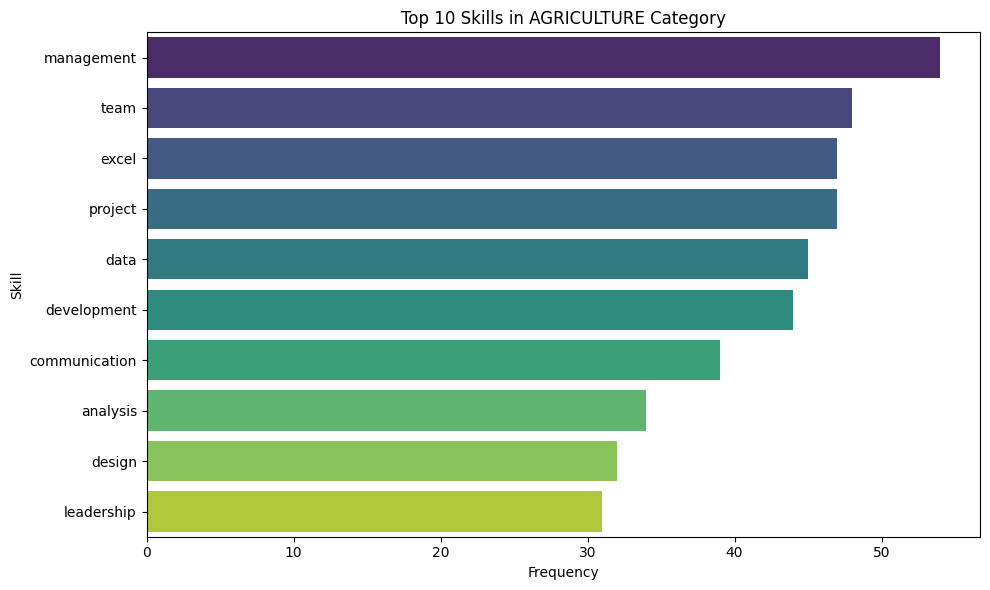

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


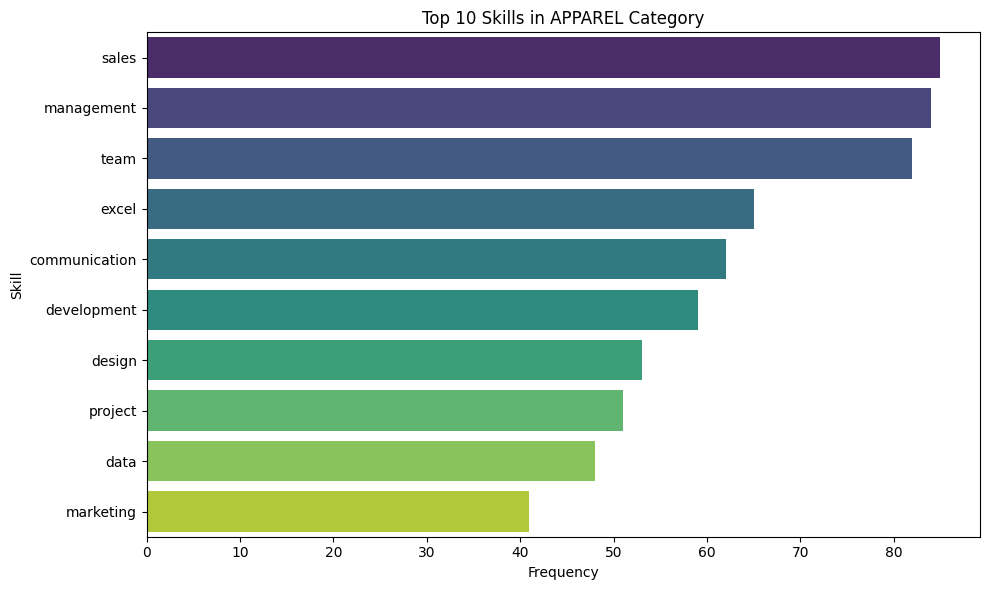

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


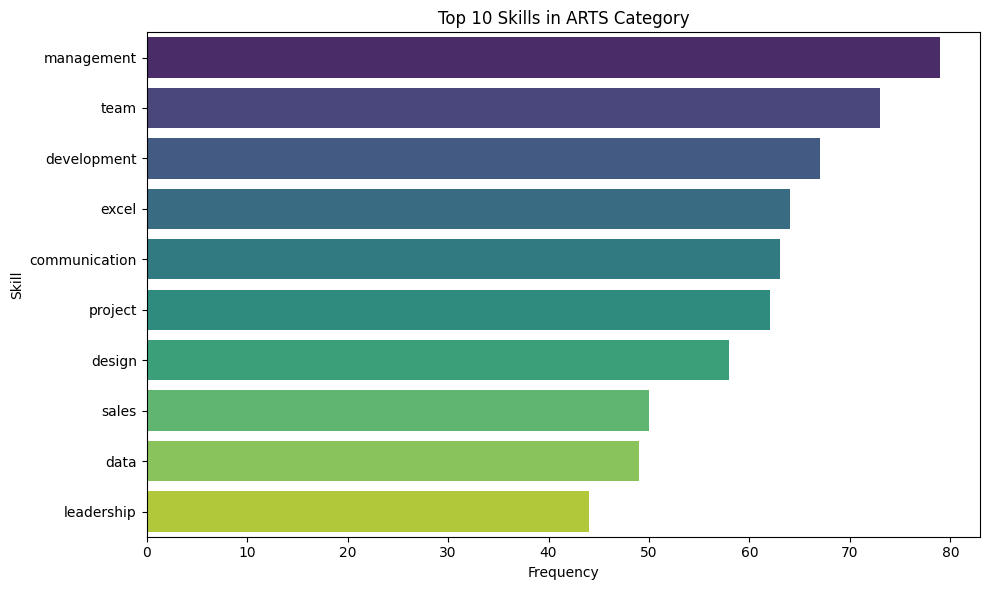

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


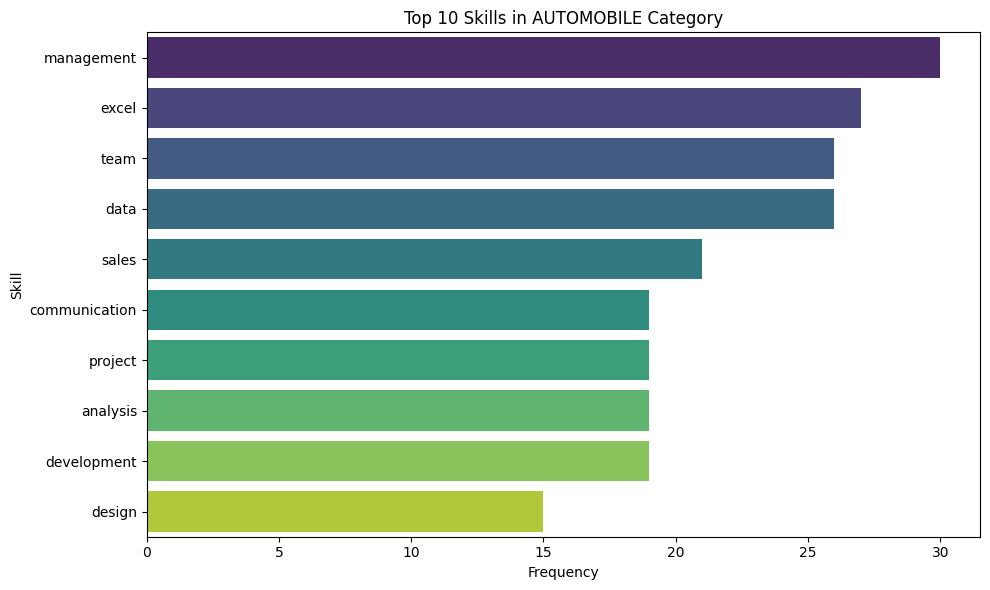

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


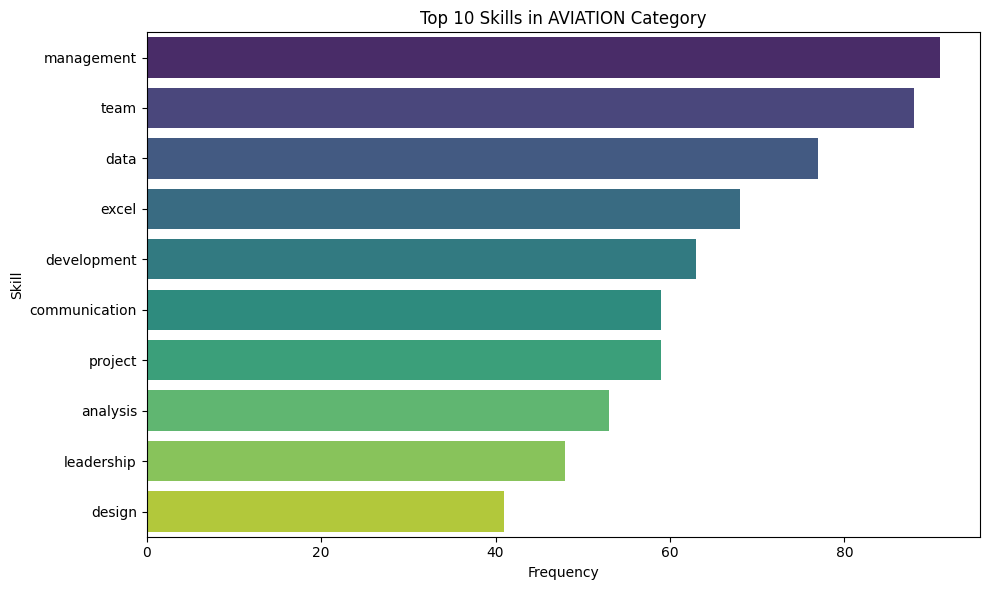

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


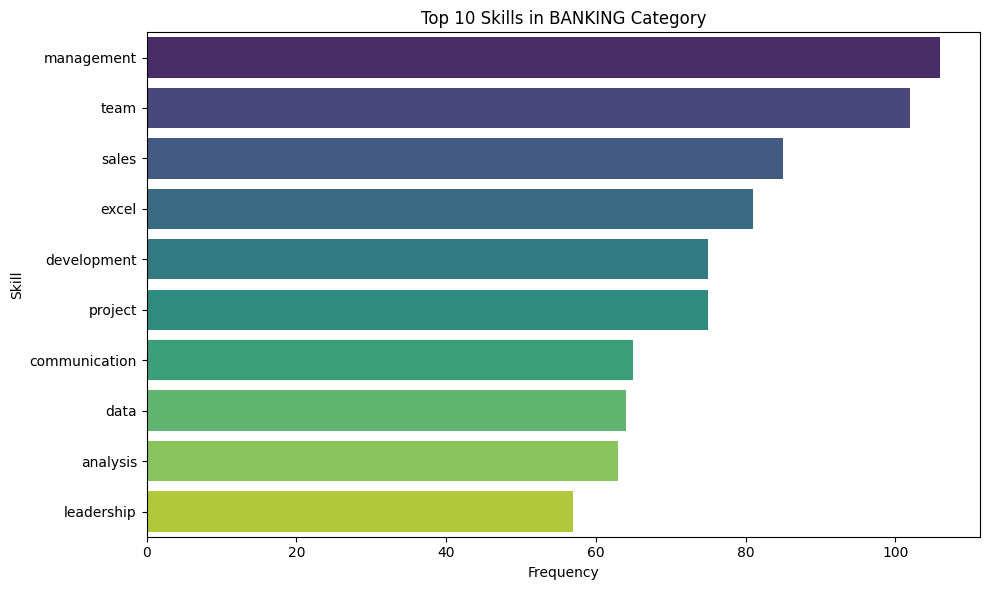

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


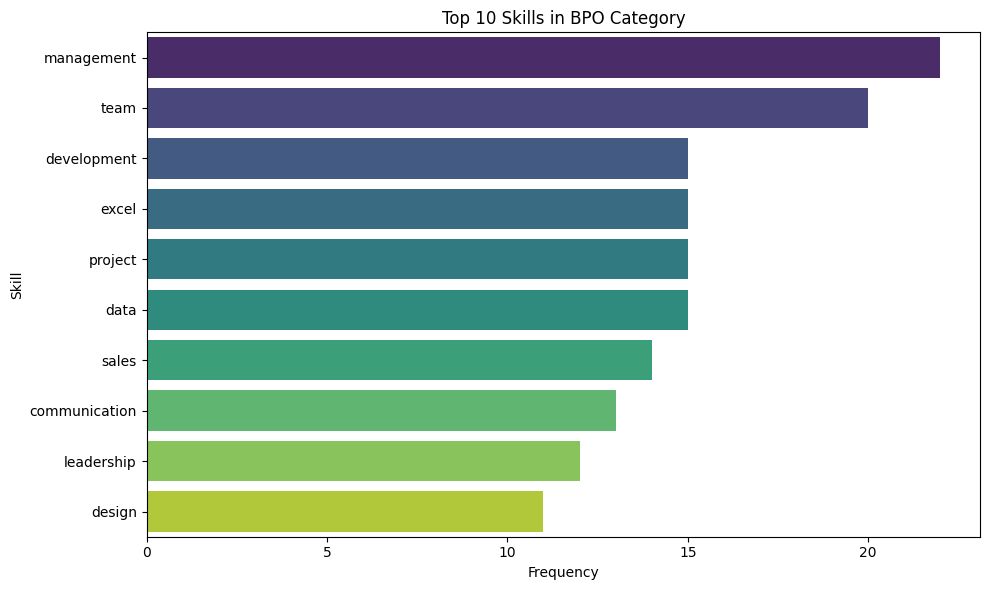

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


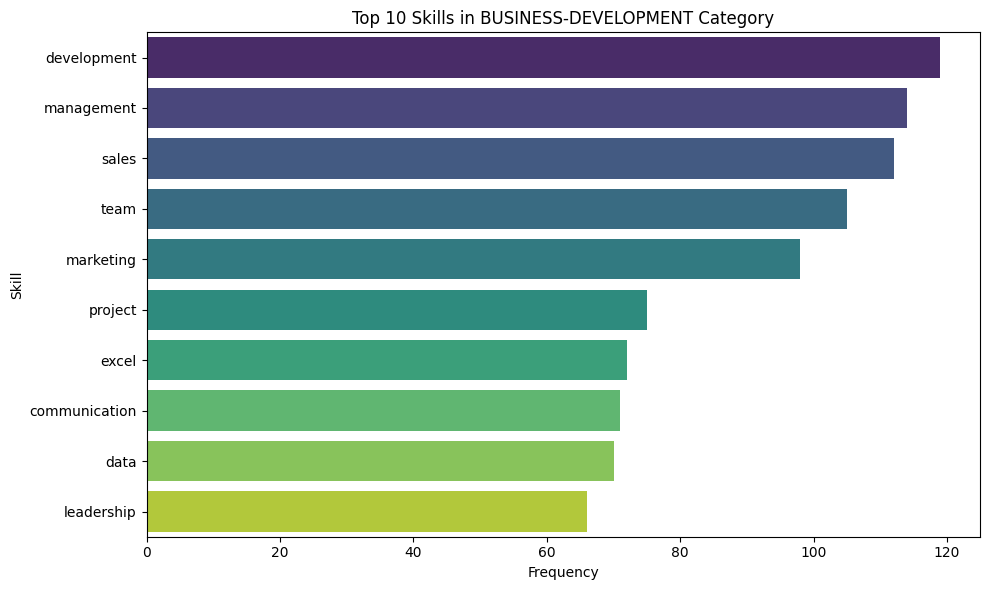

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


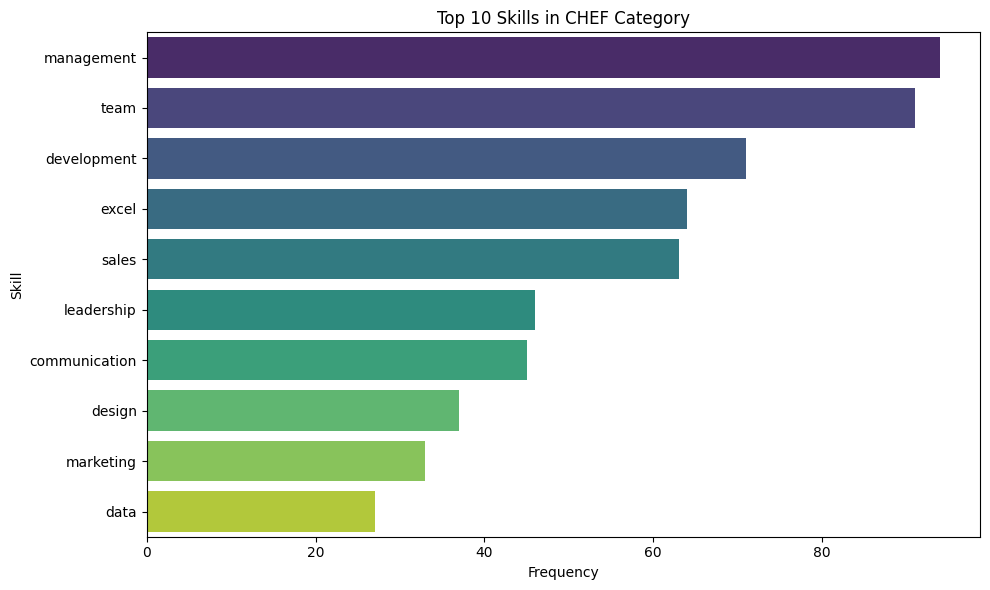

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


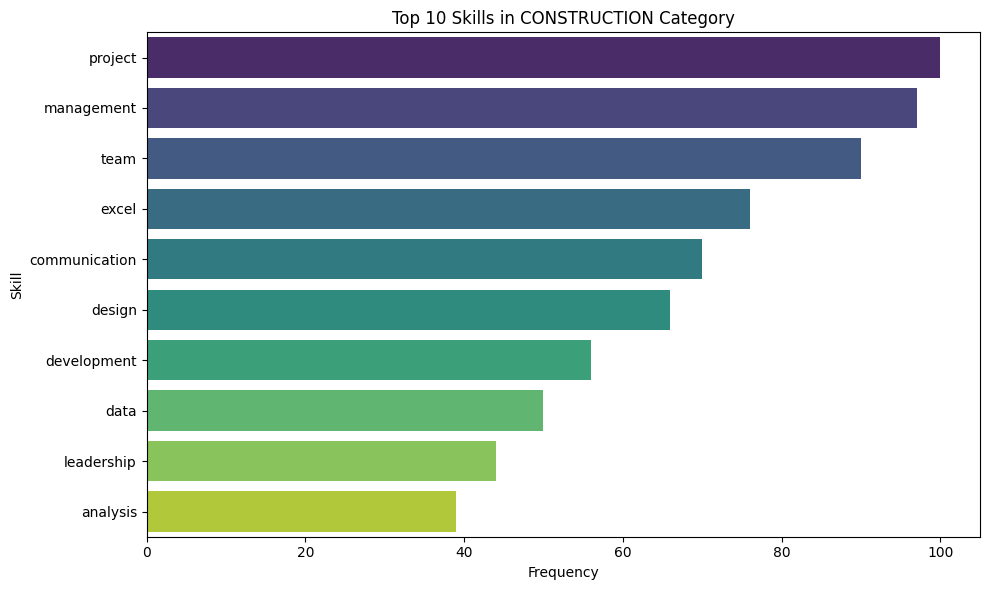

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


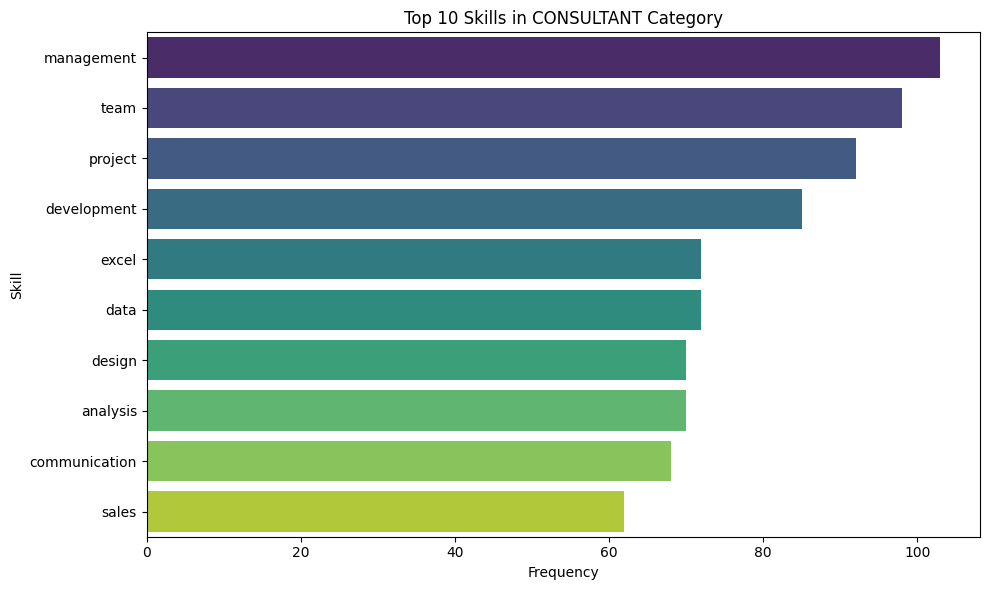

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


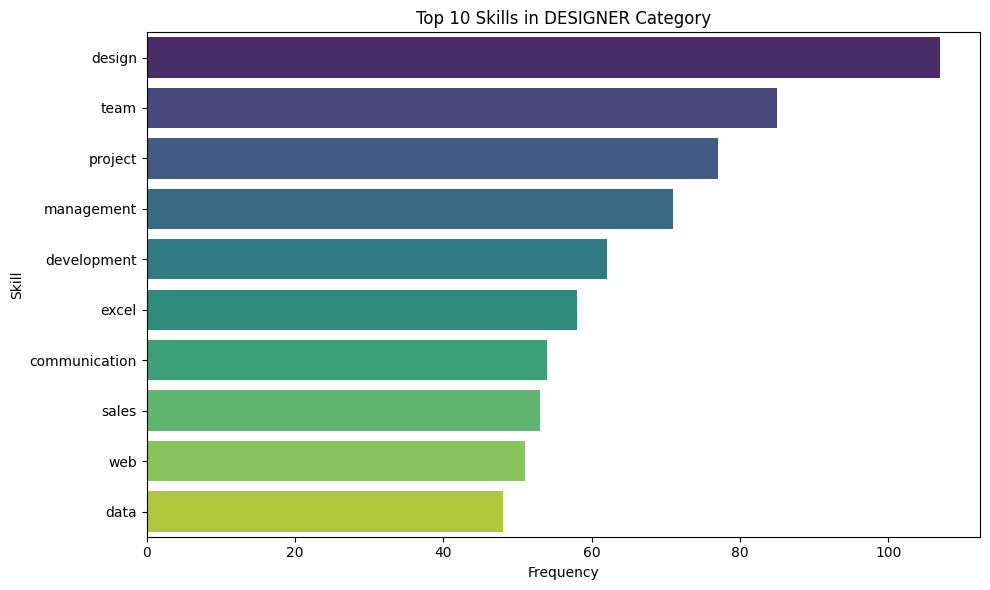

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


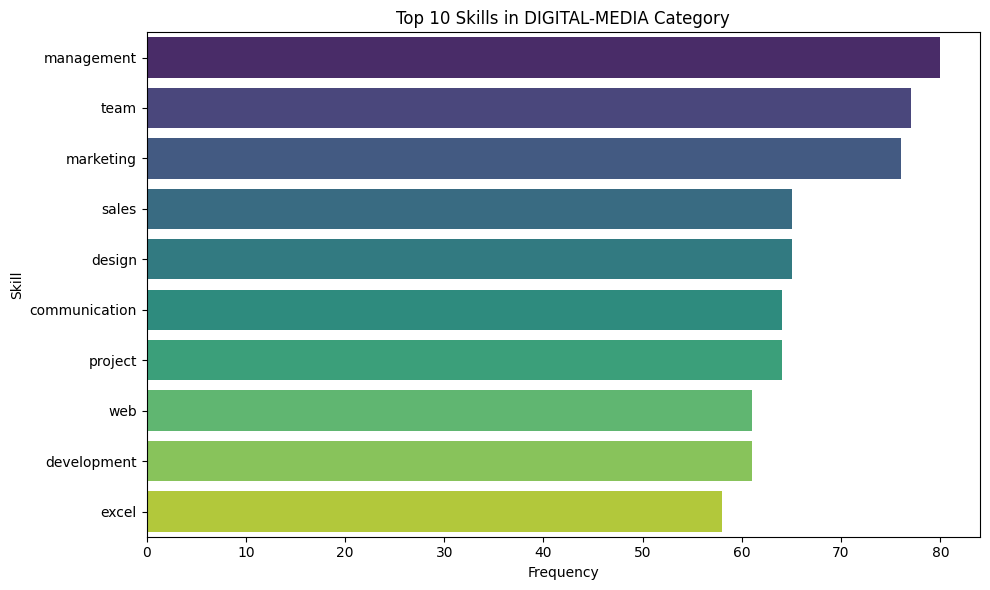

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


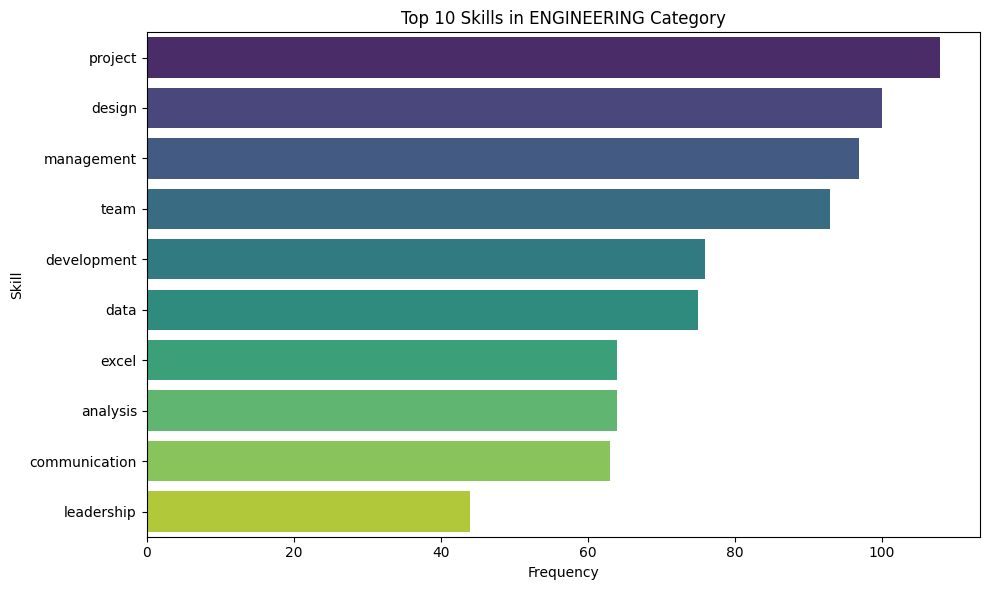

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


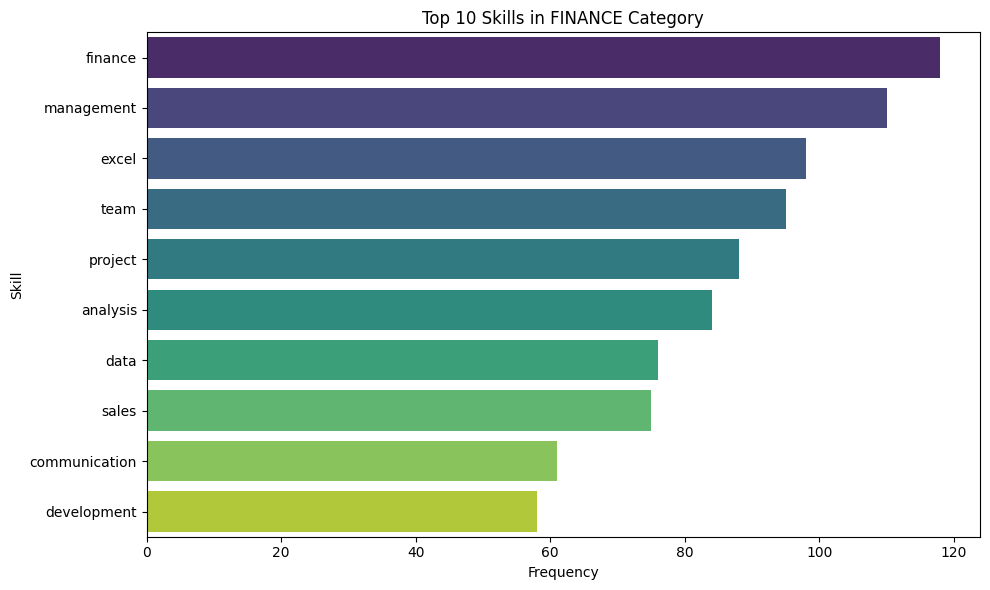

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


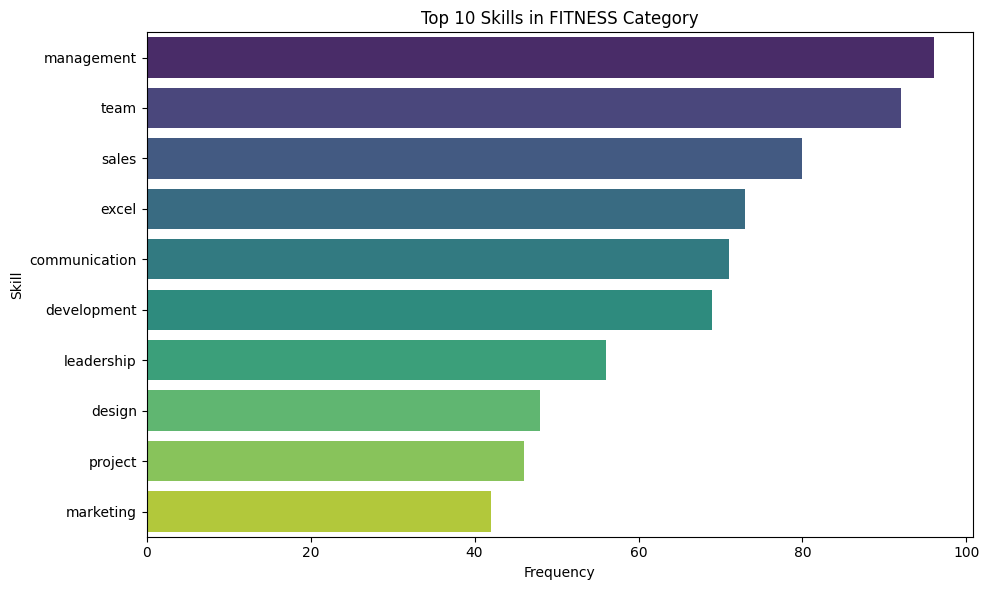

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


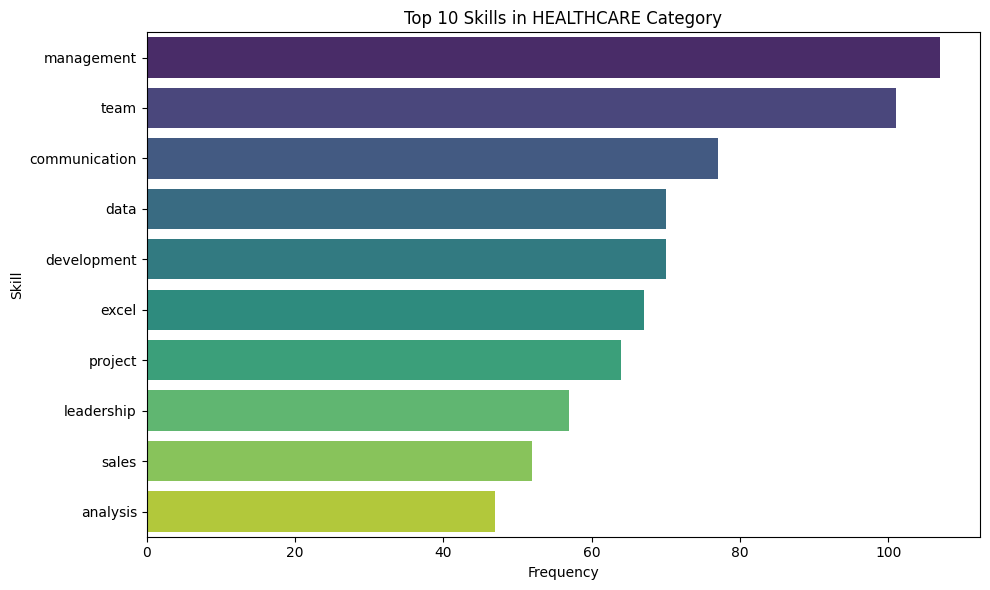

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


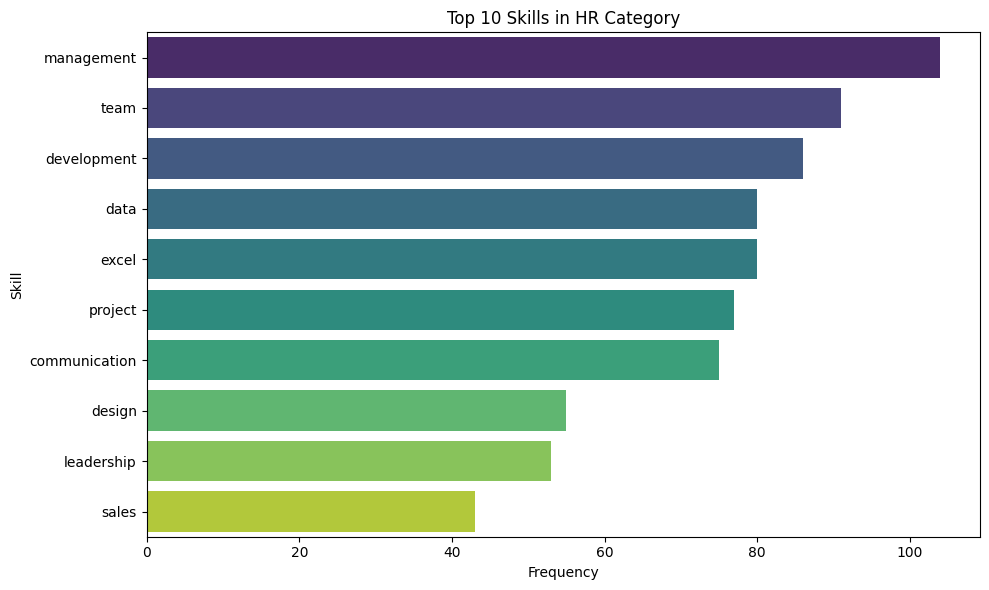

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


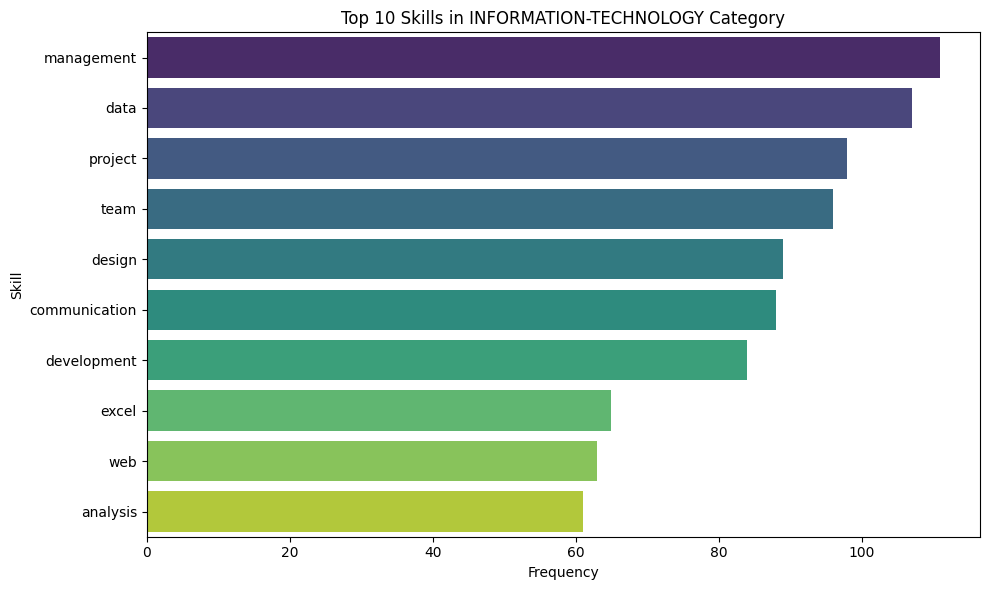

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


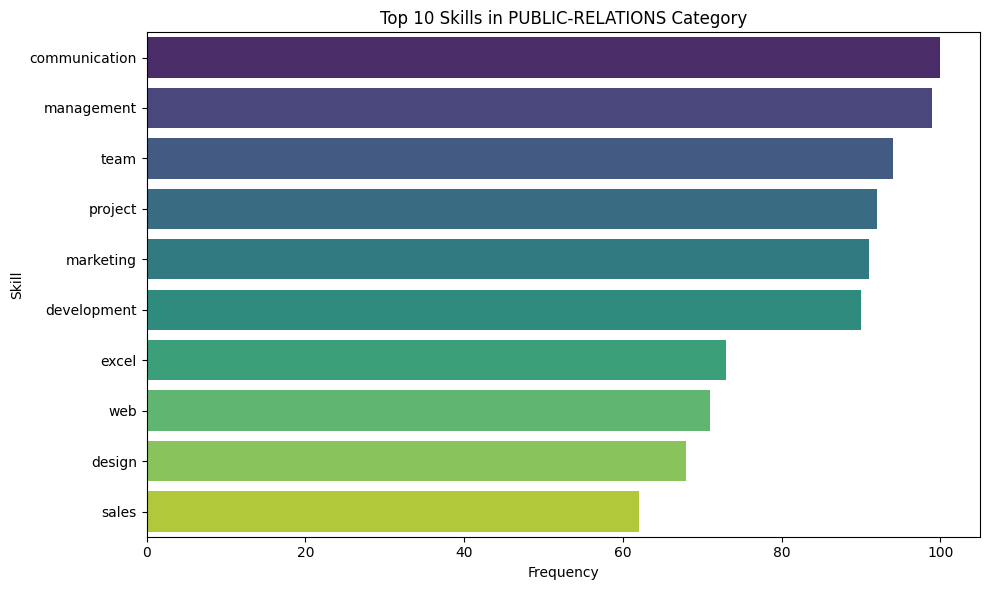

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


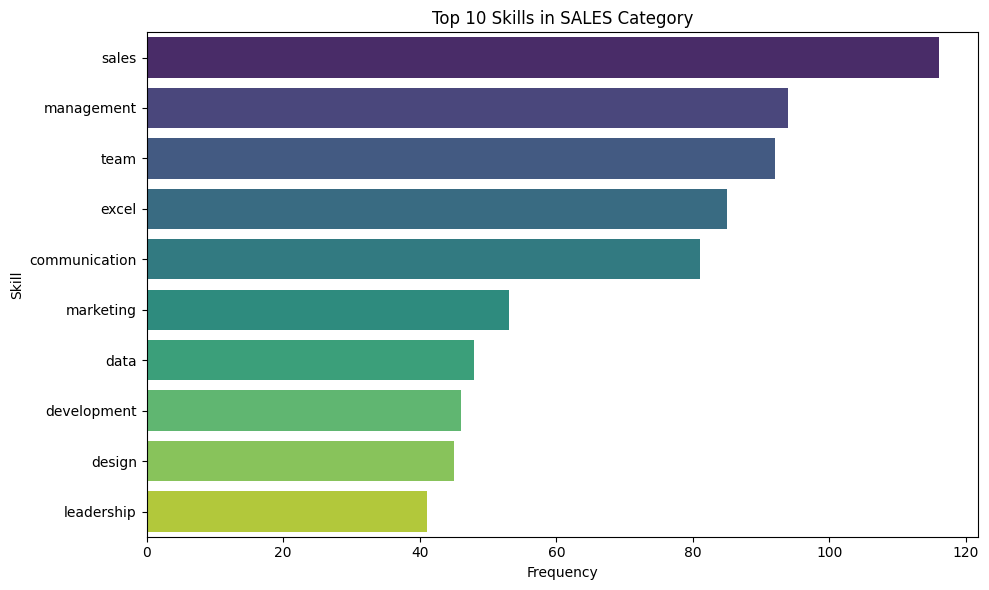

/tmp/ipython-input-1977794540.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')


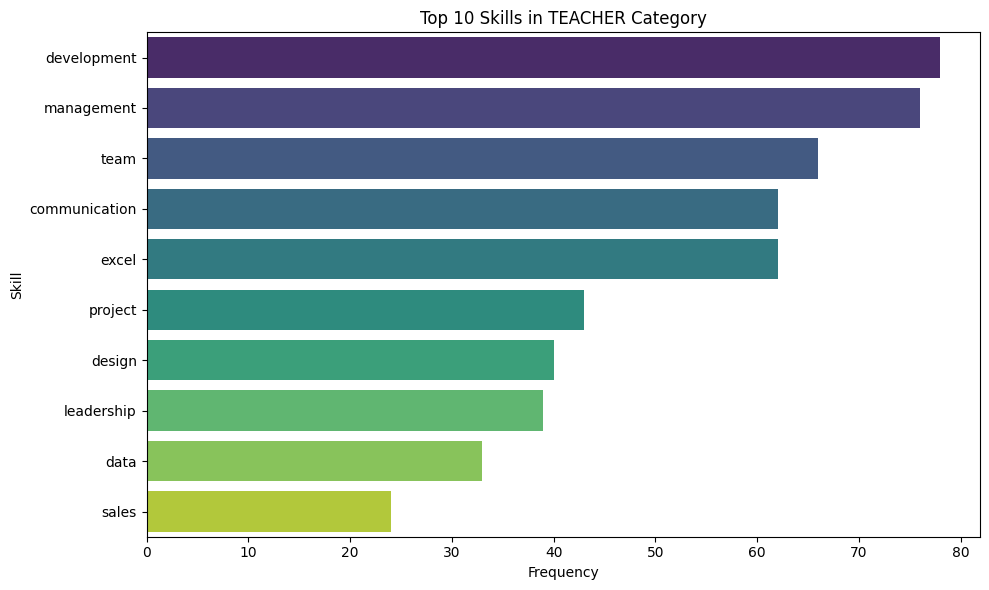

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique categories
categories = top_skills_df['Category'].unique()

# Create a plot for each category
for category in categories:
    # Filter data for the current category
    category_data = top_skills_df[top_skills_df['Category'] == category]

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Skill', data=category_data, palette='viridis')
    plt.title(f'Top 10 Skills in {category} Category')
    plt.xlabel('Frequency')
    plt.ylabel('Skill')
    plt.tight_layout()
    plt.show()

In [ ]:
skills = [
    # General
    'management', 'leadership', 'team', 'communication', 'excel', 'python',
    'java', 'sql', 'analysis', 'marketing', 'finance', 'agriculture',
    'project', 'design', 'data', 'sales', 'web', 'development', 'biology',
    'php', 'fitness',

    # HR
    'recruitment & talent acquisition', 'employee relations', 'hr policies','compliance',
    'payroll management', 'performance management',

    # IT
    'software development', 'troubleshooting & technical support',
    'system administration', 'cybersecurity', 'it project management',

    # Teaching
    'lesson planning', 'classroom management', 'curriculum development',
    'student assessment', 'communication & patience',

    # Legal
    'legal research', 'drafting legal documents', 'case management',
    'client counseling', 'litigation support', 'attention to detail',

    # Sales
    'sales strategy', 'market research', 'salesforce', 'negotiation',
    'relationship building',

    # Fitness
    'personal training', 'workout programming', 'nutrition guidance',
    'cpr & first aid', 'client assessment', 'motivation & coaching',

    # Agriculture
    'crop management', 'soil testing', 'farm equipment handling',
    'irrigation techniques', 'pest & disease management', 'supply chain knowledge',

    # BPO / Sales
    'customer handling', 'telecalling', 'upselling & cross-selling',
    'crm software', 'problem solving', 'communication skills',

    # Consulting
    'research & analysis', 'strategy planning', 'presentation skills',
    'data interpretation', 'client management', 'industry knowledge',

    # Digital Media
    'social media management', 'content creation', 'seo / sem',
    'analytics', 'graphic design', 'campaign management',

    # Automobile
    'vehicle diagnostics', 'repair & maintenance', 'technical inspection',
    'autocad', 'mechanical knowledge', 'quality control',

    # Chef
    'food preparation', 'menu planning', 'food safety & hygiene',
    'inventory management', 'knife skills', 'time management',

    # Finance
    'financial analysis', 'budgeting', 'taxation', 'auditing',
    'financial modeling', 'risk management',

    # Apparel / Fashion
    'textile knowledge', 'pattern making', 'garment construction',
    'cad tools', 'trend analysis',

    # Construction
    'project management', 'site supervision', 'estimation & billing',
    'safety compliance', 'material management',

    # Public Relations
    'media relations', 'press release writing', 'event management',
    'crisis communication', 'branding', 'content writing',

    # Banking
    'customer service', 'kyc compliance', 'cash handling',
    'loan processing', 'financial advisory', 'risk assessment',

    # Arts
    'creative designing', 'drawing', 'visual storytelling',
    'digital art tools', 'concept development',

    # Aviation
    'aircraft safety procedures', 'technical maintenance',
    'navigation & weather knowledge', 'emergency handling'
]


In [ ]:
from collections import Counter

# Combine all skill lists from the 'Skills_Found' column
all_skills = [skill for skills_list in df['Skills_Found'].dropna() for skill in skills_list]

# Count the occurrences of each skill
skill_counts = Counter(all_skills)

# Get the most common skills (e.g., top 10)
most_common_skills = skill_counts.most_common(10)

# Get the least common skills (e.g., bottom 10)
# Filter for skills that appeared at least once
least_common_skills = skill_counts.most_common()[:-11:-1]

print("Most common skills expected in the next resume:")
for skill, count in most_common_skills:
    print(f"- {skill}: {count}")

print("\nLeast common skills expected in the next resume:")
for skill, count in least_common_skills:
    print(f"- {skill}: {count}")

Most common skills expected in the next resume:
- management: 2112
- team: 1857
- development: 1519
- sales: 1307
- communication: 1265
- project: 1187
- data: 1165
- leadership: 1004
- analysis: 1004
- customer service: 957

Least common skills expected in the next resume:
- drafting legal documents: 1
- client counseling: 1
- visual storytelling: 2
- technical maintenance: 2
- financial advisory: 2
- student assessment: 2
- content writing: 2
- site supervision: 3
- loan processing: 3
- data interpretation: 4


In [ ]:
import re

def extract_skills(text):
    text = str(text).lower()
    found = []
    for s in skills:
        # Escape special characters like "&", "/", etc.
        pattern = r'\b' + re.escape(s.lower()) + r'\b'
        if re.search(pattern, text):
            found.append(s)
    return found


/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




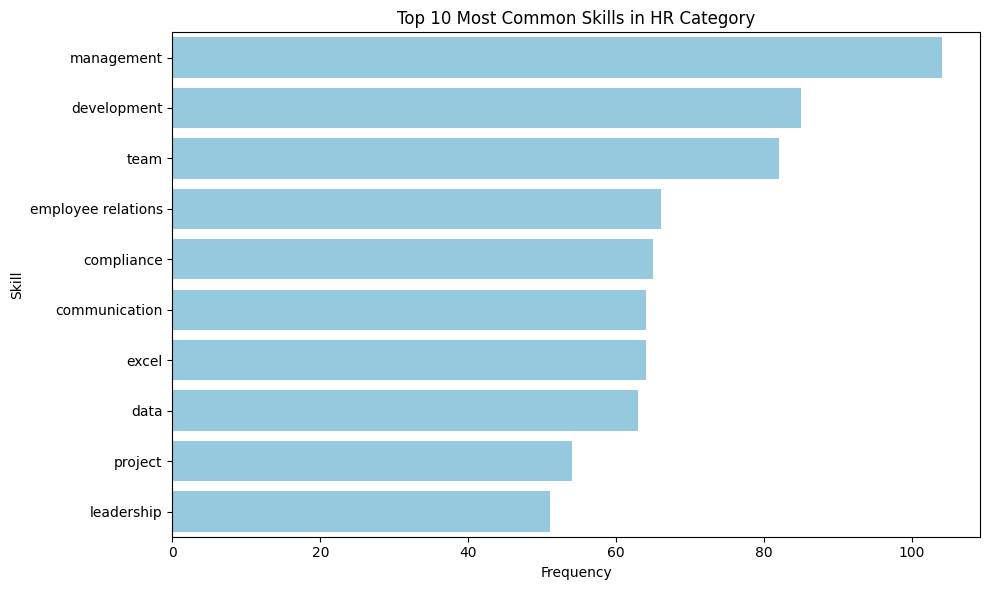

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




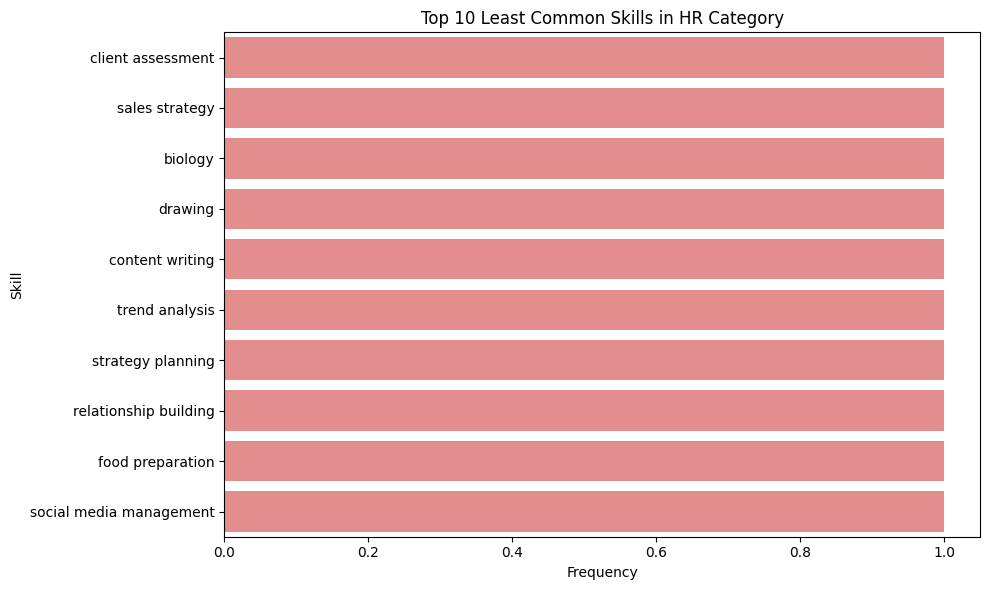

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




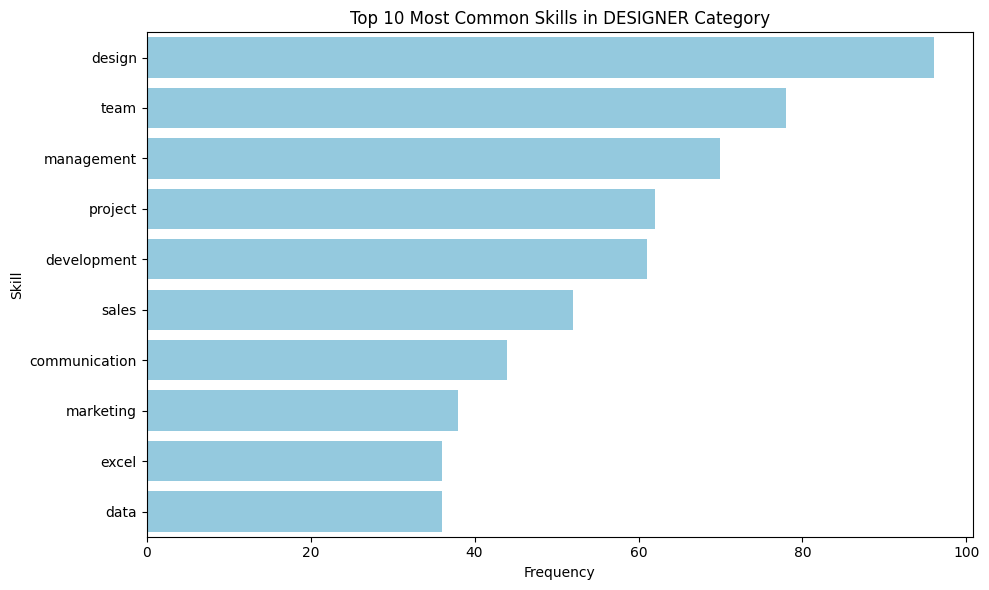

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




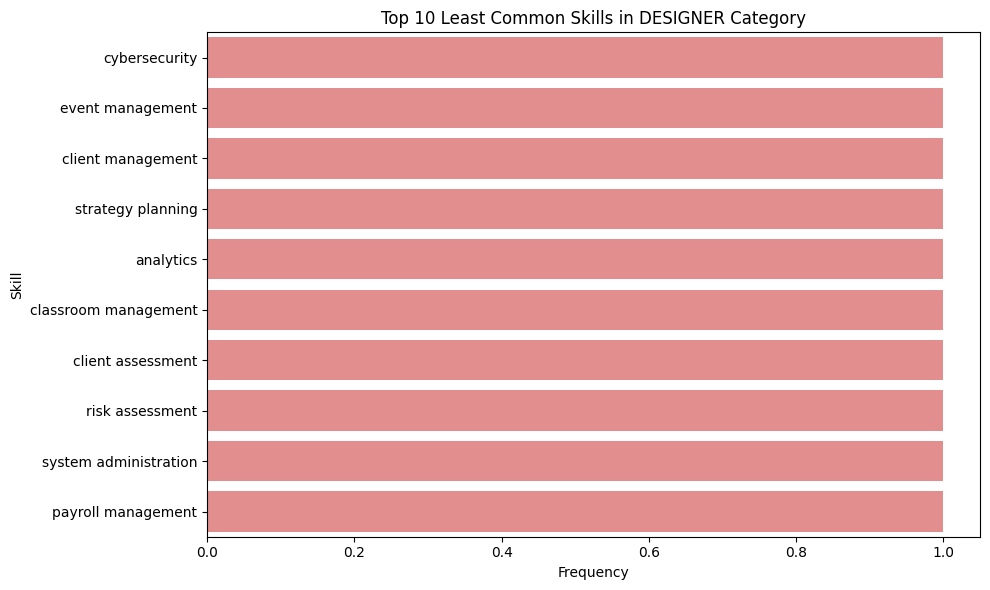

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




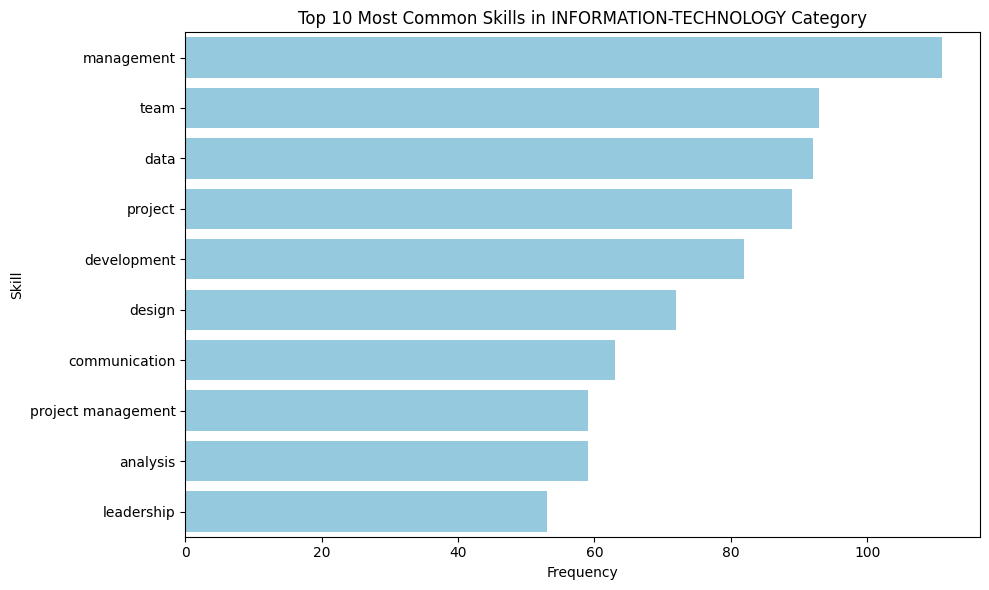

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




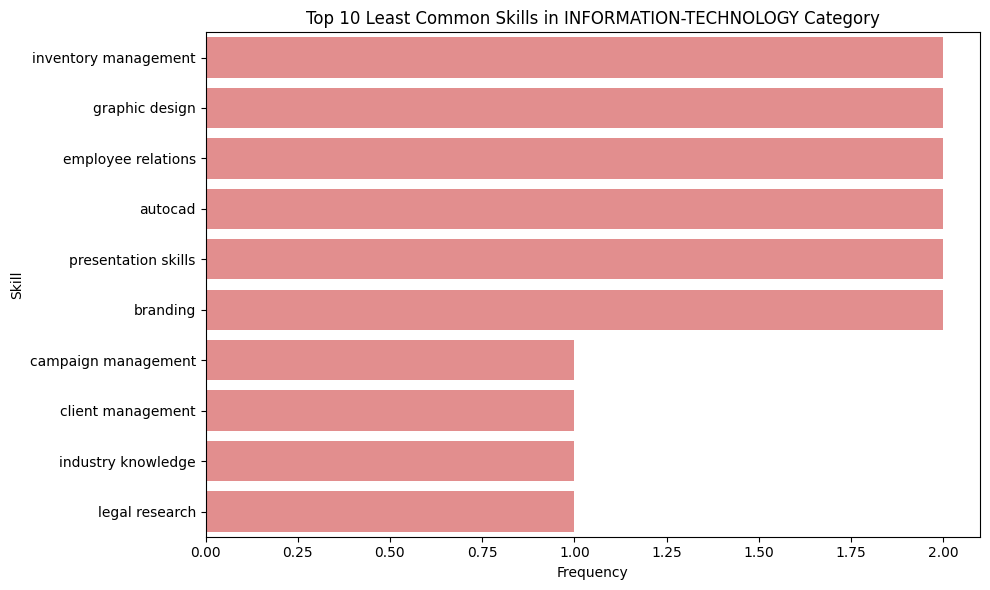

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




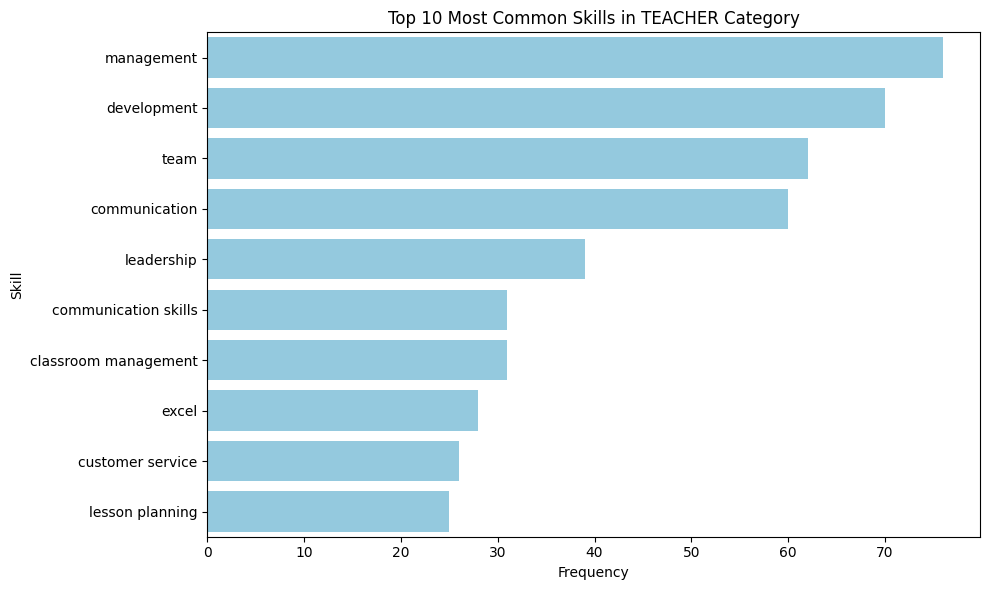

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




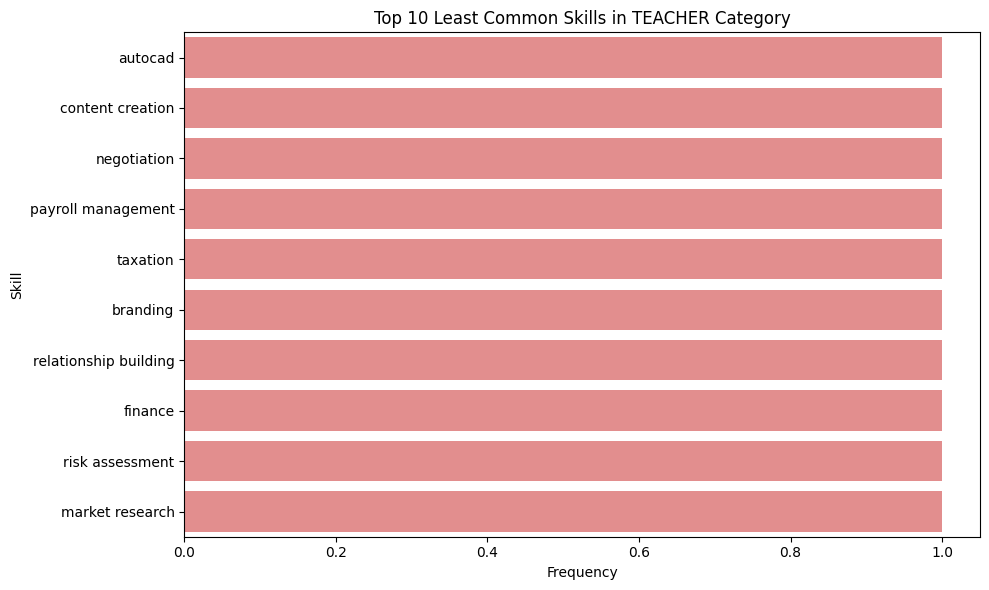

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




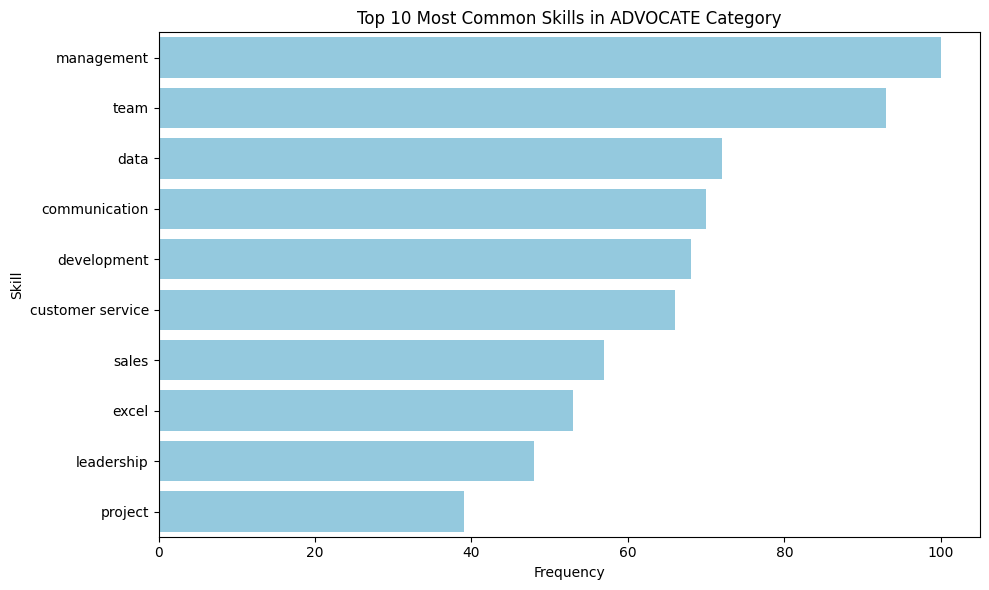

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




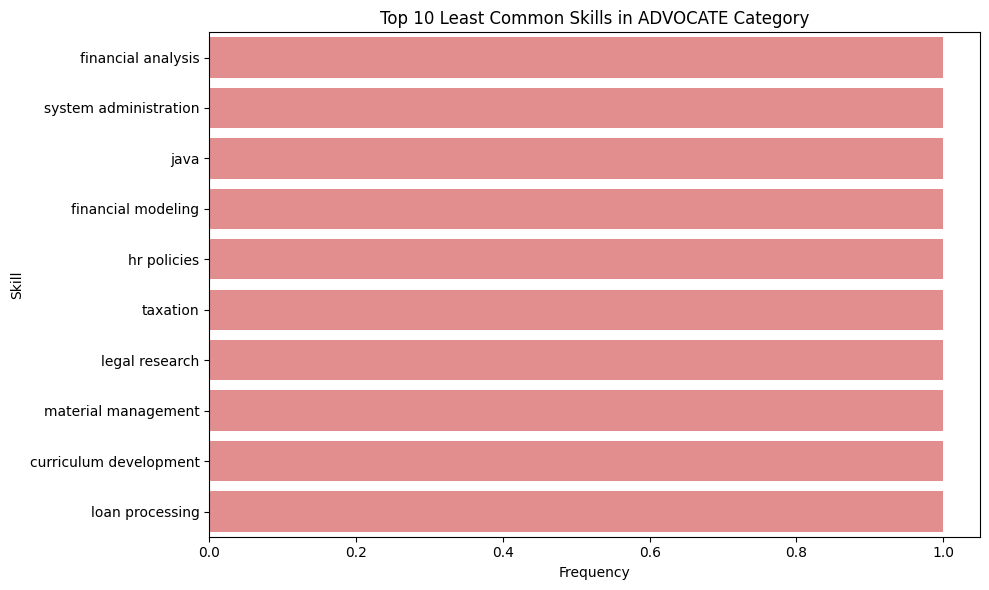

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




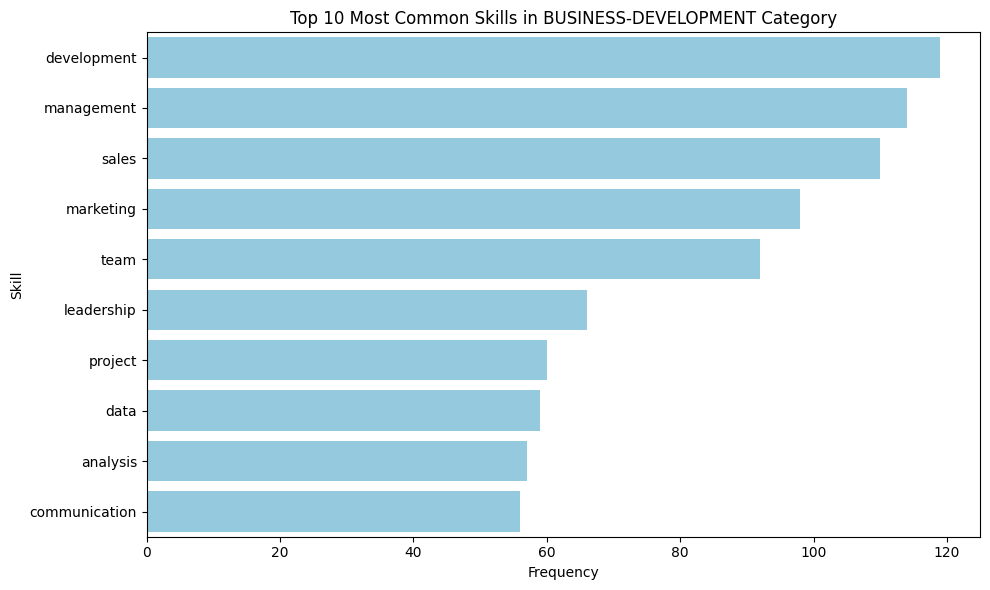

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




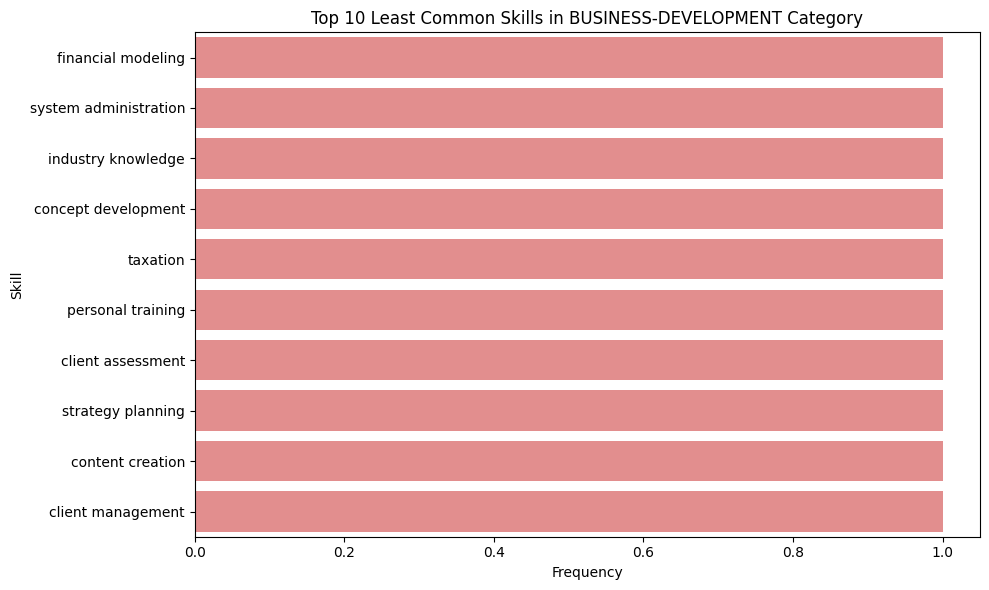

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




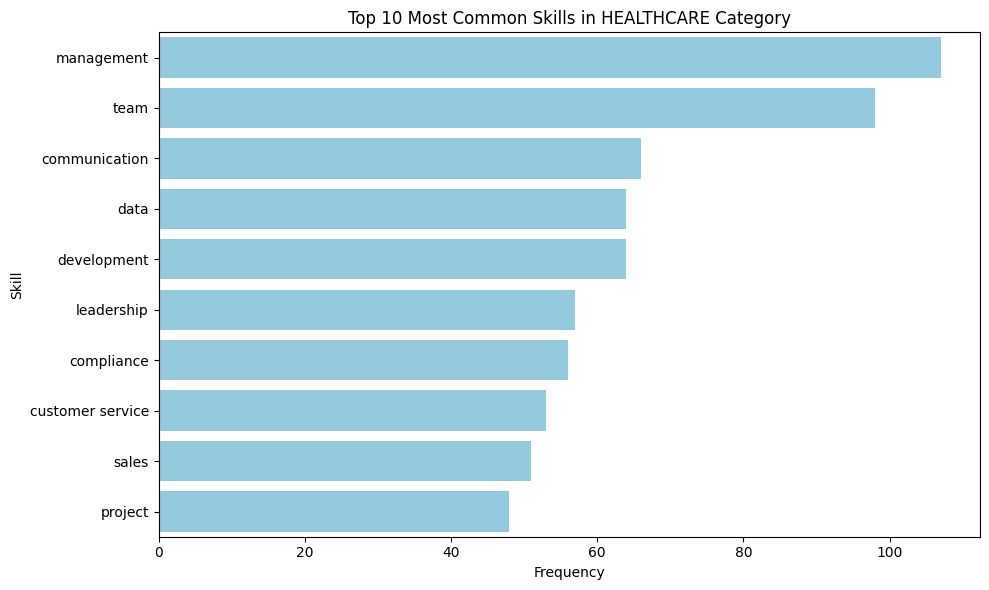

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




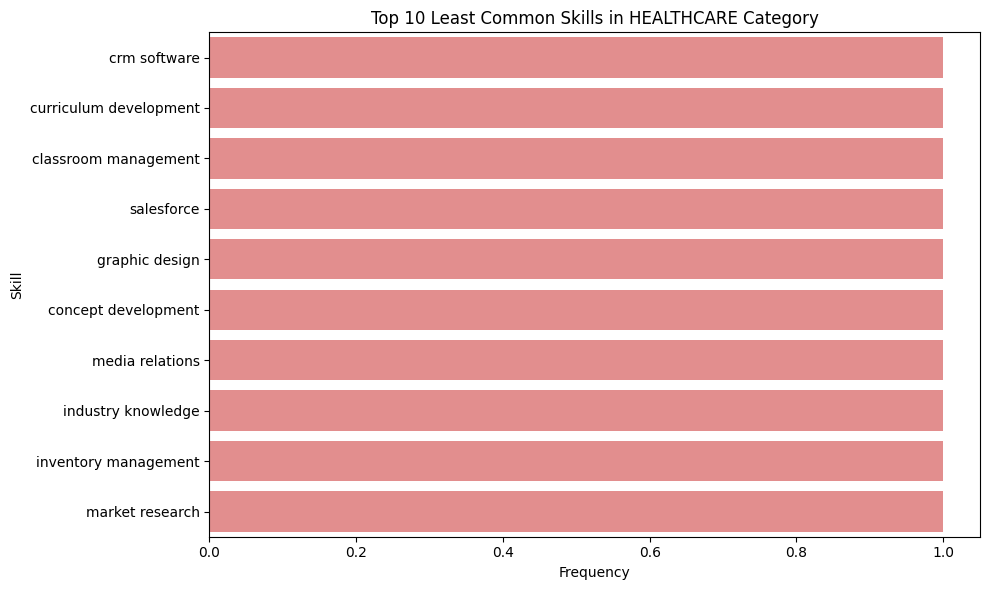

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




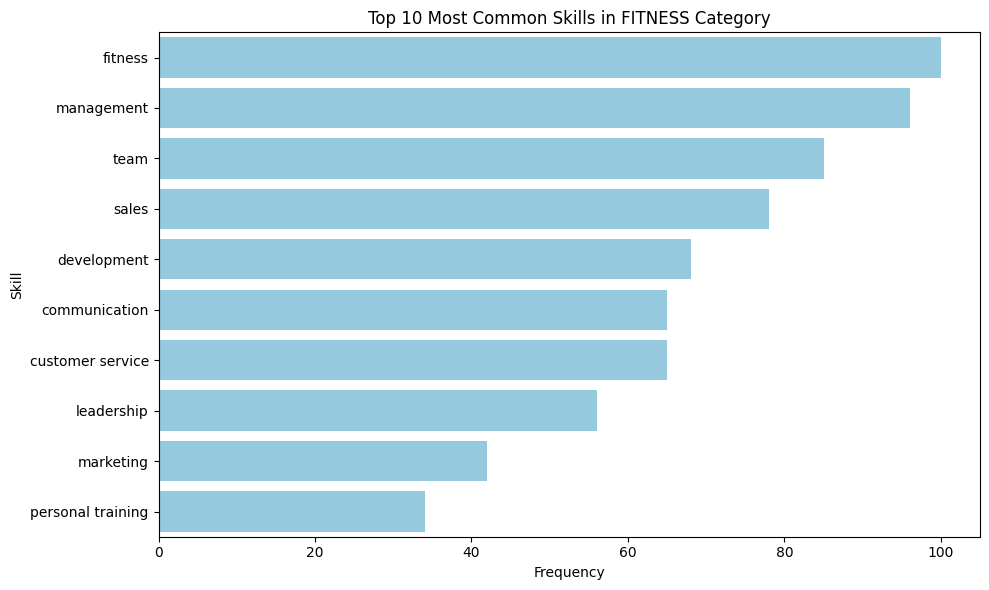

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




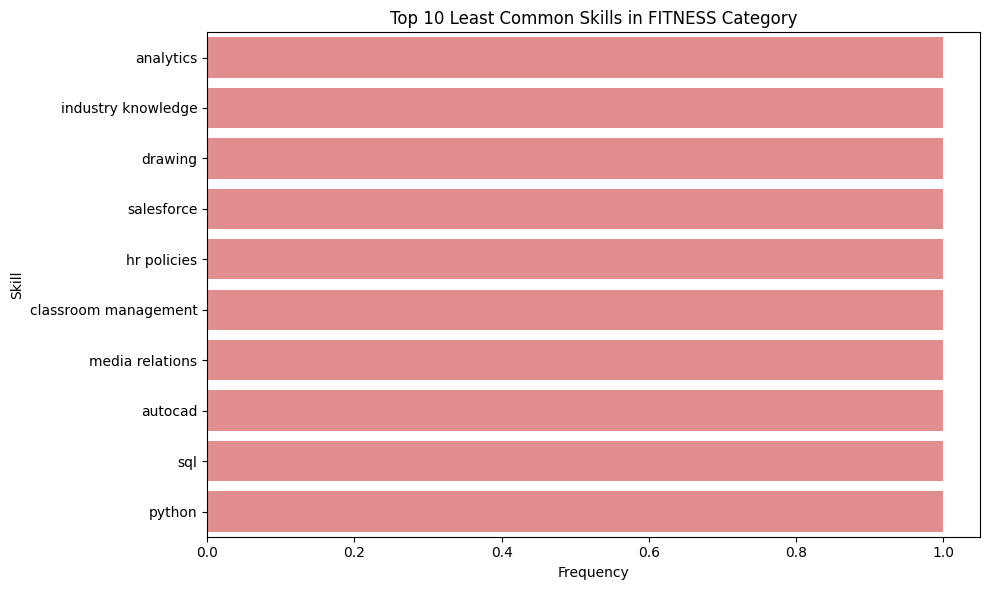

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




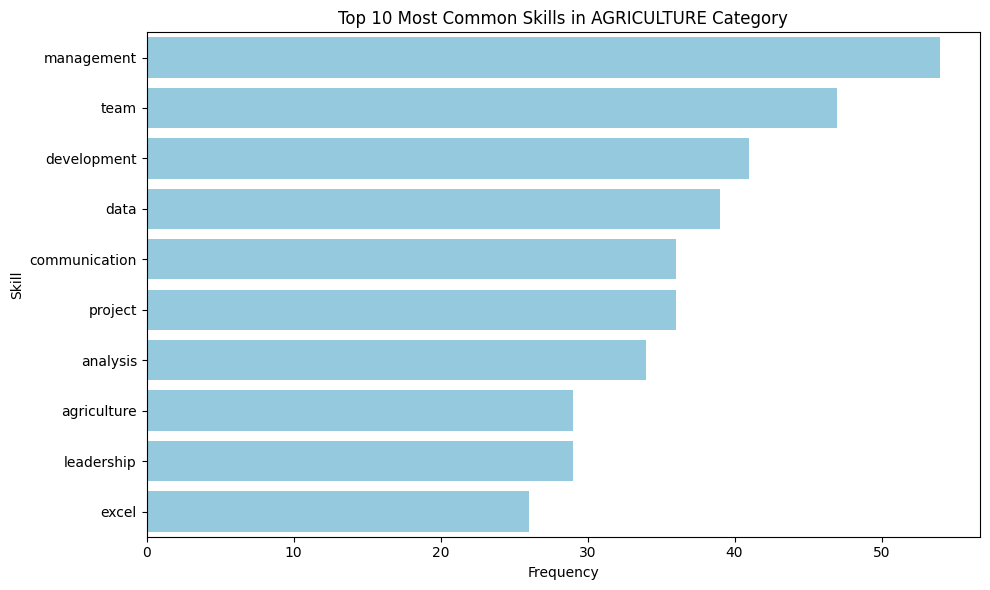

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




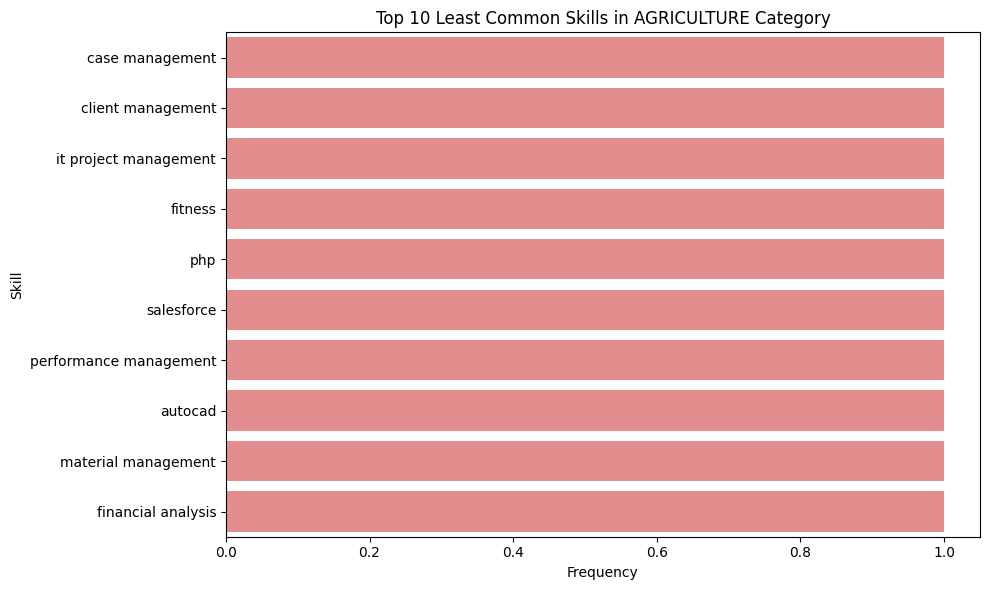

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




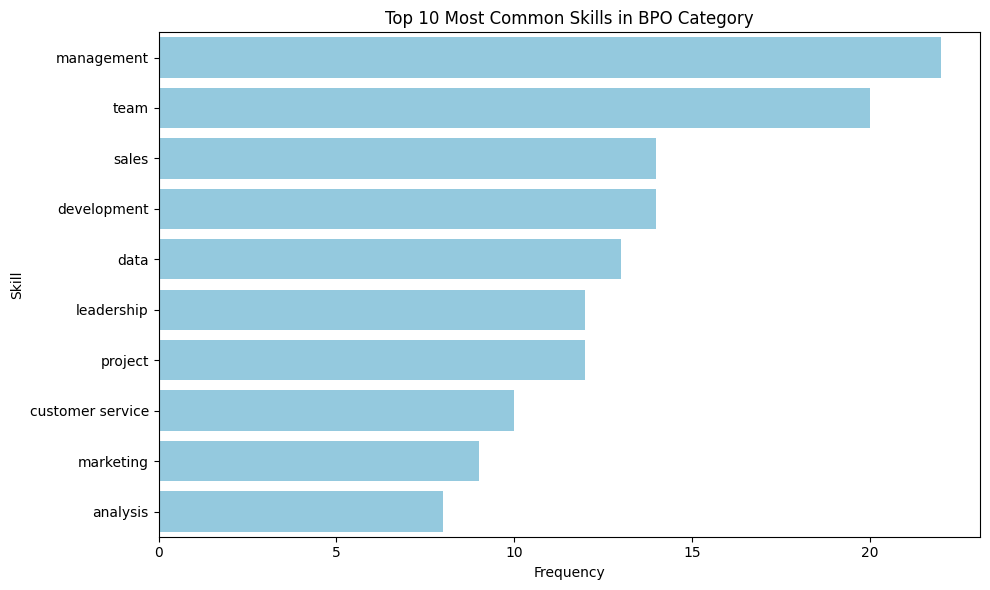

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




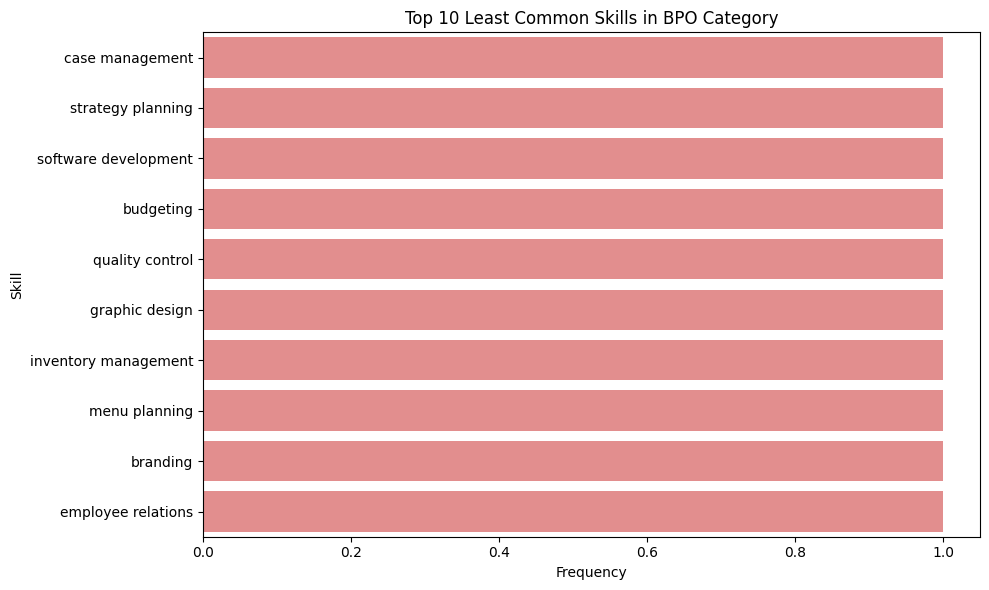

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




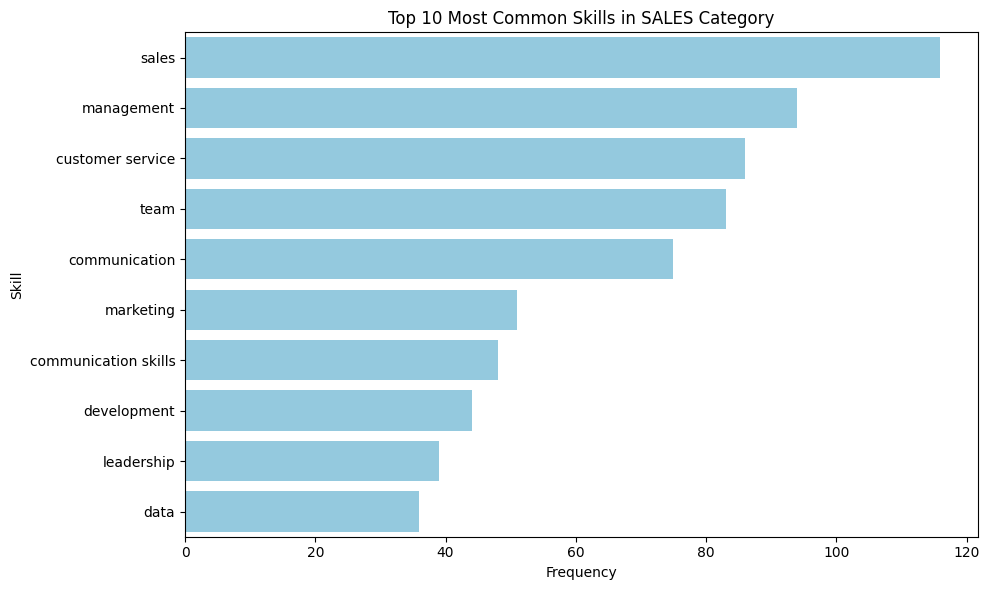

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




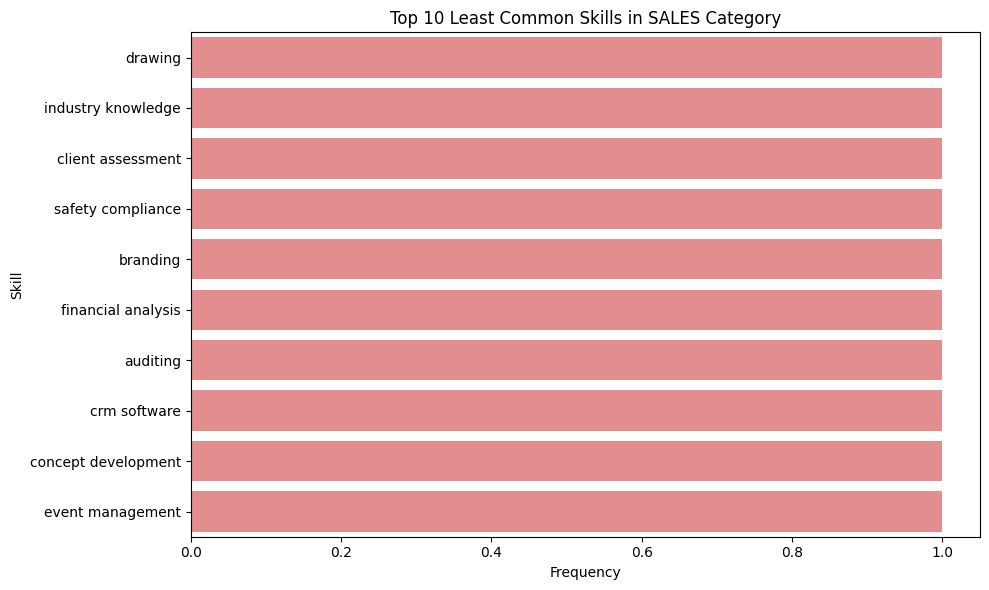

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




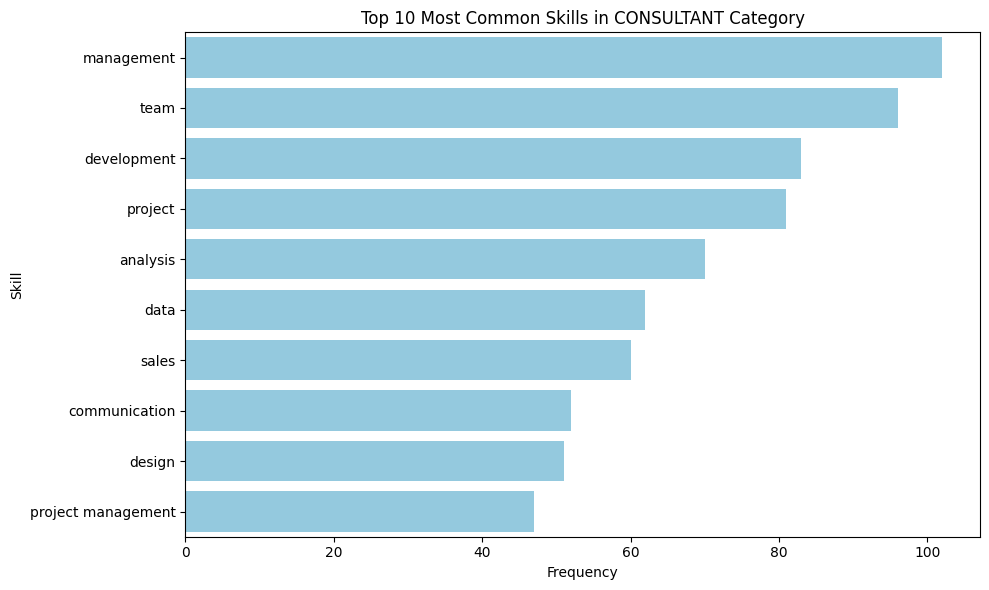

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




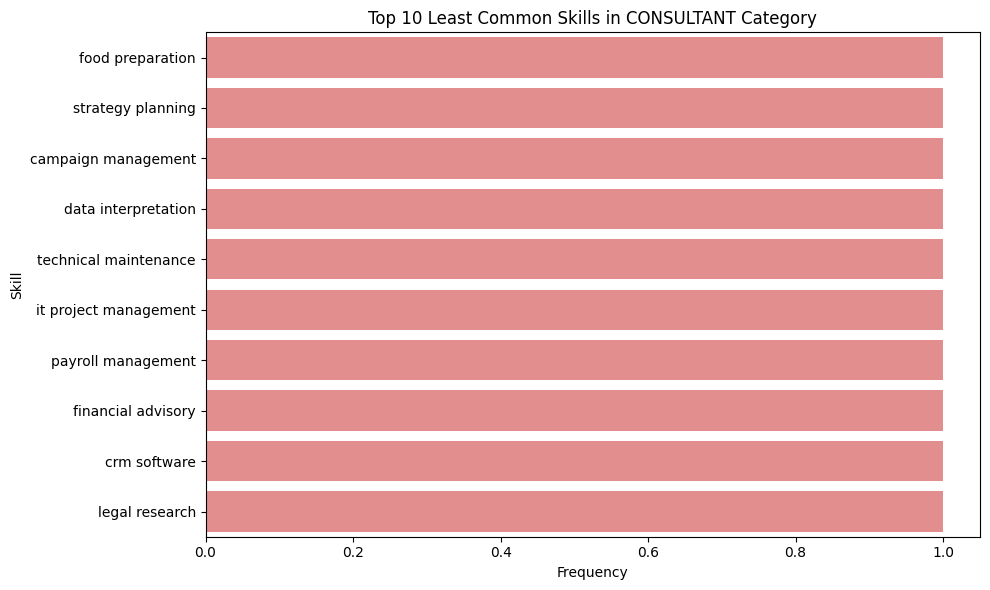

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




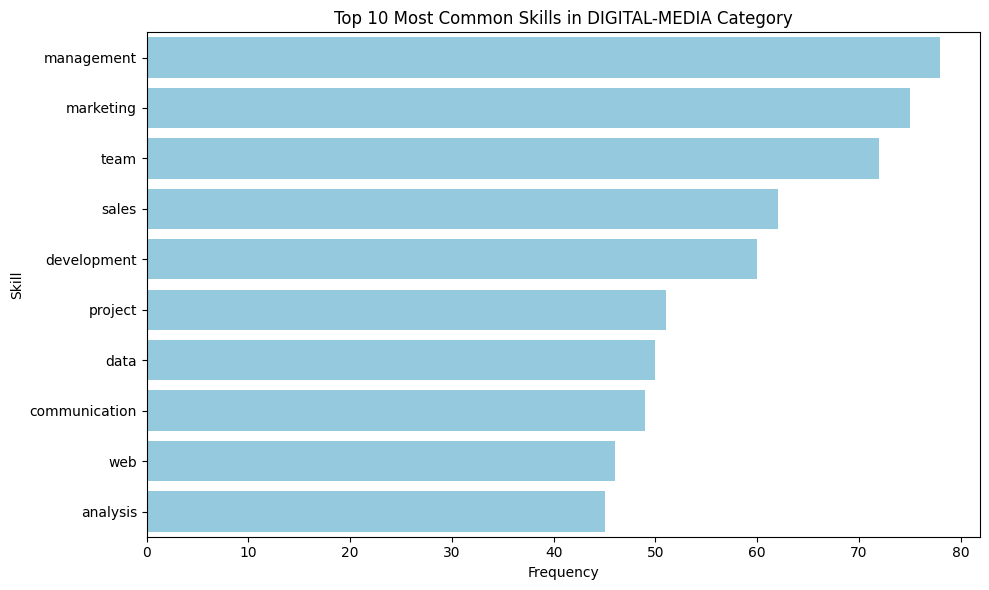

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




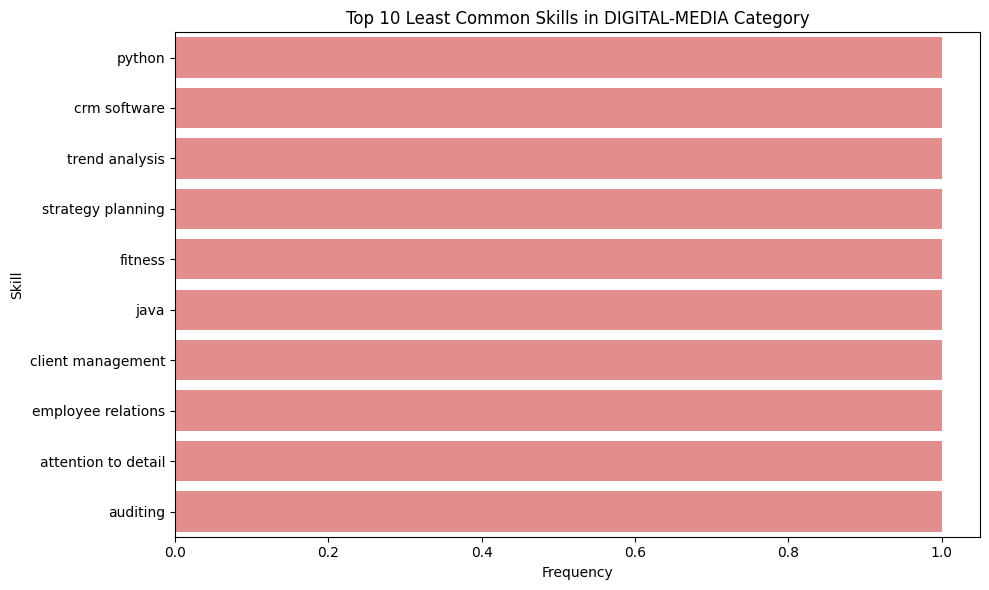

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




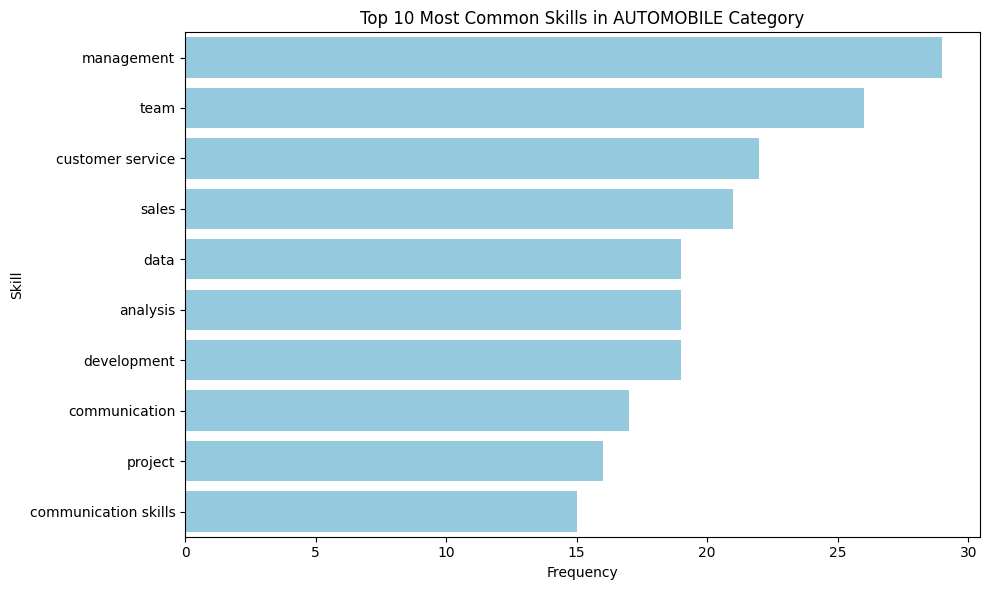

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




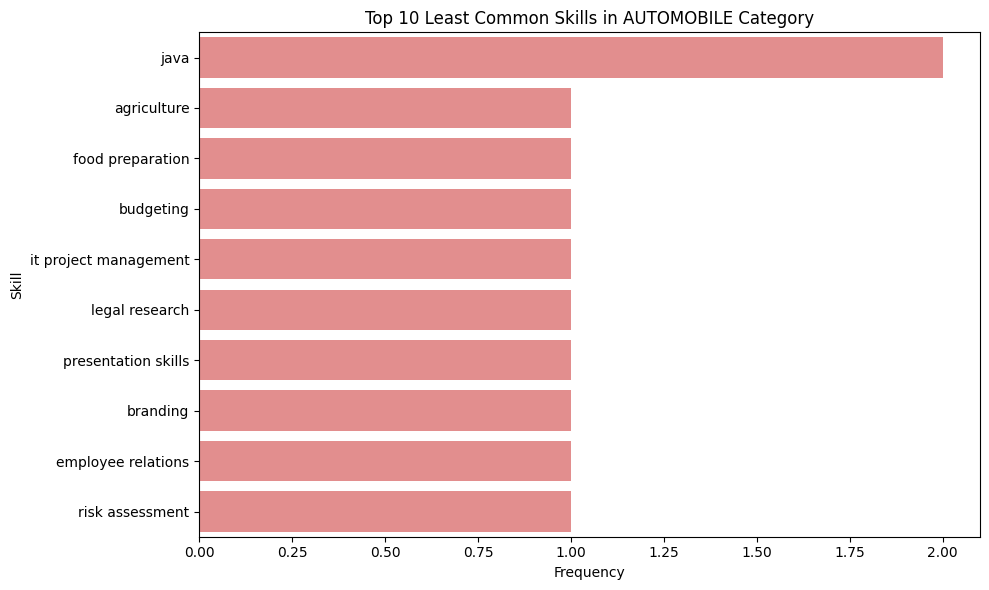

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




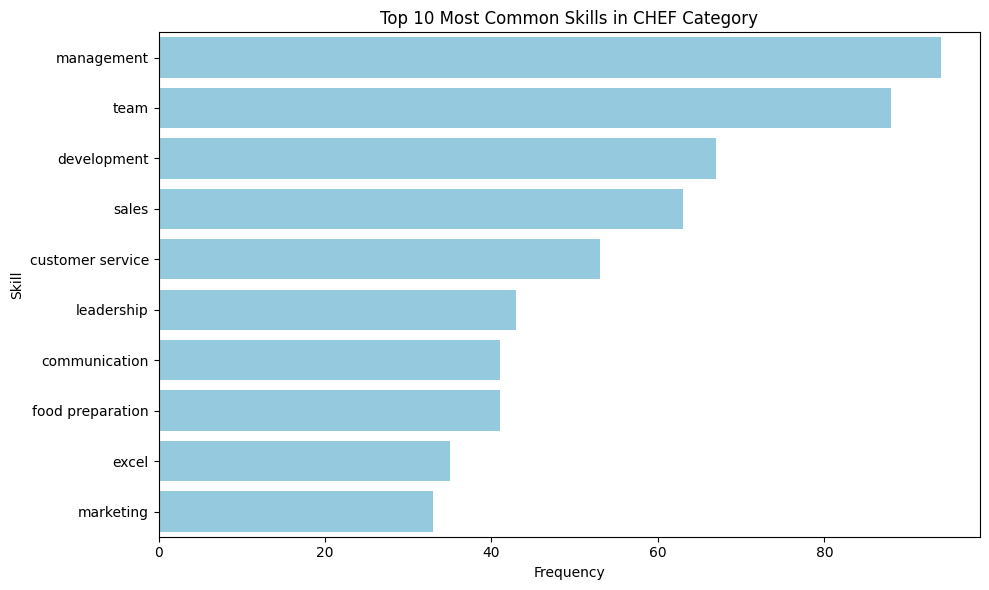

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




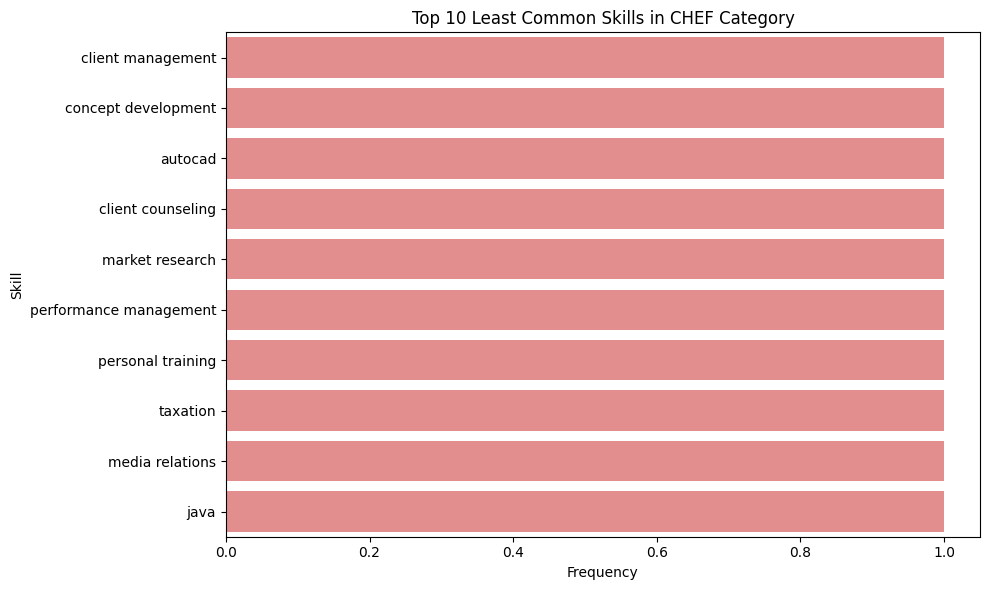

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




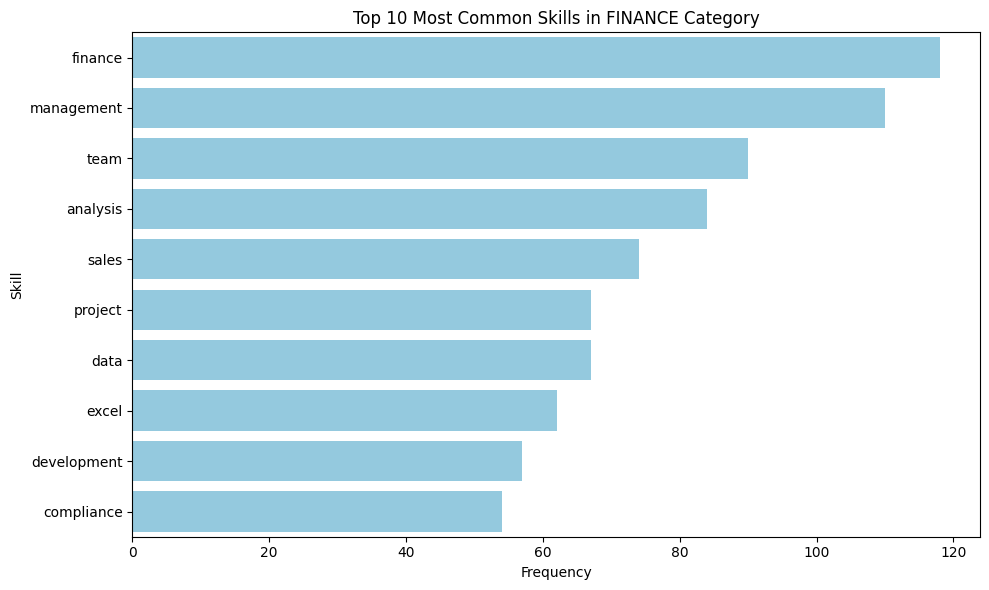

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




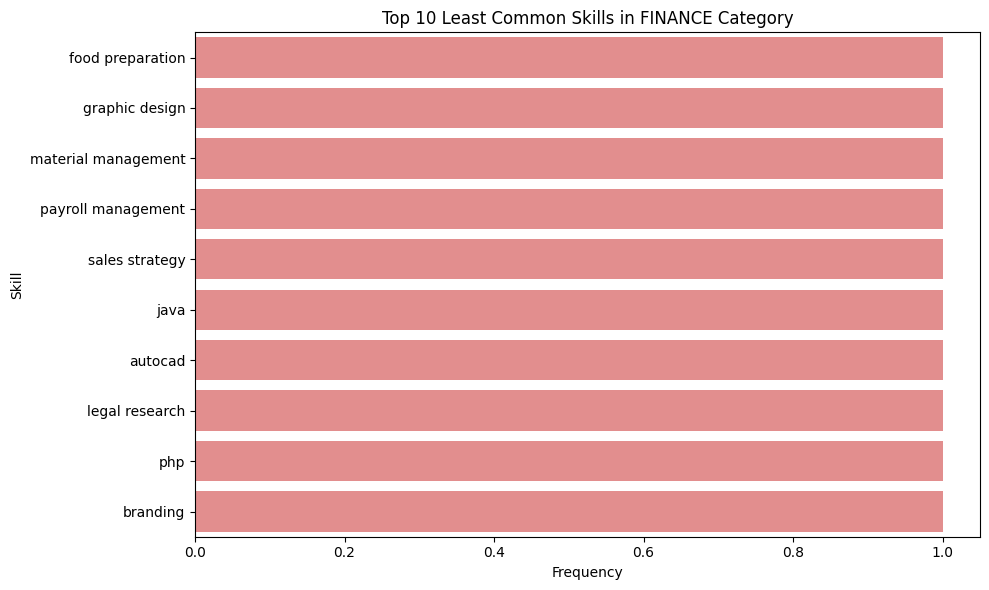

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




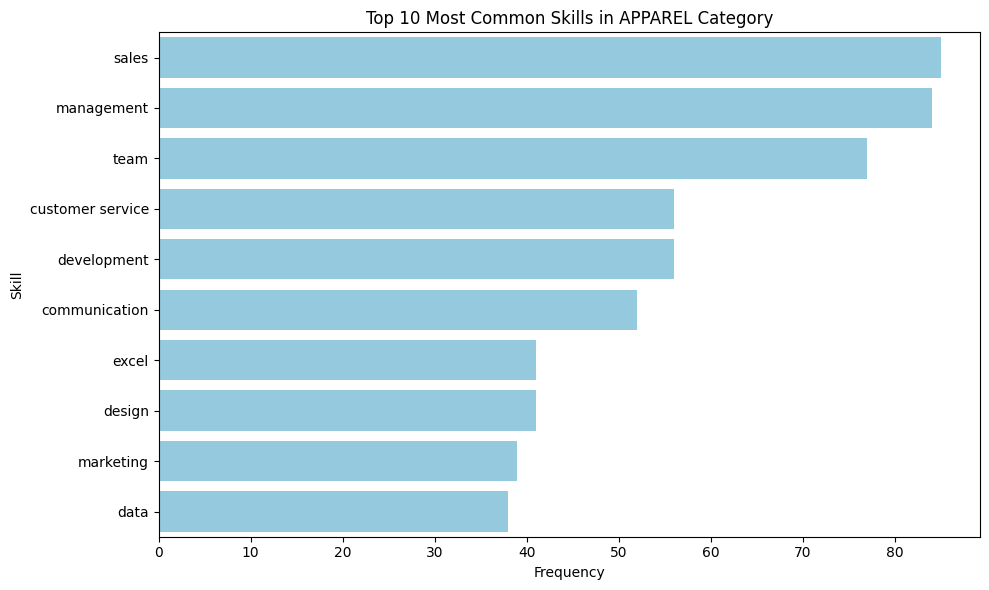

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




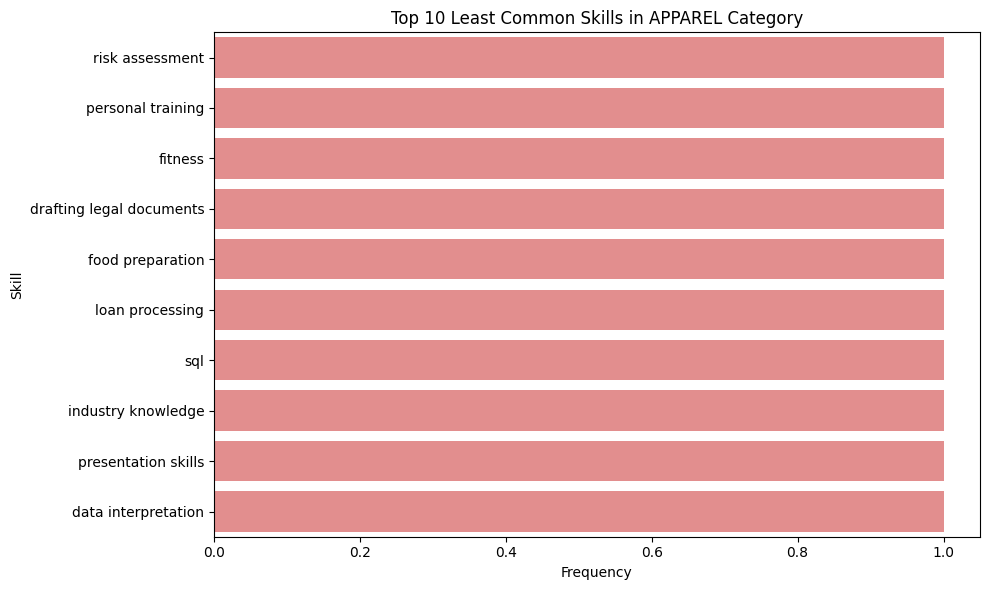

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




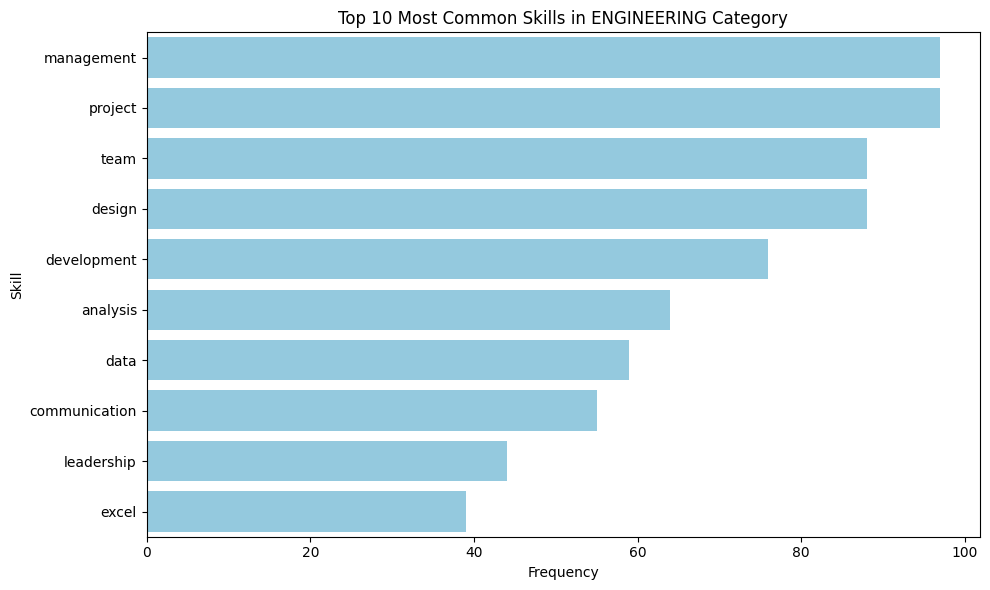

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




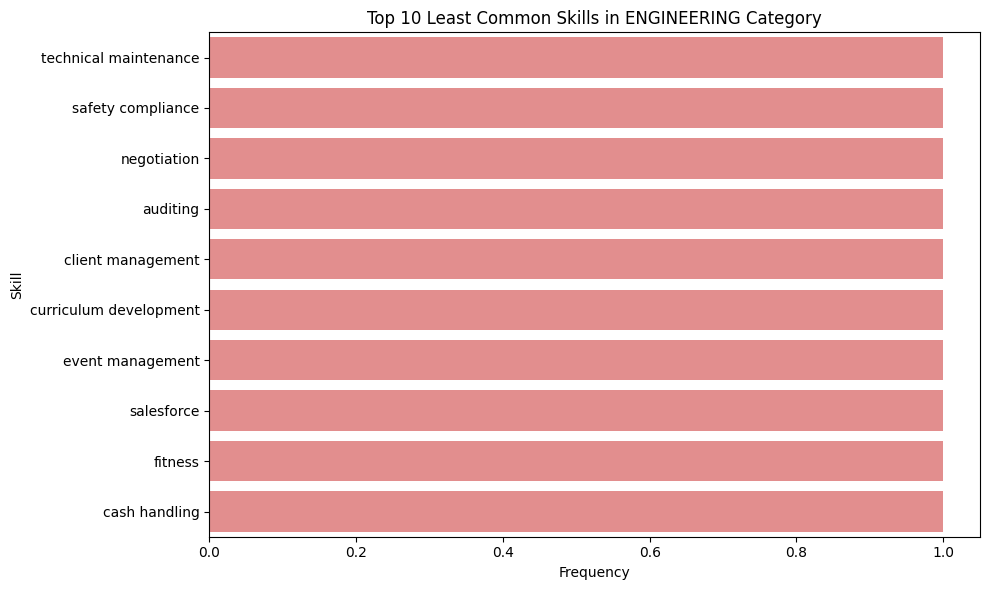

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




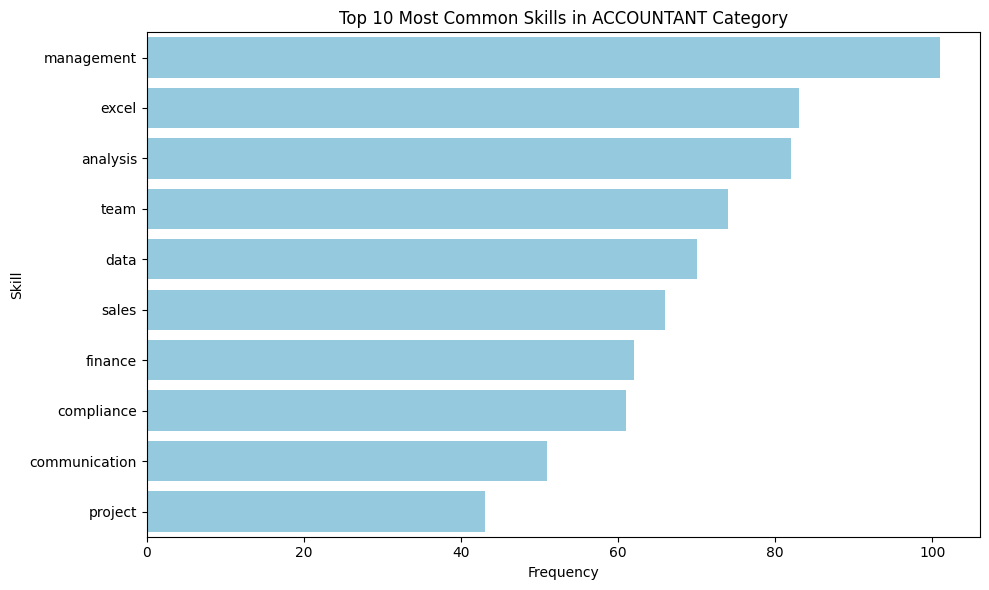

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




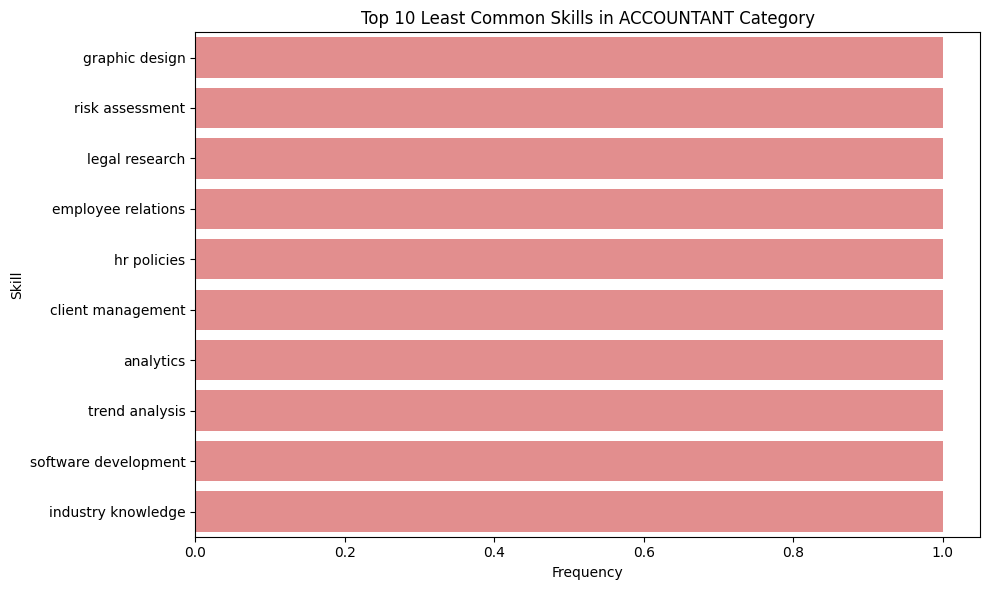

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




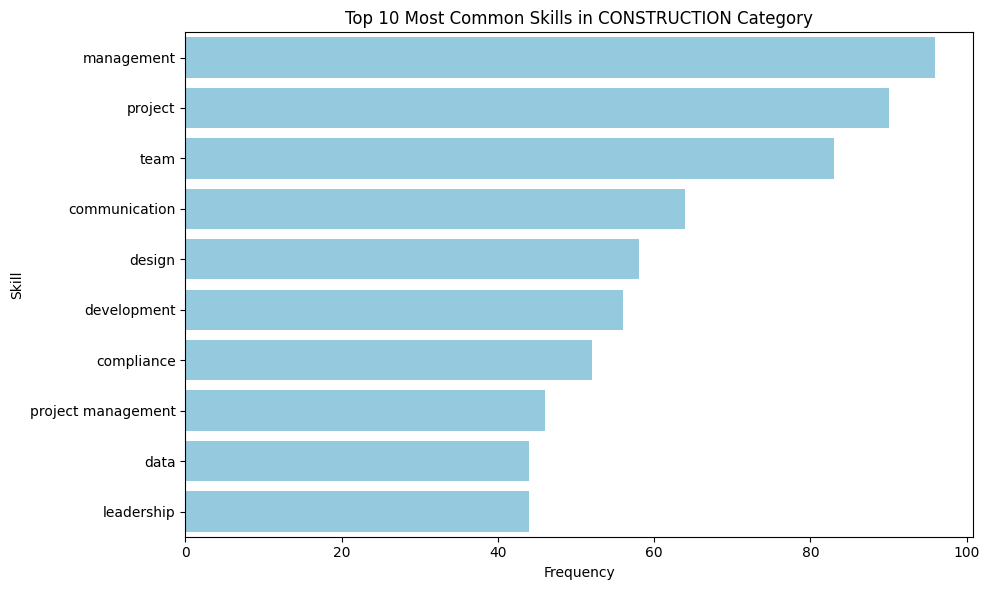

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




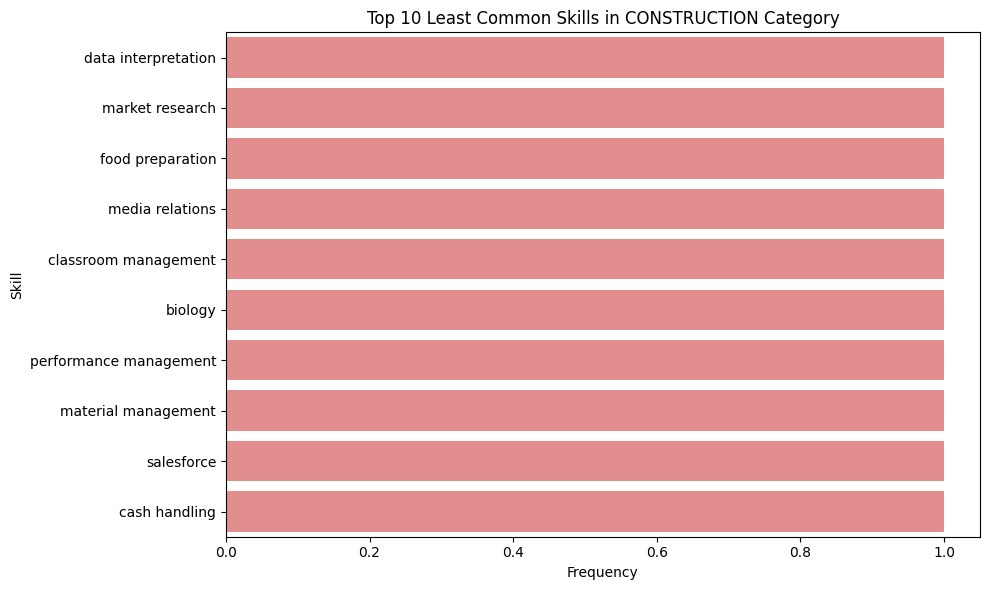

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




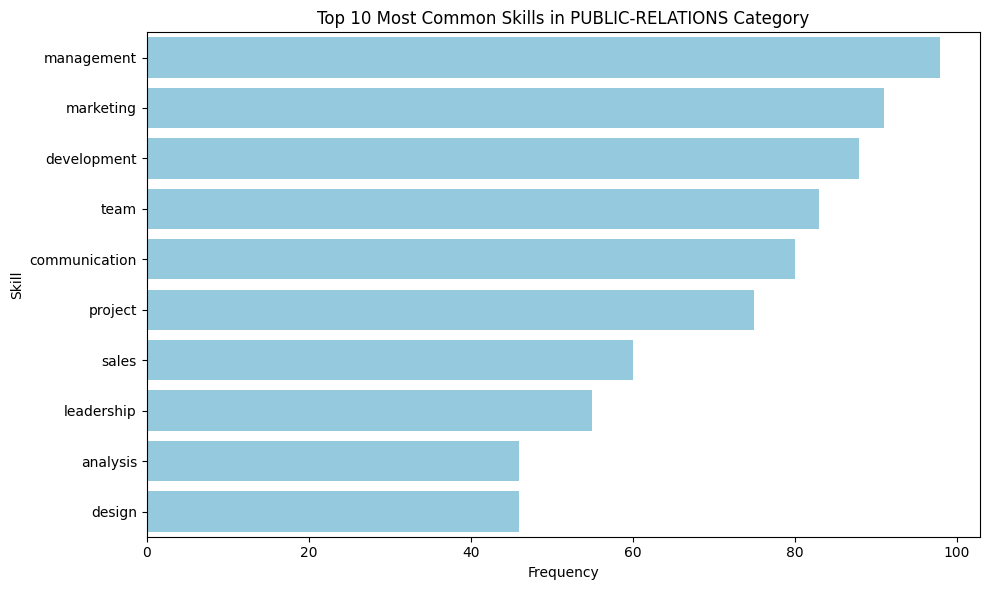

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




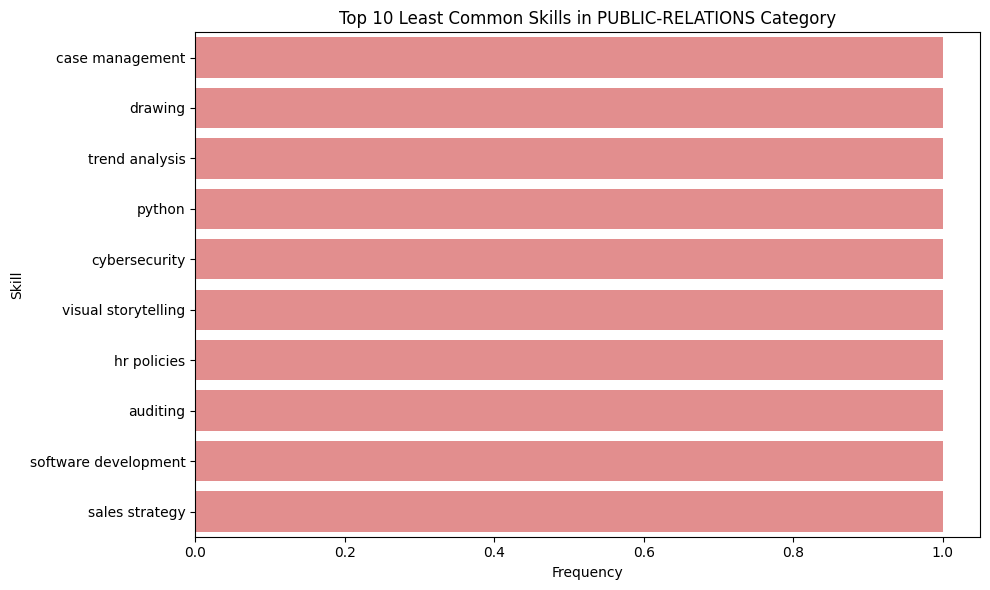

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




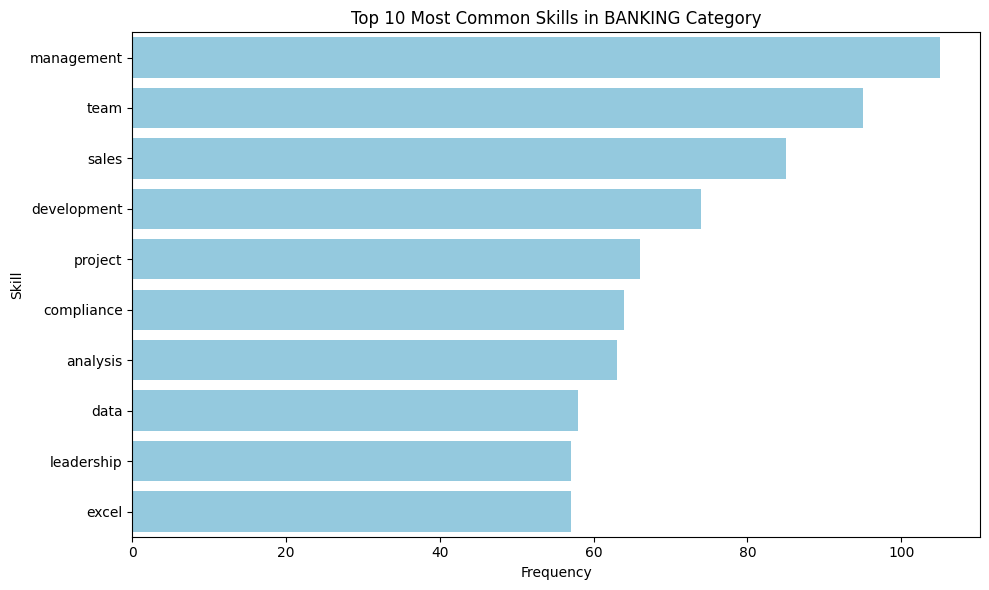

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




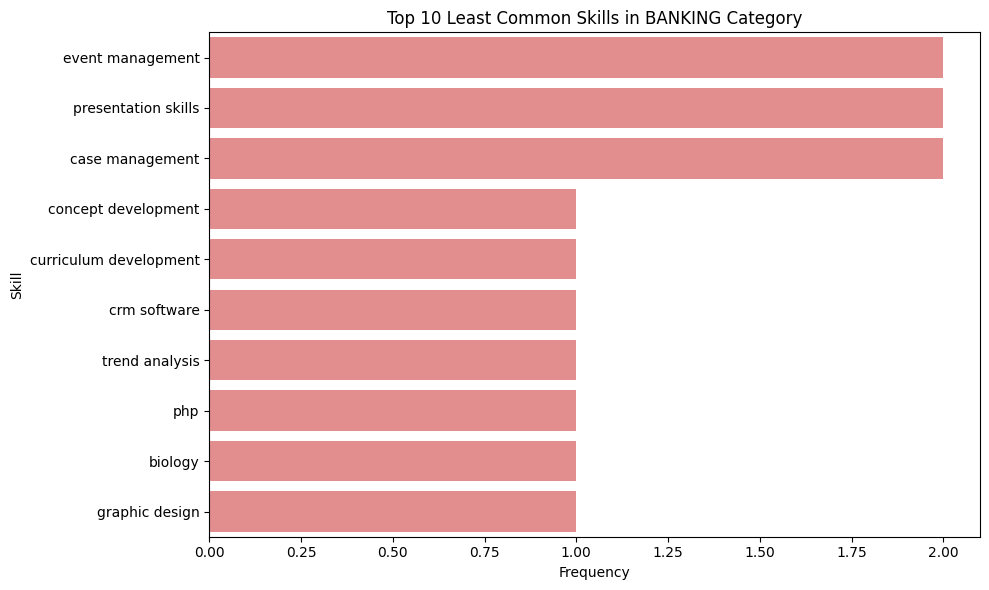

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




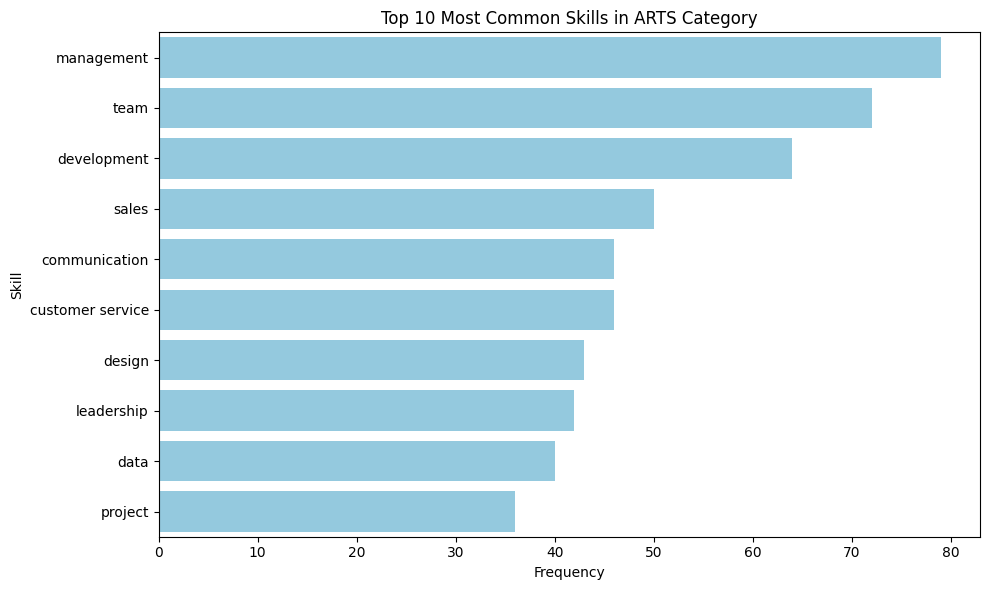

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




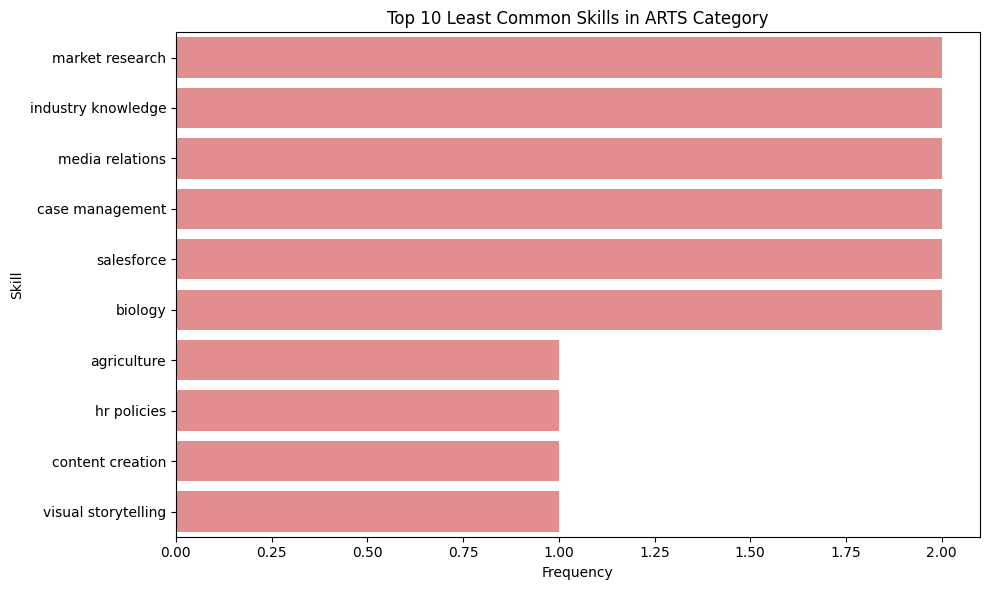

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




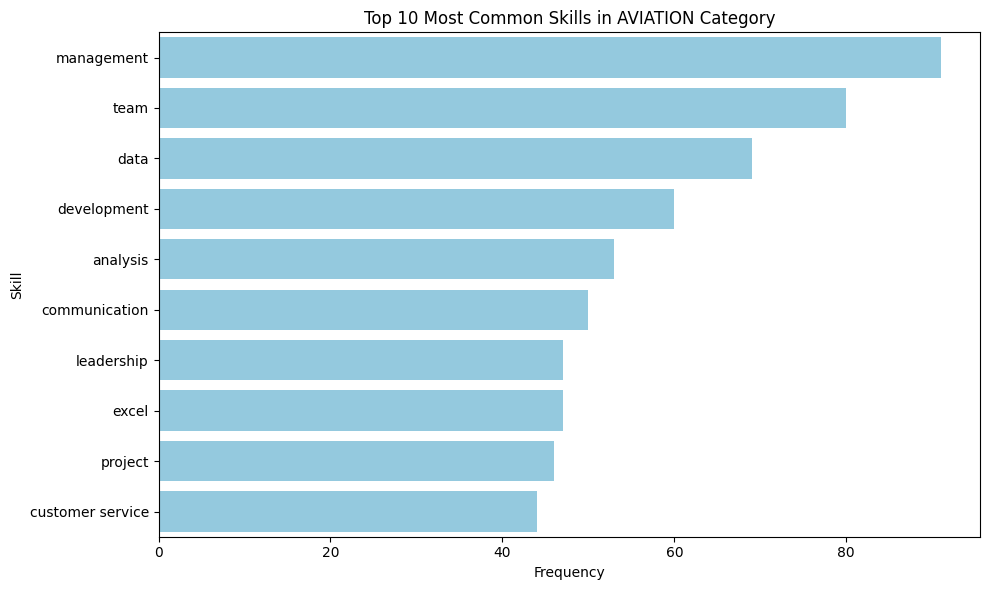

/tmp/ipython-input-2949178962.py:55: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




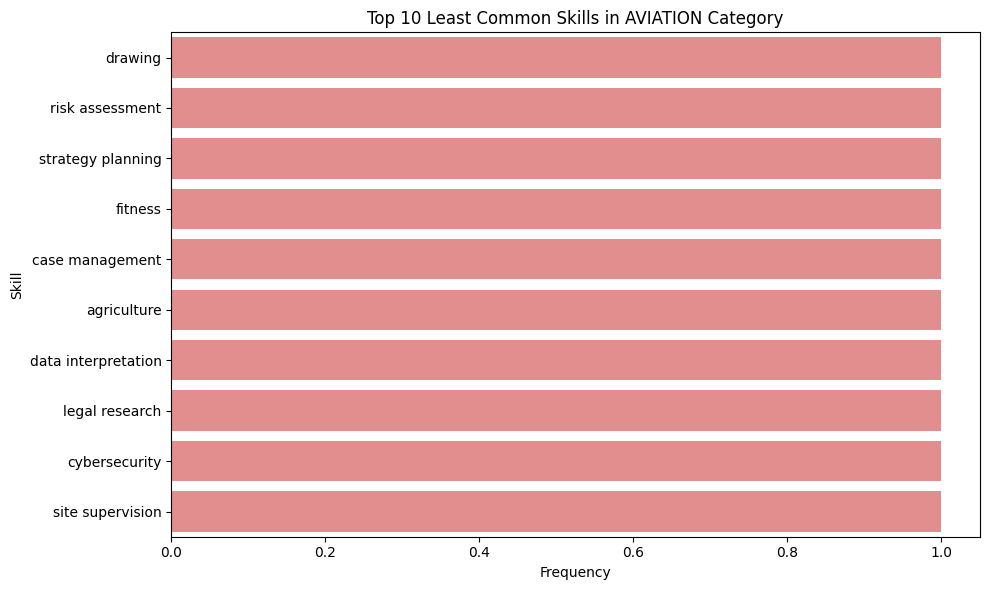

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Re-extract skills using the expanded list from cell uskYBX0HGivn
# Assuming 'df' and 'skills' list from cell uskYBX0HGivn are available
def extract_skills_expanded(text):
    text = str(text).lower()
    found = []
    for s in skills:
        # Escape special characters like "&", "/", etc.
        pattern = r'\b' + re.escape(s.lower()) + r'\b'
        if re.search(pattern, text):
            found.append(s)
    return found

df['Skills_Found_Expanded'] = df['Resume_clean'].apply(extract_skills_expanded)


# Calculate most and least common skills per category using the expanded list
most_least_common_skills_by_category = {}

for category in df['Category'].unique():
    category_df = df[df['Category'] == category]
    all_skills_in_category = [skill for skills_list in category_df['Skills_Found_Expanded'].dropna() for skill in skills_list]
    skill_counts = Counter(all_skills_in_category)

    # Get top 10 most common
    most_common = skill_counts.most_common(10)

    # Get bottom 10 least common (only include skills that appeared at least once)
    least_common = [skill for skill, count in skill_counts.most_common() if count > 0][:-11:-1]
    least_common_with_counts = [(skill, skill_counts[skill]) for skill in least_common]

    most_least_common_skills_by_category[category] = {
        'most_common': most_common,
        'least_common': least_common_with_counts
    }

# Function to create bar plots
def plot_skills(category, skills_list, title_suffix, color):
    if not skills_list:
        print(f"No skills to plot for {category} - {title_suffix}")
        return

    skills = [skill for skill, count in skills_list]
    counts = [count for skill, count in skills_list]

    # Sort for better visualization
    sorted_skills_list = sorted(zip(skills, counts), key=lambda x: x[1], reverse=True)
    skills, counts = zip(*sorted_skills_list)


    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(skills), palette=[color] * len(skills)) # Use specified color
    plt.xlabel("Frequency")
    plt.ylabel("Skill")
    plt.title(f'{title_suffix} Skills in {category} Category')
    plt.tight_layout()
    plt.show()

# Generate plots for most and least common skills per category
for category, skill_data in most_least_common_skills_by_category.items():
    # Plot most common skills
    plot_skills(category, skill_data['most_common'], 'Top 10 Most Common', 'skyblue') # Using skyblue for most common

    # Plot least common skills
    plot_skills(category, skill_data['least_common'], 'Top 10 Least Common', 'lightcoral') # Using lightcoral for least common

In [ ]:
category_skills = (
    df.groupby('Category')['Skills_Found']
      .sum()  # merge all lists of skills
      .apply(lambda x: Counter(x).most_common(10))  # top 10 skills
)

# Convert results to DataFrame
top_skills = []
for cat, skill_counts in category_skills.items():
    for skill, count in skill_counts:
        top_skills.append({'Category': cat, 'Skill': skill, 'Count': count})

top_skills_df = pd.DataFrame(top_skills)
top_skills_df.to_csv('top_skills_per_category.csv', index=False)
print("✅ Top skills extracted and saved as top_skills_per_category.csv")


✅ Top skills extracted and saved as top_skills_per_category.csv


In [ ]:
df['Skills_Found'] = df['Resume_clean'].apply(extract_skills)


In [ ]:
global_skills = (
    top_skills_df.groupby('Skill')['Count']
    .sum()
    .sort_values(ascending=False)
    .head(50)
    .index.tolist()
)

print("🔥 Top global skills/keywords for model:")
print(global_skills)


🔥 Top global skills/keywords for model:
['management', 'team', 'development', 'communication', 'sales', 'project', 'data', 'leadership', 'analysis', 'excel', 'customer service', 'design', 'marketing', 'finance', 'project management', 'fitness', 'communication skills', 'employee relations', 'budgeting', 'performance management', 'web', 'food preparation', 'personal training', 'classroom management', 'agriculture', 'lesson planning']


In [ ]:
import pandas as pd
from collections import Counter
import re

# Load the cleaned data
df = pd.read_csv('cleaned_resume.csv')

# Define skills list (assuming this is the intended list based on previous interactions)
skills = [
    # General
    'management', 'leadership', 'team', 'communication', 'excel', 'python',
    'java', 'sql', 'analysis', 'marketing', 'finance', 'agriculture',
    'project', 'design', 'data', 'sales', 'web', 'development', 'biology',
    'php', 'fitness',

    # HR
    'recruitment & talent acquisition', 'employee relations', 'hr policies','compliance',
    'payroll management', 'performance management',

    # IT
    'software development', 'troubleshooting & technical support',
    'system administration', 'cybersecurity', 'it project management',

    # Teaching
    'lesson planning', 'classroom management', 'curriculum development',
    'student assessment', 'communication & patience',

    # Legal
    'legal research', 'drafting legal documents', 'case management',
    'client counseling', 'litigation support', 'attention to detail',

    # Sales
    'sales strategy', 'market research', 'salesforce', 'negotiation',
    'relationship building',

    # Fitness
    'personal training', 'workout programming', 'nutrition guidance',
    'cpr & first aid', 'client assessment', 'motivation & coaching',

    # Agriculture
    'crop management', 'soil testing', 'farm equipment handling',
    'irrigation techniques', 'pest & disease management', 'supply chain knowledge',

    # BPO / Sales
    'customer handling', 'telecalling', 'upselling & cross-selling',
    'crm software', 'problem solving', 'communication skills',

    # Consulting
    'research & analysis', 'strategy planning', 'presentation skills',
    'data interpretation', 'client management', 'industry knowledge',

    # Digital Media
    'social media management', 'content creation', 'seo / sem',
    'analytics', 'graphic design', 'campaign management',

    # Automobile
    'vehicle diagnostics', 'repair & maintenance', 'technical inspection',
    'autocad', 'mechanical knowledge', 'quality control',

    # Chef
    'food preparation', 'menu planning', 'food safety & hygiene',
    'inventory management', 'knife skills', 'time management',

    # Finance
    'financial analysis', 'budgeting', 'taxation', 'auditing',
    'financial modeling', 'risk management',

    # Apparel / Fashion
    'textile knowledge', 'pattern making', 'garment construction',
    'cad tools', 'trend analysis',

    # Construction
    'project management', 'site supervision', 'estimation & billing',
    'safety compliance', 'material management',

    # Public Relations
    'media relations', 'press release writing', 'event management',
    'crisis communication', 'branding', 'content writing',

    # Banking
    'customer service', 'kyc compliance', 'cash handling',
    'loan processing', 'financial advisory', 'risk assessment',

    # Arts
    'creative designing', 'drawing', 'visual storytelling',
    'digital art tools', 'concept development',

    # Aviation
    'aircraft safety procedures', 'technical maintenance',
    'navigation & weather knowledge', 'emergency handling'
]

# Function to extract skills
def extract_skills(text):
    text = str(text).lower()
    found = []
    for s in skills:
        # Escape special characters like "&", "/", etc.
        pattern = r'\b' + re.escape(s.lower()) + r'\b'
        if re.search(pattern, text):
            found.append(s)
    return found

# Add 'Skills_Found' column
df['Skills_Found'] = df['Resume_clean'].apply(extract_skills)


# Aggregate by category
category_skills = (
    df.groupby('Category')['Skills_Found']
    .sum()  # combine all skill lists
    .apply(lambda x: Counter(x).most_common(10))  # top 10 skills per category
)

# Convert to readable DataFrame
top_skills = []
for cat, skill_counts in category_skills.items():
    for skill, count in skill_counts:
        top_skills.append({'Category': cat, 'Skill': skill, 'Count': count})

top_skills_df = pd.DataFrame(top_skills)
top_skills_df.to_csv('category_top_skills.csv', index=False)